## Project: Low Temperature UMBS Optimization
#### Investigator: Yushuai Liu
#### Analysis: C. Bryan Daniels
#### Sequencing: Chang Ye
#### Supervisor: Qing Dai
#### Date: September 2, 2024

### Set Up

#### Environment

In [1]:
import os, sys, subprocess, warnings, pysam
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML, Image
from operator import itemgetter as items

In [2]:
workspace_path = Path.cwd()
home_path      = workspace_path/'..'
parent_path    = home_path/'..'
sys.path.append(f"{home_path}/scripts/")

os.environ['PATH'] = f"{Path.home()}:{os.environ['PATH']}"
os.environ['_JAVA_OPTIONS'] = '-Xmx8g'
nc = os.cpu_count() # Number of cores

#### Functions

In [3]:
import imports
from imports import *

In [443]:
from importlib import reload
import imports
reload(imports)
from imports import *

In [455]:
from importlib import reload
import human2
reload(human2)
from human2 import *

## Experiment

### Background
Since Tanner has been focusing on finishing UMBS work, I will do more optimizations for lower temperature. In this batch, we will test two different methods and different temperatures from 25 to 55 C while keeping the recipe the same. Method A is mixing protect buffer and sample first, then adding BS reagent to conducting BS treatment. Method B is mixing BS reagent and protect buffer first, then add sample DNA sample. To test the conversion efficiency under different treatment conditions, I will build UMBS-seq libraries using selected DNA and RNA samples with less damage.

[Full Protocol](../docs/protocol.pdf)

### Libraries

![Libraries](../libraries.png)

In [4]:
mkpath('figures')
! cp ../libraries.png figures/.

>>> {figures} 22:31:59_10-15-2024


### Notion Notebook

[Notion Notebook](https://www.notion.so/yech/241002-UMBS-seq-DNA-Liu-Low-Temperature-UMBS-Optimization-a089e47a89b2455dba6e1826cc1272ab?pvs=4)

## Genomic References

<aside>

- ***164 mer oligo (77+, 127+, 93-, 128-)*** [5mC164.fa](https://raw.githubusercontent.com/prairie-guy/Genomic_References/main/BAT_seq/5mC164.fa)

- **200 mer oligo (CG 123+; 124- )**
        [200merMeth.fa](https://raw.githubusercontent.com/prairie-guy/Genomic_References/main/BAT_seq/200merMeth.fa);
        [200mer_oligo_for_methylation.dna](https://prod-files-secure.s3.us-west-2.amazonaws.com/04c7f2aa-4abc-46e2-98f7-687750d34a4b/58ca08e3-6919-4711-ad4d-d2692f752922/200mer_oligo_for_methylation.dna)

- **pUC19 plasmid (All CpG motifs are 100% methy)**
        [pUC19.fa](https://raw.githubusercontent.com/prairie-guy/Genomic_References/main/BAT_seq/pUC19.fa)

- **lambda DNA (All sites are unmethylated)**
        [lambda.fa](https://raw.githubusercontent.com/prairie-guy/Genomic_References/main/BAT_seq/lambda.fa)


- **Homo sapiens.GRCh38.rRNA.fa.gz**
        [rRNA](https://github.com/prairie-guy/Genomic_References/raw/refs/heads/main/RNA/Homo_sapiens.GRCh38.rRNA.fa.gz)

- **Homo sapiens.GRCh38.111.primary_assembly.fa.gz** (**Note:** human.fa edited to only contain regions: chr 1-22, X, Y, MT)
       [DNA](https://github.com/prairie-guy/Genomic_References/raw/refs/heads/main/DNA/Homo_sapiens.GRCh38.111.primary_assembly.fa.gz)

- **Homo sapiens.GRCh38.111.chr.gtf.gz**
        [GTF](https://github.com/prairie-guy/Genomic_References/raw/refs/heads/main/DNA/Homo_sapiens.GRCh38.111.chr.gtf.gz)

- **Arabidopsis thaliana**
        [DNA](https://github.com/prairie-guy/Genomic_References/raw/refs/heads/main/DNA/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa.gz)

        - Note: Chr names across all fasta and GTF files must be unique. For Arabidopsis, fasta headers edited:  >1 -> >ar1, ....

<aside>

#### Define `refs_gen` as Genomic Refs with Fasta Files
**Warning: Make sure each Chr through all Fasta Files are Unique**

In [7]:
#refs_gen = ['5mC164','pUC19','lambda']
refs_gen = ['lambda','pUC19']

###
refs_gen

['lambda', 'pUC19']

#### Define `refs_chr` as Select Chr within a `refs_gen`

In [8]:
#refs_chr = ['1','Pt']
#refs_chr = ['2','MT','X','Y']
refs_chr = []
###
refs_chr

[]

#### Def `refs` as Set of `refs_gen` and `refs_chr`

In [9]:
refs = list(set(refs_gen + refs_chr))
refs

['pUC19', 'lambda']

#### Create Histat-3n Combined Reference Indexes for each `refs_gen`

In [10]:
index_refs(refs_gen)

'../../reference/hisat3n/lambda_pUC19 hisat-3n index exists'

In [11]:
get_ref('lambda_pUC19','fa')

#### Reference Methylation Positions

In [12]:
correct_neb_bias = False

###
! rm {parent_path}/reference/meth/lambda.meth
if correct_neb_bias:
    ! ln -s {parent_path}/reference/meth/lambda_neb.meth    {parent_path}/reference/meth/lambda.meth
else:
    ! ln -s {parent_path}/reference/meth/lambda_unmeth.meth {parent_path}/reference/meth/lambda.meth

refs_meth = {ref: pd.read_csv(get_ref(ref,'meth'),header=None)[0].tolist() for ref in refs}

In [14]:
#fasta2refs

In [12]:
#refs2fasta

#### Select Experiment Type: UBS-seq or BAT-seq

In [15]:
exp_type = 'UBS-seq'
#exp_type = 'BAT-seq'

###
ratio_conv_unconv = 'Ratio_unconv' if exp_type == 'UBS-seq' else 'Ratio_conv'
conv_unconv_figure_label = 'Unconverted Ratio' if exp_type == 'UBS-seq' else 'Converted Ratio'
conv_unconv_y_label = '(%) Uncvrt' if exp_type == 'UBS-seq' else '(%) Cvrt'
print(f'Experiment Type: {exp_type}, {ratio_conv_unconv}')
print(f'Figure   Label : {exp_type}, {conv_unconv_figure_label}')
print(f'Figure Y Label : {exp_type}, {conv_unconv_y_label}')

Experiment Type: UBS-seq, Ratio_unconv
Figure   Label : UBS-seq, Unconverted Ratio
Figure Y Label : UBS-seq, (%) Uncvrt


## Sequences

#### Download sequences and save to `data/` and convert `fastq.gz` to `fq.gz`

Files needed to renamed to fit historic pattern. The script 'rename.py' was used for this purpose. It is **not** very general. 

Sample names in 'experiment.xlsx' were formatted in style 'A-1' vs. 'A1'. These were editied in the spreadsheet before saving to 'csv' format

In [19]:
! ../scripts/fastq_index_compare.py ../data/ ../experiment.csv

Success: All indexes match.


In [16]:
#run = 'https://nextseq.chuan.science/20241009_ys/data.tar.gz'

In [20]:
# Assumes download is to data.tar.gz
#! wget -P {home_path/'data'} {run}
#! cd {home_path/'data'}; tar xfvz data.tar.gz
! ../scripts/fastq2fq.sh {home_path/'data'}
#! rm {home_path/'data/data.tar.gz'}

mv: '/home/cdaniels/uofc_data/ubs_seq/Projects/UBS-seq_241002/workspace/../data/README_data.md' and '/home/cdaniels/uofc_data/ubs_seq/Projects/UBS-seq_241002/workspace/../data/README_data.md' are the same file


In [21]:
!ls ../data/*.fq.gz

../data/24DZ-A1_S00_R1_001.fq.gz   ../data/24DZ-B2_S00_R1_001.fq.gz
../data/24DZ-A1_S00_R2_001.fq.gz   ../data/24DZ-B2_S00_R2_001.fq.gz
../data/24DZ-A2_S00_R1_001.fq.gz   ../data/24DZ-B3_S00_R1_001.fq.gz
../data/24DZ-A2_S00_R2_001.fq.gz   ../data/24DZ-B3_S00_R2_001.fq.gz
../data/24DZ-A3_S00_R1_001.fq.gz   ../data/24DZ-B4_S00_R1_001.fq.gz
../data/24DZ-A3_S00_R2_001.fq.gz   ../data/24DZ-B4_S00_R2_001.fq.gz
../data/24DZ-A4_S00_R1_001.fq.gz   ../data/24DZ-B7_S00_R1_001.fq.gz
../data/24DZ-A4_S00_R2_001.fq.gz   ../data/24DZ-B7_S00_R2_001.fq.gz
../data/24DZ-B10_S00_R1_001.fq.gz  ../data/24DZ-B8_S00_R1_001.fq.gz
../data/24DZ-B10_S00_R2_001.fq.gz  ../data/24DZ-B8_S00_R2_001.fq.gz
../data/24DZ-B11_S00_R1_001.fq.gz  ../data/24DZ-B9_S00_R1_001.fq.gz
../data/24DZ-B11_S00_R2_001.fq.gz  ../data/24DZ-B9_S00_R2_001.fq.gz
../data/24DZ-B1_S00_R1_001.fq.gz   ../data/24DZ-ST_S00_R1_001.fq.gz
../data/24DZ-B1_S00_R2_001.fq.gz   ../data/24DZ-ST_S00_R2_001.fq.gz


In [22]:
!ls ../data/*.gz |wc -l

28


#### For multiple runs only!

In [15]:
# run1 =  'https://nextseq.chuan.science/20240905_tn/data.tar.gz'
# run2 = 'https://nextseq.chuan.science/20240811_yd/data.tar.gz'

#! wget -P {home_path/'data/run1'} {download_run1}
#! cd {home_path/'data/run1'}; tar xfvz data.tar.gz
#! ../scripts/fastq2fq.sh {home_path/'data/run1'}
#! rm {home_path/'data/run1/data.tar.gz'}

#! wget -P {home_path/'data/run2'} {download_run2}
#! cd {home_path/'data/run2'}; tar xfvz data.tar.gz
#! ../scripts/fastq2fq.sh {home_path/'data/run2'}
#! rm {home_path/'data/run2/data.tar.gz'}

# Merge runs together
#! ../scripts/merge_runs.py {home_path}/'data/run' {home_path}/'data/run1' {home_path}/'data/run2'

## Samples

#### User prepared experiment.csv should contain two headers: `SampleID` and `Content`

In [40]:
pd.read_csv('../experiment.csv')

SampleID     Content  qPCR  Qubit    QC      i7  Index  \
0        ST     Control  10.4   5.02  1.43  ATCACG      1   
1        A1   55C 60m A  12.1   7.46  1.91  CGATGT      2   
2        A2   50C 90m A  15.1   8.58  2.12  TGACCA      4   
3        A3  50C 120m A   8.6   8.34  2.18  ACAGTG      5   
4        A4    45C 4h A  12.0   8.26  2.18  GCCAAT      6   
5        B1   55C 60m B  15.3  13.30  3.41  CAGATC      7   
6        B2   50C 90m B   9.0  12.30  2.73  ACTTGA      8   
7        B3  50C 120m B  12.2  14.70  3.83  GATCAG      9   
8        B4    45C 4h B  15.6   7.64  1.83  TAGCTT     10   
9        B7    37C 8h B   9.7   8.50  2.09  GGCTAC     11   
10       B8   40C 16h B  12.0   6.12  1.47  CTTGTA     12   
11       B9   37C 16h B  17.0   9.60  2.87  AGTCAA     13   
12      B10   30C 16h B   8.7   9.28  2.57  AGTTCC     14   
13      B11   25C 16h B  15.6   8.38  1.99  ATGTCA     15   

                                               Recipe  
0   2 ng ligated DNA,  Denaturation but without BS...  
1   2 ng ligated DNA, BS + DNA protect buffer, 55C...  
2   2 ng ligated DNA, BS + DNA protect buffer, 50C...  
3   2 ng ligated DNA, BS + DNA protect buffer, 50C...  
4   2 ng ligated DNA, BS + DNA protect buffer, 45C...  
5   2 ng ligated DNA, BS + DNA protect buffer, 55C...  
6   2 ng ligated DNA, BS + DNA protect buffer, 50C...  
7   2 ng ligated DNA, BS + DNA protect buffer, 50C...  
8   2 ng ligated DNA, BS + DNA protect buffer, 45C...  
9   2 ng ligated DNA, BS + DNA protect buffer, 37C...  
10  2 ng ligated DNA, BS + DNA protect buffer, 40C...  
11  2 ng ligated DNA, BS + DNA protect buffer, 37C...  
12  2 ng ligated DNA, BS + DNA protect buffer, 30C...  
13  2 ng ligated DNA, BS + DNA protect buffer, 25C...

#### Generate sample_fname.csv from `experiment.csv` and `data/` and by default save to `sample.csv`
The tables are merged on SampleID Key. Check that it is exactly the same in both file. Sometimes sequencing machine has problems with non alph-numeric characters. Also, it cannot distinguish between upper and lower case char.

In [41]:
merge_sample_fname('../experiment.csv', '../data')
! ls ../sample_fname.csv

Results written to ../sample_fname.csv
../sample_fname.csv


In [17]:
# Should no longer be needed
#! cd  ..; scripts/create-samples-sampleid.nu experiment.csv data; ls samples.csv

#### Generate df_samples as main repository for samples

In [42]:
df_samples = pd.read_csv('../sample_fname.csv');
#df_samples = pd.read_csv('../samples.csv');
df_samples

SampleID Std  FullID     Content                        Sequence
0        ST  R1   ST_R1     Control   data/24DZ-ST_S00_R1_001.fq.gz
1        ST  R2   ST_R2     Control   data/24DZ-ST_S00_R2_001.fq.gz
2        A1  R1   A1_R1   55C 60m A   data/24DZ-A1_S00_R1_001.fq.gz
3        A1  R2   A1_R2   55C 60m A   data/24DZ-A1_S00_R2_001.fq.gz
4        A2  R2   A2_R2   50C 90m A   data/24DZ-A2_S00_R2_001.fq.gz
5        A2  R1   A2_R1   50C 90m A   data/24DZ-A2_S00_R1_001.fq.gz
6        A3  R1   A3_R1  50C 120m A   data/24DZ-A3_S00_R1_001.fq.gz
7        A3  R2   A3_R2  50C 120m A   data/24DZ-A3_S00_R2_001.fq.gz
8        A4  R1   A4_R1    45C 4h A   data/24DZ-A4_S00_R1_001.fq.gz
9        A4  R2   A4_R2    45C 4h A   data/24DZ-A4_S00_R2_001.fq.gz
10       B1  R1   B1_R1   55C 60m B   data/24DZ-B1_S00_R1_001.fq.gz
11       B1  R2   B1_R2   55C 60m B   data/24DZ-B1_S00_R2_001.fq.gz
12       B2  R2   B2_R2   50C 90m B   data/24DZ-B2_S00_R2_001.fq.gz
13       B2  R1   B2_R1   50C 90m B   data/24DZ-B2_S00_R1_001.fq.gz
14       B3  R2   B3_R2  50C 120m B   data/24DZ-B3_S00_R2_001.fq.gz
15       B3  R1   B3_R1  50C 120m B   data/24DZ-B3_S00_R1_001.fq.gz
16       B4  R2   B4_R2    45C 4h B   data/24DZ-B4_S00_R2_001.fq.gz
17       B4  R1   B4_R1    45C 4h B   data/24DZ-B4_S00_R1_001.fq.gz
18       B7  R2   B7_R2    37C 8h B   data/24DZ-B7_S00_R2_001.fq.gz
19       B7  R1   B7_R1    37C 8h B   data/24DZ-B7_S00_R1_001.fq.gz
20       B8  R2   B8_R2   40C 16h B   data/24DZ-B8_S00_R2_001.fq.gz
21       B8  R1   B8_R1   40C 16h B   data/24DZ-B8_S00_R1_001.fq.gz
22       B9  R1   B9_R1   37C 16h B   data/24DZ-B9_S00_R1_001.fq.gz
23       B9  R2   B9_R2   37C 16h B   data/24DZ-B9_S00_R2_001.fq.gz
24      B10  R2  B10_R2   30C 16h B  data/24DZ-B10_S00_R2_001.fq.gz
25      B10  R1  B10_R1   30C 16h B  data/24DZ-B10_S00_R1_001.fq.gz
26      B11  R1  B11_R1   25C 16h B  data/24DZ-B11_S00_R1_001.fq.gz
27      B11  R2  B11_R2   25C 16h B  data/24DZ-B11_S00_R2_001.fq.gz

#### SampleID 

In [43]:
samples = list(df_samples.SampleID.unique())
print(samples)

['ST', 'A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B7', 'B8', 'B9', 'B10', 'B11']


#### FullID for each sequence

In [44]:
samples_R1 = list(df_samples[df_samples.FullID.str.contains('R1')]['FullID'].tolist())
samples_R2 = list(df_samples[df_samples.FullID.str.contains('R2')]['FullID'].tolist())
samples_full = df_samples.FullID.tolist()
print(samples_R1)
print(samples_R2)
print(samples_full)        

['ST_R1', 'A1_R1', 'A2_R1', 'A3_R1', 'A4_R1', 'B1_R1', 'B2_R1', 'B3_R1', 'B4_R1', 'B7_R1', 'B8_R1', 'B9_R1', 'B10_R1', 'B11_R1']
['ST_R2', 'A1_R2', 'A2_R2', 'A3_R2', 'A4_R2', 'B1_R2', 'B2_R2', 'B3_R2', 'B4_R2', 'B7_R2', 'B8_R2', 'B9_R2', 'B10_R2', 'B11_R2']
['ST_R1', 'ST_R2', 'A1_R1', 'A1_R2', 'A2_R2', 'A2_R1', 'A3_R1', 'A3_R2', 'A4_R1', 'A4_R2', 'B1_R1', 'B1_R2', 'B2_R2', 'B2_R1', 'B3_R2', 'B3_R1', 'B4_R2', 'B4_R1', 'B7_R2', 'B7_R1', 'B8_R2', 'B8_R1', 'B9_R1', 'B9_R2', 'B10_R2', 'B10_R1', 'B11_R1', 'B11_R2']


## Plots and Graphics Setup

#### Experiment Title

In [45]:
experiment_title = "UBS-seq: Low Temperature UMBS Optimization 10-02-2024"

#### Titles to Plots

In [46]:
sample2experiment = {s: exp for s,exp in zip(df_samples.SampleID.tolist(),df_samples.Content.tolist())}
sample2experiment

{'ST': 'Control',
 'A1': '55C 60m A',
 'A2': '50C 90m A',
 'A3': '50C 120m A',
 'A4': '45C 4h A',
 'B1': '55C 60m B',
 'B2': '50C 90m B',
 'B3': '50C 120m B',
 'B4': '45C 4h B',
 'B7': '37C 8h B',
 'B8': '40C 16h B',
 'B9': '37C 16h B',
 'B10': '30C 16h B',
 'B11': '25C 16h B'}

In [47]:
sample2experiment.keys()

dict_keys(['ST', 'A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B7', 'B8', 'B9', 'B10', 'B11'])

#### Define Groups for Graphs

In [126]:
sample_groups={'A':range(1,5),'B': range(5,14)}

###
sum(map(list,sample_groups.values()),[])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

#### Ordering of Sub Plots
First the order of samples is defined manually in `fig_samples`

In [50]:
#fig_samples.insert(0,'ST')
fig_samples = ['ST', 'A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B7', 'B8', 'B9', 'B10', 'B11']
print(fig_samples)

['ST', 'A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B7', 'B8', 'B9', 'B10', 'B11']


#### Sub Plot Layout
A 0-index 2x2 grid is used for subsequent ordering of figures. Define the size and then indicate the elements to skip. The grid is then calculated.

In [51]:
# Grid for Grahps :: Edit as needed
row_len, col_len = (3,5)
#skip = set([])
skip = set([(2,4)])

####
grid = set([(r,c) for r in range(row_len) for c in range(col_len)])
grid, skip = sorted(grid - skip), sorted(skip)
print(f'skip: {skip}')
print(f'grid: {grid}')

skip: [(2, 4)]
grid: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3)]


#### Function to Plot multiple Sub Plots

In [52]:
def plot_all(path, plot_function, figure_title, s=2, ylim=None, xlim=None, size=(16,10),
             experiment_title=experiment_title, samples=fig_samples, 
             row_len=row_len, col_len=col_len, skip=skip, grid=grid, save_format='png', 
             aux_fname=None, aux_header = None, **kwargs): 
    
    aux_handle = open(aux_fname,'w') if aux_fname else None # aux_fname opens aux_handle, which is passed into plot_function for any aux_files
    if aux_handle and aux_header: print(aux_header,file=aux_handle) # Print header to aux_handle
    ref = str(path).split("_")[-1]
    
    title = figure_title.replace(" ", "_").split('\n')
    title.insert(1, ref)
    title = '_'.join(title)

    row_ratios = [1]+[row_len]*row_len
    fig, axes = plt.subplots(row_len + 1, col_len, figsize=size, 
                             gridspec_kw={'height_ratios': row_ratios, 'wspace': 0.2, 'hspace': 0.5}, sharex=True, sharey=True)
    fig.suptitle(f'{experiment_title}\n{figure_title} - {ref}', fontsize=12, y=1.0)  # Adjust 'y' as needed
    axes[0, 1].axis('off') # Removes an artifact
    
    for c in [c for c in range(col_len) if c != 1]: fig.delaxes(axes[0,c])
    for x, y in skip:
        fig.delaxes(axes[x + 1, y])  # Adjusting due to extra row
    for (i, j), sample in zip(grid, samples):
        plot_function(path, sample, ax=axes[i + 1, j], ylim=ylim, xlim=xlim, s=s, aux_handle=aux_handle, **kwargs)  # Adjusting due to extra row

    plt.tight_layout()
    #fig.subplots_adjust(top=0.90, bottom=0.10, left=0.10, right=0.90, hspace=0.5, wspace=0.2)
    save_path = f'figures/{title}.{save_format}'
    plt.savefig(save_path, format=save_format, bbox_inches='tight')
    plt.show()
    if aux_handle: aux_handle.close()

## Step: link_label_samples

#### Define sample labels and link to sample sequence files

In [53]:
out_path = mkpath('samples')

>>> {samples} 23:13:16_10-15-2024


Symbolically link sequence files to short name

In [54]:
for (sample,fn) in zip(df_samples.FullID.tolist(), df_samples.Sequence.tolist()):
    !ln -s {fname(home_path,fn,"")} {fname(out_path,sample,"fq.gz")}

#### Downsize the Samples

**perct = 1:** Full sample

**perct < 1:** Downsample percentage

**perct = 0:** Skip 

In [33]:
perct = 0

In [34]:
seed = 131
for sample in samples_full:
    if perct <= 0:
        break
    elif perct == 1:
        ! cp {fname(out_path,sample,'fastq.gz')} {fname(out_path,sample,'fq.gz')}
    else:
        ! seqkit -j {nc} sample -s {seed} -p {perct} {fname(out_path,sample,'fastq.gz')} 2> /dev/null | gzip > {fname(out_path,sample,'fq.gz')}

#### Count Reads per Sample

In [55]:
mk_read_counts(out_path,samples)
reorder_df(get_read_counts(out_path),samples)

SampleID   samples
0        ST  17933710
1        A1  12132453
2        A2  11925916
3        A3  11956823
4        A4   9402309
5        B1   9377347
6        B2   8358989
7        B3   8171978
8        B4   6661731
9        B7  13260841
10       B8  15087002
11       B9   9550874
12      B10   9071606
13      B11   8509253

## Step: fastqc_pre

#### Pre Trimming Quality Control

In [56]:
in_path = mkpath("samples")
out_path = mkpath("fastqc_pre")

>>> {samples} 23:15:49_10-15-2024
>>> {fastqc_pre} 23:15:49_10-15-2024


In [58]:
for sample in samples_full:
    !fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

#### Consolidate fastqc Reports

In [30]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=83585;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.25.1 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/Projects/UBS-seq_241001/workspace/fastqc_pre
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 73/73  73  
|            fastqc | Found 36 reports
|           multiqc | Report      : fastqc_pre/multiqc.html   (overwritten)
|           multiqc | Data        : fastqc_pre/multiqc_data   (overwritten)
|           multiqc | MultiQC complete


## Step: trim

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence


In [59]:
in_path = mkpath("samples")
out_path = mkpath("trim")

>>> {samples} 23:16:58_10-15-2024
>>> {trim} 23:16:58_10-15-2024


In [60]:
adapter,barcode =  "AGATCGGAAGAGCACACGTCT", ""
 
adapter_R1,barcode_R1 = "AGATCGGAAGAGCACACGTCT", ""
adapter_R2,barcode_R2 = "AGATCGGAAGAGCGTCGTGT",  ""

![adapter](../img/adapter.png)

#### cutadapt

In [61]:
#! cutadapt --help

```
cutadapt -j {threads} \                                                                                                                               
            -n 2 \                                                                                                                                    
            -a "{params.barcode3}{params.adapter_r1};e=0.15;o=6;anywhere;" \                                                                          
            -A "{params.adapter_r2};e=0.15;o=6;anywhere;" \                                                                                           
            --untrimmed-output={output.fastq_untrimmed1} --untrimmed-paired-output={output.fastq_untrimmed2} \                                        
            --interleaved \                                                                                                                           
            -o - {input} 2>{output.report1} | \                                                                                                                                                                 
        cutadapt -j {threads} \                                                                                                                       
            -u 5 -U 5 \                                                                                                                               
            --rename='{{id}}_{{r1.cut_prefix}}{{r2.cut_prefix}} {{comment}}' \                                                                        
            --max-n=0 \                                                                                                                               
            -q 15 \                                                                                                                                   
            --nextseq-trim=15 \                                                                                                                       
            -m 20 \                                                                                                                                   
            --too-short-output={output.fastq_tooshort1} --too-short-paired-output={output.fastq_tooshort2} \                                          
            --interleaved \                                                                                                                           
            -o {output.fastq_cut1} -p {output.fastq_cut2} - >{output.report2} 
```

https://cutadapt.readthedocs.io/en/stable/guide.html

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

##### paramaters:
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -j 0, Number of CPU. Use 0 to autodetect
- -A "{params.adapter_r2};e=0.15;o=6;anywhere;"
- -a '{barcode}{adapter};e=0.15;o=6;anywhere;', 
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- --untrimmed-output={output.fastq_untrimmed1} --untrimmed-paired-output={output.fastq_untrimmed2}
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

In [62]:
for s_r1, s_r2 in zip(samples_R1,samples_R2):
    sample = s_r1.replace('_R1','')
    ! cutadapt -j 0 -n 2 \
    -a '{adapter_R1};e=0.15;o=4;anywhere;' \
    -A '{adapter_R2};e=0.15;o=4;anywhere;' \
    -u 5 -U 5\
    --max-n=0 \
    -q 15 \
    --nextseq-trim=15 \
    -m 20 \
    --rename='{{id}}_{{r1.cut_prefix}}{{r2.cut_prefix}} {{comment}}' \
    --too-short-output={fname(out_path,s_r1,'fa_short')} --too-short-paired-output={fname(out_path,s_r2,'fa_short')} \
    -o {fname(out_path,s_r1,'fq.gz')} -p {fname(out_path,s_r2,'fq.gz')} \
    {fname(in_path,s_r1,'fq.gz')} {fname(in_path,s_r2,'fq.gz')} > {fname(out_path,sample,'report')}

Done           00:00:31    17,933,710 reads @   1.7 µs/read;  34.71 M reads/minute
Done           00:00:17    12,132,453 reads @   1.5 µs/read;  40.60 M reads/minute
Done           00:00:17    11,925,916 reads @   1.5 µs/read;  40.53 M reads/minute
Done           00:00:17    11,956,823 reads @   1.5 µs/read;  40.36 M reads/minute
Done           00:00:14     9,402,309 reads @   1.5 µs/read;  39.91 M reads/minute
Done           00:00:14     9,377,347 reads @   1.6 µs/read;  37.89 M reads/minute
Done           00:00:12     8,358,989 reads @   1.5 µs/read;  38.91 M reads/minute
Done           00:00:11     8,171,978 reads @   1.4 µs/read;  42.80 M reads/minute
Done           00:00:11     6,661,731 reads @   1.7 µs/read;  35.62 M reads/minute
Done           00:00:21    13,260,841 reads @   1.6 µs/read;  37.36 M reads/minute
Done           00:00:21    15,087,002 reads @   1.4 µs/read;  42.75 M reads/minute
Done           00:00:14     9,550,874 reads @   1.5 µs/read;  39.47 M reads/minute
Done

#### Count Reads per Sample

In [63]:
mk_read_counts(out_path,samples)
reorder_df(get_read_counts(out_path),samples)

SampleID      trim
0        ST  17609456
1        A1  12062594
2        A2  11858226
3        A3  11886703
4        A4   9352173
5        B1   9324094
6        B2   8311710
7        B3   8126817
8        B4   6626434
9        B7  13189894
10       B8  15007225
11       B9   9499861
12      B10   9023716
13      B11   8463011

In [64]:
reorder_df(get_read_counts(in_path),samples)

SampleID   samples
0        ST  17933710
1        A1  12132453
2        A2  11925916
3        A3  11956823
4        A4   9402309
5        B1   9377347
6        B2   8358989
7        B3   8171978
8        B4   6661731
9        B7  13260841
10       B8  15087002
11       B9   9550874
12      B10   9071606
13      B11   8509253

## Step: fastqc_post

#### Post Trimming Quality Control

In [40]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

>>> {trim} 11:09:55_10-15-2024
>>> {fastqc_post} 11:09:55_10-15-2024


In [41]:
for sample in samples_full:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for ST_R1.fq.gz
application/gzip
Analysis complete for ST_R2.fq.gz
application/gzip
Analysis complete for EA_R2.fq.gz
application/gzip
Analysis complete for EA_R1.fq.gz
application/gzip
Analysis complete for EB_R2.fq.gz
application/gzip
Analysis complete for EB_R1.fq.gz
application/gzip
Analysis complete for EC_R1.fq.gz
application/gzip
Analysis complete for EC_R2.fq.gz
application/gzip
Analysis complete for ZA_R2.fq.gz
application/gzip
Analysis complete for ZA_R1.fq.gz
application/gzip
Analysis complete for ZB_R1.fq.gz
application/gzip
Analysis complete for ZB_R2.fq.gz
application/gzip
Analysis complete for ZC_R1.fq.gz
application/gzip
Analysis complete for ZC_R2.fq.gz
application/gzip
Analysis complete for 5A_R1.fq.gz
application/gzip
Analysis complete for 5A_R2.fq.gz
application/gzip
Analysis complete for 5B_R1.fq.gz
application/gzip
Analysis complete for 5B_R2.fq.gz
application/gzip
Analysis complete for 5C_R1.fq.gz
application/gzip
Analysis compl

#### Consolidate fastqc Reports

In [42]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=347159;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.25.1 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/Projects/UBS-seq_241001/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 73/73  73  
|            fastqc | Found 36 reports
|           multiqc | Report      : fastqc_post/multiqc.html   (overwritten)
|           multiqc | Data        : fastqc_post/multiqc_data   (overwritten)
|           multiqc | MultiQC complete


## Step: map

#### Map Paired End Reads against Combined `refs_gen`

In [65]:
in_path = mkpath("trim")
out_path = mkpath("map")

>>> {trim} 23:23:16_10-15-2024
>>> {map} 23:23:16_10-15-2024


#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [66]:
#!hisat-3n --help

```
hisat3n --index {params.index} 
        -p {threads}
        --summary-file {output.summary} --new-summary -q -U {input} 
        {params.mapping} --all --norc --base-change C,T --mp 8,2 
        --no-spliced-alignment --un {output.fq} -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un-conc {output.fq}, write paired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

Map each ref in refs for example, refs = ['5mC164', '200merMeth', 'pUC19', 'lambda'] to its corresponding reference index

In [67]:
# Uses refs_gen, the list of fasta files. This is not for specific a specific ref, i.e., a chr
get_ref(refs_gen,'hisat3n')

PosixPath('../../reference/hisat3n/lambda_pUC19/lambda_pUC19')

In [68]:
for s_r1, s_r2 in zip(samples_R1,samples_R2):
    sample = s_r1.replace('_R1','')
    print([sample, get_ref(refs_gen,'hisat3n')])
    ! hisat-3n --index {get_ref(refs_gen,'hisat3n')}\
    -p {nc}\
    --base-change C,T\
    --mp 8,2 \
    --no-spliced-alignment \
    --summary-file {fname(out_path,sample,'summary')}\
    --new-summary \
    -1 {fname(in_path,s_r1,'fq.gz')} -2 {fname(in_path,s_r2,'fq.gz')} \
    --un-conc {fname(out_path,sample,'unmapped')}\
    -S {fname(out_path,sample,'sam')}

['ST', PosixPath('../../reference/hisat3n/lambda_pUC19/lambda_pUC19')]
HISAT2 summary stats:
	Total pairs: 17609456
		Aligned concordantly or discordantly 0 time: 443750 (2.52%)
		Aligned concordantly 1 time: 17126717 (97.26%)
		Aligned concordantly >1 times: 1474 (0.01%)
		Aligned discordantly 1 time: 37515 (0.21%)
	Total unpaired reads: 887500
		Aligned 0 time: 527127 (59.39%)
		Aligned 1 time: 327514 (36.90%)
		Aligned >1 times: 32859 (3.70%)
	Overall alignment rate: 98.50%
['A1', PosixPath('../../reference/hisat3n/lambda_pUC19/lambda_pUC19')]
HISAT2 summary stats:
	Total pairs: 12062594
		Aligned concordantly or discordantly 0 time: 223199 (1.85%)
		Aligned concordantly 1 time: 11827426 (98.05%)
		Aligned concordantly >1 times: 2 (0.00%)
		Aligned discordantly 1 time: 11967 (0.10%)
	Total unpaired reads: 446398
		Aligned 0 time: 286956 (64.28%)
		Aligned 1 time: 152768 (34.22%)
		Aligned >1 times: 6674 (1.50%)
	Overall alignment rate: 98.81%
['A2', PosixPath('../../reference/hisat3

#### Example of Analyzing Alignment Summary 
```
HISAT2 summary stats:
	Total pairs: 405668
		Aligned concordantly or discordantly 0 time: 47406 (11.69%)
		Aligned concordantly 1 time: 339649 (83.73%)
		Aligned concordantly >1 times: 17815 (4.39%)
		Aligned discordantly 1 time: 798 (0.20%)
	Total unpaired reads: 94812
		Aligned 0 time: 57295 (60.43%)
		Aligned 1 time: 28866 (30.45%)
		Aligned >1 times: 8651 (9.12%)
	Overall alignment rate: 92.94%
```
```
trim_P    = 2 * 405,668
align_P   = 2 * (339,649 + 17,815)
unalign_P = 2 * 47,406
discord_P = 2 * 798

align_R   = 28,866 + 8,651
unalign_R = 57,295

where,
overall_align = (align_P + discord_P + align_R) = 714,928 + 37,517 + 1,596 = 75,4041
Overall aignment rate = overall_align/trim_P = 92.94%

and where,
unmapped_P = 2 * 48,204 = 96,408 (samtools view -c map/EA.2.unmapped)
unmapped_P = unalign_R + discord_P = 94812 + 1596 = 96,408

Note: After filtering with `sampletools view -F4` for unaligned reads, there are 866,300 reads (more than reported above??)
```

#### Sort and Index Reads

Flags:
- 0: Aligned to Positive Strand
- 4: Unaligned
- 16: Aligned to Negative Strand
- -F4: Filters out unaligned Reads

In [69]:
for sample in samples:
    ! samtools view -@ {nc} -F4 -b {fname(out_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 
    !rm {fname(out_path,sample,'sam')} 2> /dev/null

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


In [70]:
!samtools idxstats {fname(out_path,samples[0],'bam')}

lambda	48502	34645485	0
pUC19	2686	81915	0
*	0	0	0


In [71]:
mk_read_counts(out_path,samples)
reorder_df(get_read_counts(out_path),samples)

SampleID       map
0        ST  17305523
1        A1  11914299
2        A2  11716816
3        A3  11738534
4        A4   9233263
5        B1   9209873
6        B2   8208654
7        B3   8023914
8        B4   6541046
9        B7  13021368
10       B8  14774834
11       B9   9365458
12      B10   8904218
13      B11   8355970

In [72]:
reorder_df(get_read_counts(in_path),samples)

SampleID      trim
0        ST  17609456
1        A1  12062594
2        A2  11858226
3        A3  11886703
4        A4   9352173
5        B1   9324094
6        B2   8311710
7        B3   8126817
8        B4   6626434
9        B7  13189894
10       B8  15007225
11       B9   9499861
12      B10   9023716
13      B11   8463011

## Step: split_map_refs_gen

#### Split Combined Mapped refs_gen by Genomic and by Chr (Two Steps)

In [73]:
in_path = mkpath("map")
out_paths_gen = mkpaths("map",refs_gen)
out_paths_chr = mkpaths("map",refs_chr)
out_paths = mkpaths("map", refs)

>>> {map} 00:19:37_10-16-2024
>>> {map_lambda} 00:19:37_10-16-2024
>>> {map_pUC19} 00:19:37_10-16-2024
>>> {map_pUC19} 00:19:37_10-16-2024
>>> {map_lambda} 00:19:37_10-16-2024


#### CBD Note: 
I had tried converting this into one step instead of 2. It FAILED. I combined these above as refs = refs_gen + refs_chr. I'm keeping if I want to try doing it in one loop in the future
out_paths_chr = mkpaths("map", refs_chr)
out_paths_gen = mkpaths("map", refs_gen)

In [52]:
# CBD Note: This code does not work. The original code below does
#for ref, out_path in zip(refs, out_paths):
#    ref1 = ref
#    ref = ref.replace('_', ' ')
#    ref = ' '.join(fasta2refs[ref])
#    print(f'[{ref1}, {ref}, {out_path}]')
#    for sample in samples:
#        ! samtools view -@ {nc} -h -b {fname(in_path,sample,'bam')} {ref} > {fname(out_path,sample,'bam')}

In [74]:
for ref, out_path in zip(refs_gen, out_paths_gen):
    ref1 = ref
    ref = ref.replace('_', ' ')
    ref = ' '.join(fasta2refs[ref])
    print(f'[{ref1}, {ref}, {out_path}]')
    for sample in samples:
        ! samtools view -@ {nc} -h -b {fname(in_path,sample,'bam')} {ref} > {fname(out_path,sample,'bam')}

[lambda, lambda, map_lambda]
[pUC19, pUC19, map_pUC19]


In [75]:
for ref, out_path in zip(refs_chr, out_paths_chr):
    ref = ref.replace('_', ' ')
    print(f'[{ref}, {out_path}]')
    for sample in samples:
        ! samtools view -@ {nc} -h -b {fname(in_path,sample,'bam')} {ref} > {fname(out_path,sample,'bam')}

How many sequence reads do we have per Sample

In [76]:
mk_read_counts(out_paths, samples)
reorder_df(get_read_counts(out_paths),samples)

SampleID  pUC19    lambda
0        ST  41032  17264491
1        A1  17124  11897175
2        A2  16372  11700444
3        A3  14661  11723873
4        A4   8153   9225110
5        B1  12993   9196880
6        B2  11264   8197390
7        B3   9387   8014527
8        B4   5954   6535092
9        B7  10463  13010905
10       B8   5206  14769628
11       B9   3850   9361608
12      B10   5512   8898706
13      B11   7537   8348433

In [77]:
reorder_df(get_read_counts(in_path),samples)

SampleID       map
0        ST  17305523
1        A1  11914299
2        A2  11716816
3        A3  11738534
4        A4   9233263
5        B1   9209873
6        B2   8208654
7        B3   8023914
8        B4   6541046
9        B7  13021368
10       B8  14774834
11       B9   9365458
12      B10   8904218
13      B11   8355970

## Step: dedup

#### Remove Dulpicate Reads

In [78]:
in_paths  = mkpaths("map", refs)
out_paths = mkpaths("dedup",refs)

>>> {map_pUC19} 00:21:46_10-16-2024
>>> {map_lambda} 00:21:46_10-16-2024
>>> {dedup_pUC19} 00:21:46_10-16-2024
>>> {dedup_lambda} 00:21:46_10-16-2024


#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [ ]:
for in_path, out_path in zip(in_paths, out_paths):
   for sample in samples:
        !umicollapse bam  \
        --two-pass \
        -i {fname(in_path,sample,'bam')} \
        -o {fname(out_path,sample,'bam')}\
        >  {fname(out_path,sample,'log')} 2> /dev/null

Index reads to use with IGV

In [ ]:
for in_path, out_path in zip(in_paths, out_paths):
   for sample in samples:
        ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

#### Count Reads per Sample

In [83]:
mk_read_counts(out_paths,samples)
reorder_df(get_read_counts(out_paths),samples)

SampleID  pUC19   lambda
0        ST  32582  3967654
1        A1  13871  1783571
2        A2  13325  1765282
3        A3  12055  1711460
4        A4   7221  1534398
5        B1  11032  1595109
6        B2   9686  1508928
7        B3   8217  1452297
8        B4   5418  1321697
9        B7   9014  1788741
10       B8   4719  1893075
11       B9   3597  1548400
12      B10   5063  1511305
13      B11   6761  1511095

In [84]:
reorder_df(get_read_counts(in_paths),samples)

SampleID  pUC19    lambda
0        ST  41032  17264491
1        A1  17124  11897175
2        A2  16372  11700444
3        A3  14661  11723873
4        A4   8153   9225110
5        B1  12993   9196880
6        B2  11264   8197390
7        B3   9387   8014527
8        B4   5954   6535092
9        B7  10463  13010905
10       B8   5206  14769628
11       B9   3850   9361608
12      B10   5512   8898706
13      B11   7537   8348433

## Step: dedup_filter

#### Filter Dedup Reads
NOTE: Does not work with BAT-seq

In [55]:
in_paths  = mkpaths("dedup", refs)
out_paths = mkpaths("dedup_filter",refs)

>>> {dedup_human} 10:22:31_10-05-2024
>>> {dedup_5mC164} 10:22:31_10-05-2024
>>> {dedup_filter_human} 10:22:31_10-05-2024
>>> {dedup_filter_5mC164} 10:22:31_10-05-2024


```
 samtools view -@ {threads}
    -e "[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]"
     {input.bam} -O BAM -o {output.converted}
``` 

- qlen is the full length of the original sequencing read before alignment as it came off the sequencing machine 
- sclen is the soft-clipped (not aligned) by the aligner, the length of the aligned portion of the read, excluding any soft-clipped bases
- [XM] is the number of mismatches in the alignment
- [Zf] is the number of un-converted bases in the read
- [Yf] is the number of converted bases in the read
- [YZ] indicates alignment to the (+/-) strand

### RNA Filter

Clusters of unconverted C's are a source of bias. These clusters are filtered out here.

This filter is typically used RNA has much more local secondary structure, which may protect Cytosines from BS reaction, leading to unexpected unconverted Cytosine, reading as methylated and false positive.

Filters:

- -e means to keep reads matching the condition

- [XM] * 20 <= (qlen-sclen):
This condition limits the number of mismatches ([XM]) relative to the soft-clipped portion of the read. It keeps reads with less tha **1 mismatch per 20 bases** of soft-clipped sequence. This helps filter out reads with too many mismatches, which might indicate poor quality or mis-alignment.

- [Zf] <= 3:
This condition ensures that reads have less then **3 unconverted cytosines** in the read. In bisulfite sequencing, this helps filter out reads that might not have been fully bisulfite converted. Alternatively, it filters out reads with more than **4 unconverted cytosines**

- 3 * [Zf] <= [Zf] + [Yf]: 
This condition compares the number of unconverted cytosines ([Zf]) to the total number of cytosines ([Zf] + [Yf]).
This keeps reads for which the ratio of unconverted cytosines to total cytosines is less than **1/3** or alternately removes reads for which the ratio of unconverted is greater than **1/3**.

In [62]:
for in_path, out_path in zip(in_paths, out_paths):
    for sample in samples:
        ! samtools view -@ {nc} -e '[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]' \
        {fname(in_path,sample,'bam')} -O BAM -o {fname(out_path,sample,'bam')}

### DNA Filter

In DNA, clustering is not typical for DNA due to lack of secondary structure. Instead, incomplete denaturing of DNA is a potenial source of unconverted C's. This can arise as dsDNA may protect C's from either enzyme or bisulfite. Accordingly, these would continue to read as C's giving an over estimation of background.

Filters:

- -e means to keep reads matching the condition

- [XM] * 20 <= (qlen-sclen):
This condition limits the number of mismatches ([XM]) relative to the soft-clipped portion of the read. It keeps reads with less tha **1 mismatch per 20 bases** of soft-clipped sequence. This helps filter out reads with too many mismatches, which might indicate poor quality or mis-alignment.

- 2 * [Zf] <= [Zf] + [Yf]: 
This condition compares the number of unconverted cytosines ([Zf]) to the total number of cytosines ([Zf] + [Yf]).
This keeps reads for which the ratio of unconverted cytosines to total cytosines is less than **1/2** or alternately removes reads for which the ratio of unconverted is greater than **1/2**.

In [60]:
for in_path, out_path in zip(in_paths, out_paths):
    for sample in samples:
        ! samtools view -@ {nc} -e '[XM] * 20 <= (qlen-sclen) && 2 * [Zf] <= [Zf] + [Yf]' \
        {fname(in_path,sample,'bam')} -O BAM -o {fname(out_path,sample,'bam')}

### Index reads to use with IGV

In [61]:
for in_path, out_path in zip(in_paths, out_paths):
   for sample in samples:
        ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

### Read Counts per Sample

In [62]:
mk_read_counts(out_paths,samples)
reorder_df(get_read_counts(out_paths),samples)

SampleID   lambda
0         Q  1213340
1        T5  1374375
2        T6  1237246
3        T7  1145898
4        T8   864384
5        T9  1192182
6        D5  1271724
7        D6  1018820
8        D7   892517
9        D8  1109279
10       D9   942089
11      TD2  1631078
12      DD2   800404
13      DD3   335072
14      DD4   771495

In [63]:
reorder_df(get_read_counts(in_paths),samples)

SampleID   lambda
0         Q  2035487
1        T5  1921009
2        T6  1791276
3        T7  1840990
4        T8  1375810
5        T9  1712759
6        D5  2122320
7        D6  1699622
8        D7  1462030
9        D8  1881244
10       D9  1687243
11      TD2  2894656
12      DD2  1875901
13      DD3   596602
14      DD4  1444952

### Compare Filtered and Un-Filtered

#### dedup - dedup_filter

In [64]:
df_diff =(
    reorder_df(
        get_read_counts(in_paths)
            .set_index('SampleID')
            .sub(get_read_counts(out_paths).set_index('SampleID'))
            .reset_index(),
        samples))
#df_diff

#### 100 * (dedup - dedup_filter) / dedup

In [65]:
df_prct = (
    reorder_df(
        (df_diff
            .set_index('SampleID')
            .div(get_read_counts(in_paths).set_index('SampleID')) * 100).reset_index(),
        samples))
#df_prct

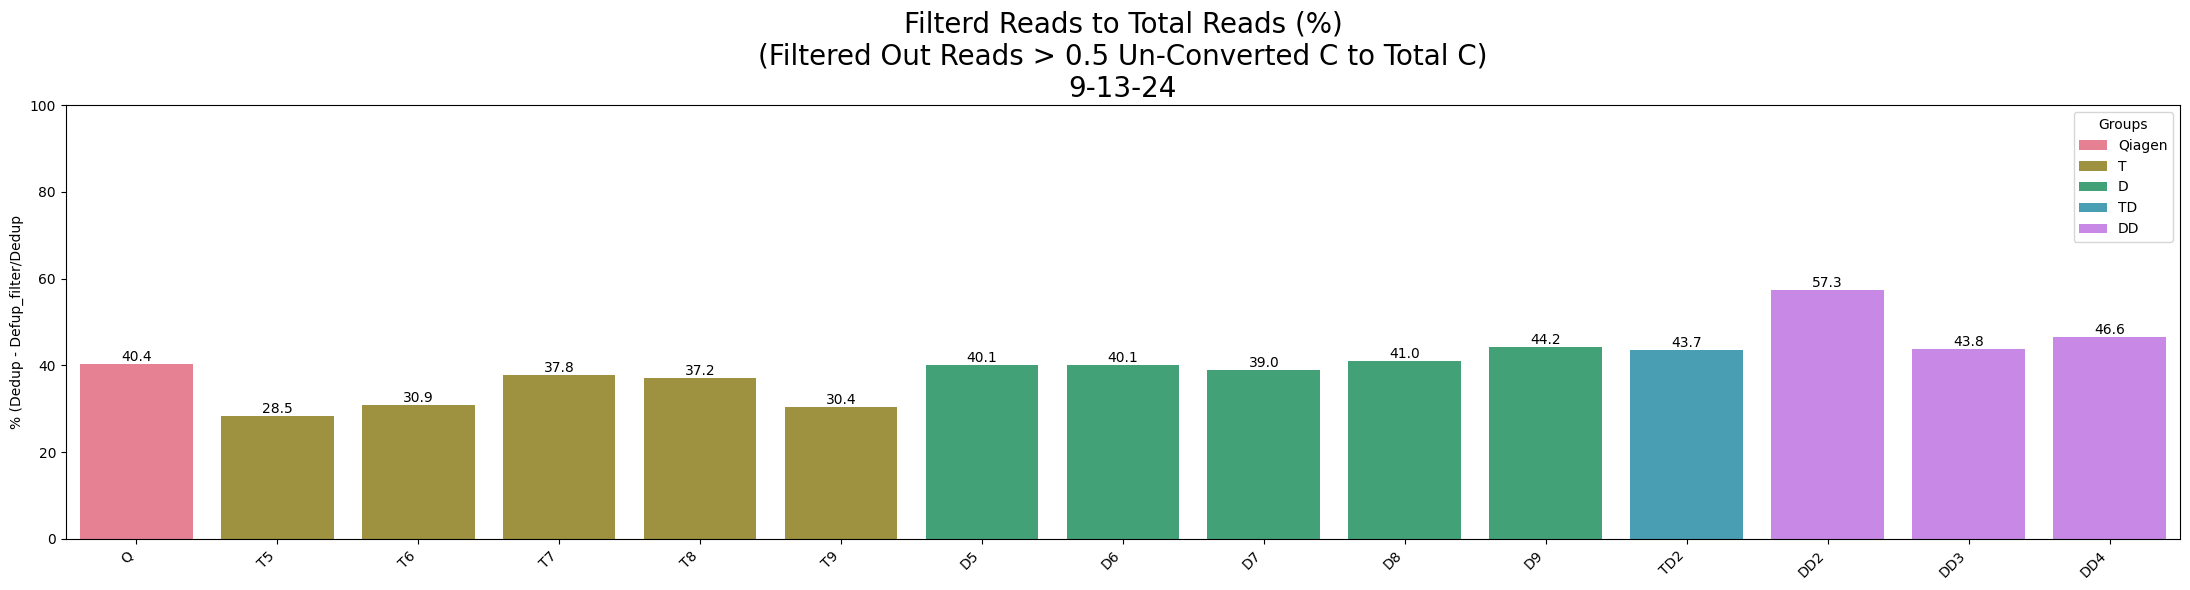

In [66]:
generate_bar_graph(df_prct, value_col='lambda', yrange=100, ylabel = '% (Dedup - Defup_filter/Dedup', 
                   title="Filterd Reads to Total Reads (%)\n(Filtered Out Reads > 0.5 Un-Converted C to Total C)\n9-13-24",
                   groups=sample_groups)

## Step: conv_unconv

#### Call conv_unconv

In [85]:
in_paths = mkpaths("dedup",refs)
out_paths = mkpaths("conv_unconv",refs)

>>> {dedup_pUC19} 00:47:10_10-16-2024
>>> {dedup_lambda} 00:47:10_10-16-2024
>>> {conv_unconv_pUC19} 00:47:10_10-16-2024
>>> {conv_unconv_lambda} 00:47:10_10-16-2024


#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -u -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T    |                  
    bgzip -@ {threads} -c > {output}
```

##### paramaters:
- --unique-only,   only count the base which is in uniquely mapped reads
- --multiple-only, only count the base which is in multiple mapped reads

In [86]:
for in_path, out_path in zip(in_paths, out_paths):
    ref = str(in_path).split('_')[-1]
    for sample in samples:
        !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
        hisat-3n-table\
            -p {nc}\
            --unique-only --alignments -\
            --ref {get_ref(ref,'fa')}\
            --output-name /dev/stdout\
            --base-change C,T                          |\
        bgzip \
            -@ {nc} \
            -c > {fname(out_path,sample,'tsv.gz')}

There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

Used IGV to look at reads in `t1.tsv.gz`:
- Needed to adjust preferences to show all reads
- Exactly the first 10,000 nt are all N
- The first read was aligned with a C at 10,358
- There were 9 C's, all in the positions shown above

## Step: conv_unconv_filter

#### Call conv_unconv Filtered

In [69]:
in_paths = mkpaths("dedup_filter",refs)
out_paths = mkpaths("conv_unconv_filter",refs)

>>> {dedup_filter_lambda} 00:01:26_09-26-2024
>>> {conv_unconv_filter_lambda} 00:01:26_09-26-2024


In [70]:
for in_path, out_path in zip(in_paths, out_paths):
    ref = str(in_path).split('_')[-1]
    for sample in samples:
        !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
        hisat-3n-table\
            -p {nc}\
            --unique-only --alignments -\
            --ref {get_ref(ref,'fa')}\
            --output-name /dev/stdout\
            --base-change C,T                          |\
        bgzip \
            -@ {nc} \
            -c > {fname(out_path,sample,'tsv.gz')}

## Step: ratio_conv_unconv

#### Calculate the Conversion and Unconversion Ratios

In [87]:
in_paths = mkpaths("conv_unconv",refs)
out_paths = mkpaths("ratio_conv_unconv",refs)

>>> {conv_unconv_pUC19} 00:57:47_10-16-2024
>>> {conv_unconv_lambda} 00:57:47_10-16-2024
>>> {ratio_conv_unconv_pUC19} 00:57:47_10-16-2024
>>> {ratio_conv_unconv_lambda} 00:57:47_10-16-2024


In [88]:
for in_path, out_path in zip(in_paths, out_paths):
    for sample in samples:
        header = "Sample\tChrom\tPos\tStrand\tConverted\tUnconverted\tDepth\tRatio_conv\tRatio_unconv"
        cmd = f"zcat {fname(in_path, sample, 'tsv.gz')} |\
            awk -v sample={sample} -v header='{header}' 'BEGIN{{FS=\"\\t\"; OFS=\"\\t\"}} NR==1 {{print header}} NR>1 {{print sample, $1, $2, $3, $5, $7, $7+$5, $5/($7+$5), $7/($7+$5)}}'|\
            bgzip -@ {nc}-c > {fname(out_path,sample,'tsv.gz')}"
        !{cmd}

#### Append Motif to sample.tsv.gz files

In [89]:
for in_path, out_path in zip(in_paths, out_paths):
    ref = str(in_path).split('_')[-1]
    fasta_ref = get_ref(ref,'fa')
    for sample in samples:
        if append_motif(fname(out_path,sample,'tsv.gz'), fname(out_path,sample +'_tmp','tsv.gz'),fasta_ref):
            os.rename(fname(out_path,sample +'_tmp','tsv.gz'), fname(out_path,sample,'tsv.gz'))

## Step: ratio_conv_unconv_filter

#### Calculate the Conversion and Unconversion Ratios for Filtered

In [74]:
in_paths = mkpaths("conv_unconv_filter",refs)
out_paths = mkpaths("ratio_conv_unconv_filter",refs)

>>> {conv_unconv_filter_lambda} 00:03:35_09-26-2024
>>> {ratio_conv_unconv_filter_lambda} 00:03:35_09-26-2024


In [75]:
for in_path, out_path in zip(in_paths, out_paths):
    for sample in samples:
        header = "Sample\tChrom\tPos\tStrand\tConverted\tUnconverted\tDepth\tRatio_conv\tRatio_unconv"
        cmd = f"zcat {fname(in_path, sample, 'tsv.gz')} |\
            awk -v sample={sample} -v header='{header}' 'BEGIN{{FS=\"\\t\"; OFS=\"\\t\"}} NR==1 {{print header}} NR>1 {{print sample, $1, $2, $3, $5, $7, $7+$5, $5/($7+$5), $7/($7+$5)}}'|\
            bgzip -@ {nc}-c > {fname(out_path,sample,'tsv.gz')}"
        !{cmd}

#### Append Motif to sample.tsv.gz files

In [76]:
for in_path, out_path in zip(in_paths, out_paths):
    ref = str(in_path).split('_')[-1]
    fasta_ref = get_ref(ref,'fa')
    for sample in samples:
        if append_motif(fname(out_path,sample,'tsv.gz'), fname(out_path,sample +'_tmp','tsv.gz'),fasta_ref):
            os.rename(fname(out_path,sample +'_tmp','tsv.gz'), fname(out_path,sample,'tsv.gz'))

## Step: figure_mapping_ratio

#### Calcuate Aligned (Mapped) to Trimmed Ratio

In [90]:
in_path  = mkpath("trim")
in_paths = mkpaths("map",refs)
out_path = mkpath("figures")

>>> {trim} 01:09:56_10-16-2024
>>> {map_pUC19} 01:09:56_10-16-2024
>>> {map_lambda} 01:09:56_10-16-2024
>>> {figures} 01:09:56_10-16-2024


In [91]:
df_trs = get_read_counts(in_path)
df_als = get_read_counts(in_paths).assign(align = lambda x: x.drop('SampleID',axis=1).sum(axis=1))[['SampleID','align']]
df_map = reorder_df(df_trs.merge(df_als).assign(ratio = lambda x: 100*x['align']/x['trim'])[['SampleID','ratio']],samples)
df_map.head()

SampleID      ratio
0       ST  98.274035
1       A1  98.770621
2       A2  98.807494
3       A3  98.753490
4       A4  98.728531

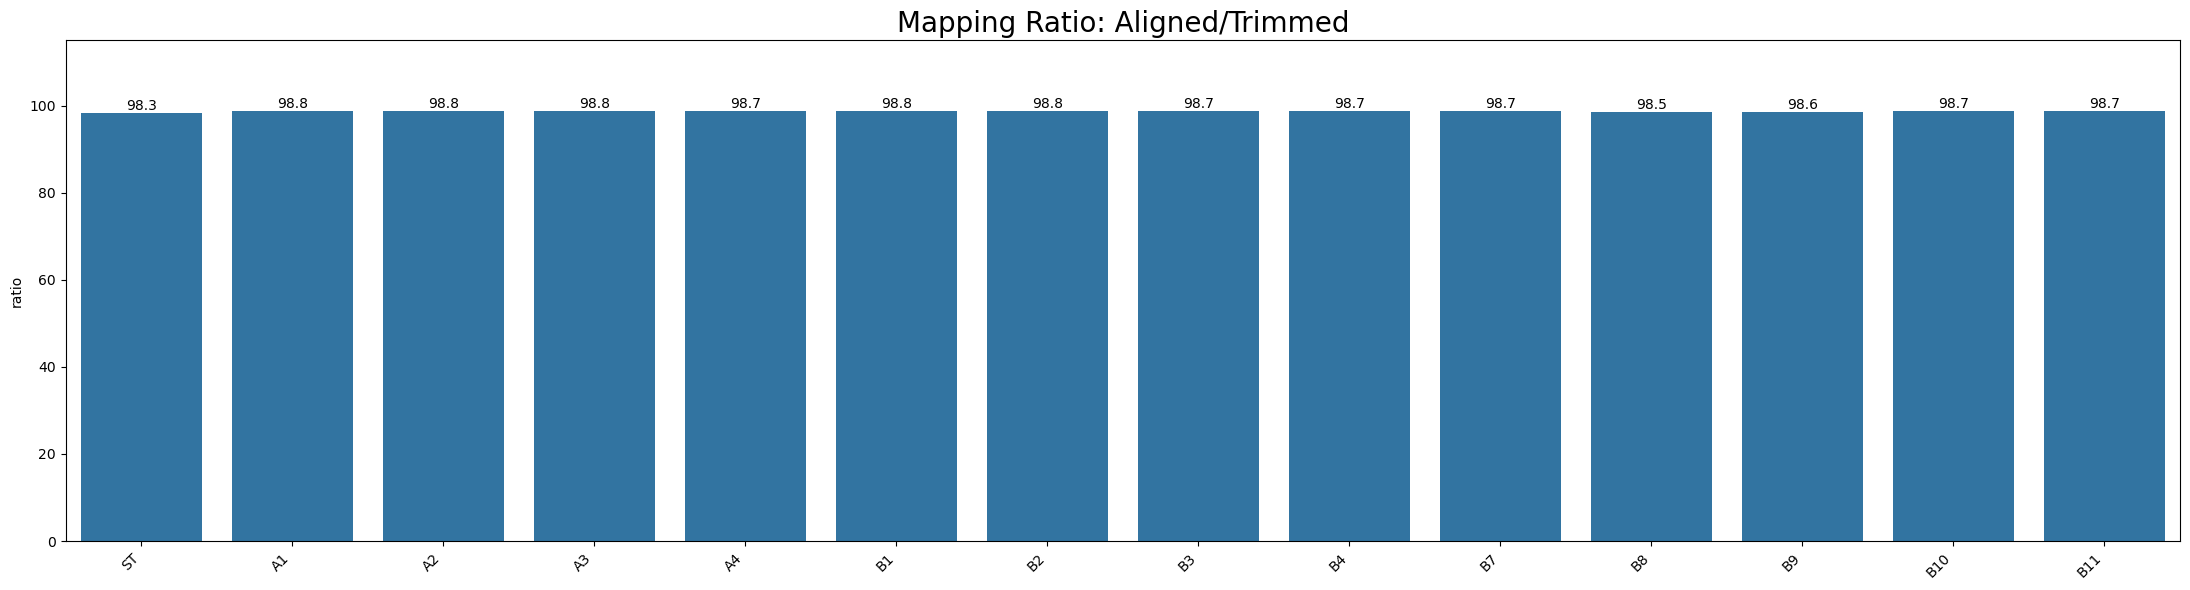

In [92]:
generate_bar_graph(df_map, label_col='SampleID', value_col='ratio', yrange=115, 
                   title="Mapping Ratio: Aligned/Trimmed")

## Step: figure_read_counts

#### Compare Reads for Original Samples, Trimmed Reads and Deduped Reads 

In [93]:
in_path_sam  = mkpath("samples")
in_path_trs  = mkpath("trim")
in_paths_als = mkpaths("map",refs)
in_paths_ded = mkpaths("dedup",refs)
out_path     = mkpath("figures")

>>> {samples} 01:10:23_10-16-2024
>>> {trim} 01:10:23_10-16-2024
>>> {map_pUC19} 01:10:23_10-16-2024
>>> {map_lambda} 01:10:23_10-16-2024
>>> {dedup_pUC19} 01:10:23_10-16-2024
>>> {dedup_lambda} 01:10:23_10-16-2024
>>> {figures} 01:10:23_10-16-2024


In [94]:
df_sam = get_read_counts(in_path_sam)
df_trs = get_read_counts(in_path_trs)
df_als = get_read_counts(in_paths_als).assign(align = lambda x: x.drop('SampleID',axis=1).sum(axis=1))[['SampleID','align']]
df_ded = get_read_counts(in_paths_ded).assign(dedup = lambda x: x.drop('SampleID',axis=1).sum(axis=1))[['SampleID','dedup']]
df_counts = reorder_df(df_sam.merge(df_trs).merge(df_als).merge(df_ded),samples)
df_counts.head()

SampleID   samples      trim     align    dedup
0       ST  17933710  17609456  17305523  4000236
1       A1  12132453  12062594  11914299  1797442
2       A2  11925916  11858226  11716816  1778607
3       A3  11956823  11886703  11738534  1723515
4       A4   9402309   9352173   9233263  1541619

In [95]:
def plot_read_counts_bar_graph(df):
    df = df.set_index('SampleID').loc[samples].reset_index()
    data_columns = [col for col in df.columns if col != 'SampleID']

    colors = sns.color_palette("husl", len(data_columns))
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(22, 6))
    x = range(len(df['SampleID']))
    
    bars = []
    for i, col in enumerate(data_columns):
        bars.append(ax.bar(x, df[col], label=col.capitalize(), color=colors[i]))
    
    ax.set_ylabel('Read Count')
    ax.set_title(f'{experiment_title}\nRead Counts',fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(df['SampleID'], rotation=45, ha='right')
    ax.legend()
    
    # Remove space on left and right sides
    ax.set_xlim(-0.5, len(x) - 0.5)
    
    plt.tight_layout()
    plt.savefig("figures/Read_Counts_Bar_Graph.png", bbox_inches='tight')
    plt.show()

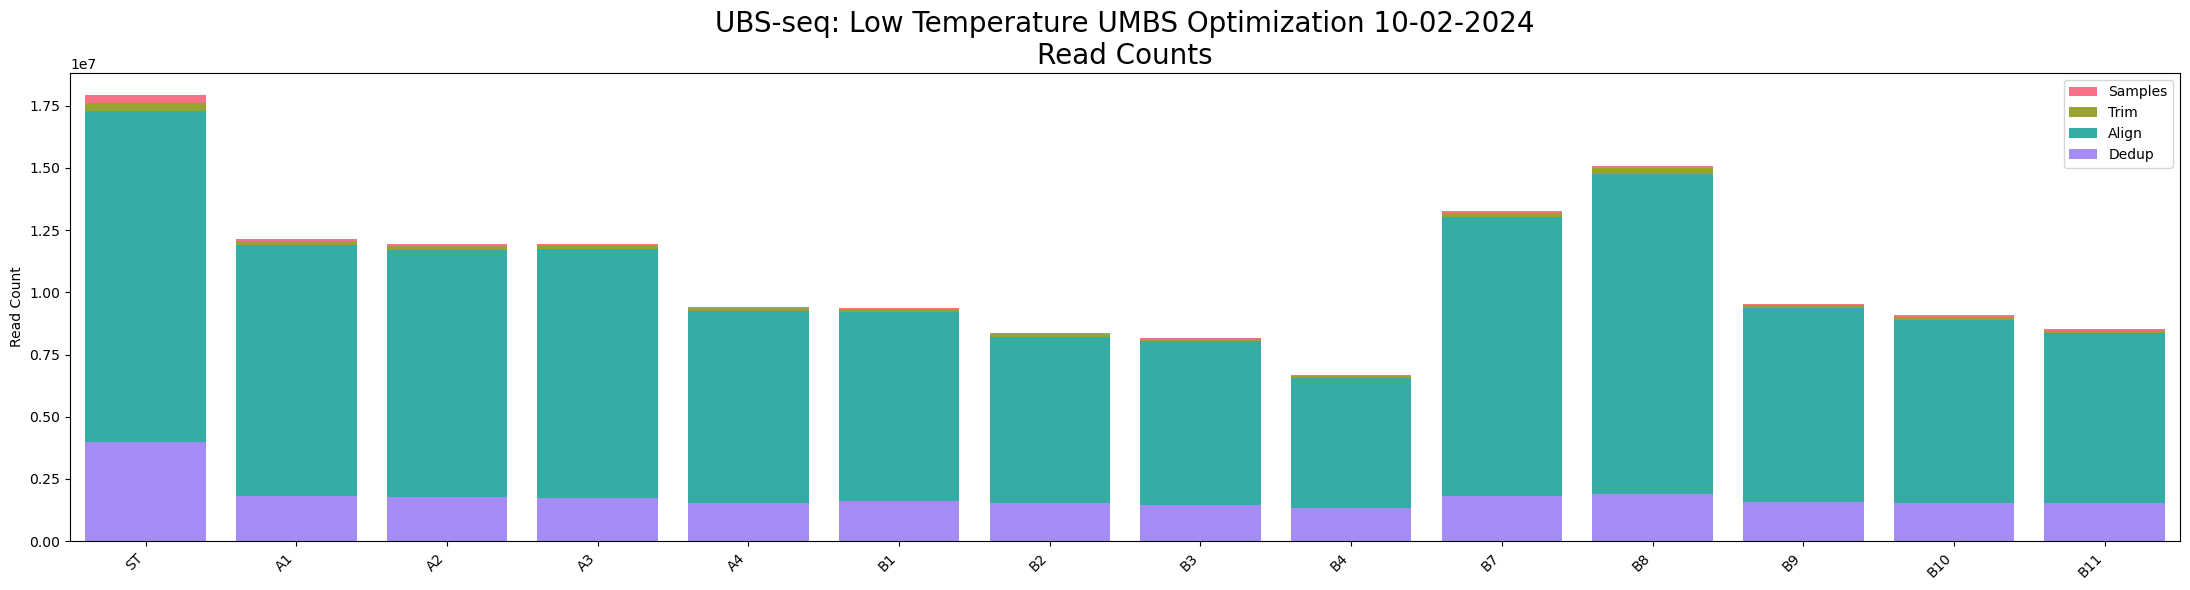

In [96]:
plot_read_counts_bar_graph(df_counts)

## Step: figures_insert_size

#### Calculate Read Length

In [130]:
in_paths = mkpaths("dedup",refs)
out_path = mkpath("figures")

>>> {dedup_pUC19} 02:05:34_10-16-2024
>>> {dedup_lambda} 02:05:34_10-16-2024
>>> {figures} 02:05:34_10-16-2024


In [98]:
def integrity_plot(path, sample, ax, ylim, xlim, s, binwidth=10, **kwargs):
    ref = str(path).split("_")[-1]
    df,x_mean = integrity(path,sample)
    experiment = f'{sample}: {sample2experiment[sample]}'
    xlabel = f'Fragment Size - {ref}'
    
    line = sns.histplot(data=df, x='Length', kde=False, stat='count', binwidth=binwidth, alpha=1, legend=None, ax=ax)
    ax.set_title(experiment, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    if ylim: ax.set_ylim(*ylim)
    if xlim: ax.set_xlim(*xlim)
    
    ax.grid(True)
    x_data = [p.get_x() + 0.5 * p.get_width() for p in line.patches]
    y_data = [p.get_height() for p in line.patches]
    max_index = np.argmax(y_data)
    peak_x, peak_y = x_data[max_index],y_data[max_index]
    ax.axvline(x=x_mean, color='red', linestyle='--', linewidth=1)
    ax.text(x_mean, 0.95 * ax.get_ylim()[1], f' {x_mean:.0f}', fontsize=10, color='red', ha='left', va='top')


def integrity(path, sample):
    samfile = pysam.AlignmentFile(fname(path, sample, "bam"), "rb")
    reads_dict, lengths = {}, []
    for read in samfile.fetch(until_eof=True):
        if read.is_proper_pair and not read.is_secondary:
            mate = reads_dict.pop(read.query_name, None)
            if mate:
                r1, r2 = (read, mate) if read.is_read1 else (mate, read)
                d = (r1.reference_end - r2.reference_start) if r1.is_reverse else (r2.reference_end - r1.reference_start)
                lengths.append(d)
            else:
                reads_dict[read.query_name] = read
    data_array = np.array(lengths)
    return pd.DataFrame({'Length': data_array}), np.median(data_array) #switched to median
    #return pd.DataFrame({'Length': data_array}), data_array.mean() 

#### Read Length 5mC164

In [ ]:
plot_all(in_paths['5mC164'], integrity_plot, figure_title='Read Length', ylim=(0,20))

#### Read Length pUC19

/tmp/ipykernel_847519/2686241114.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


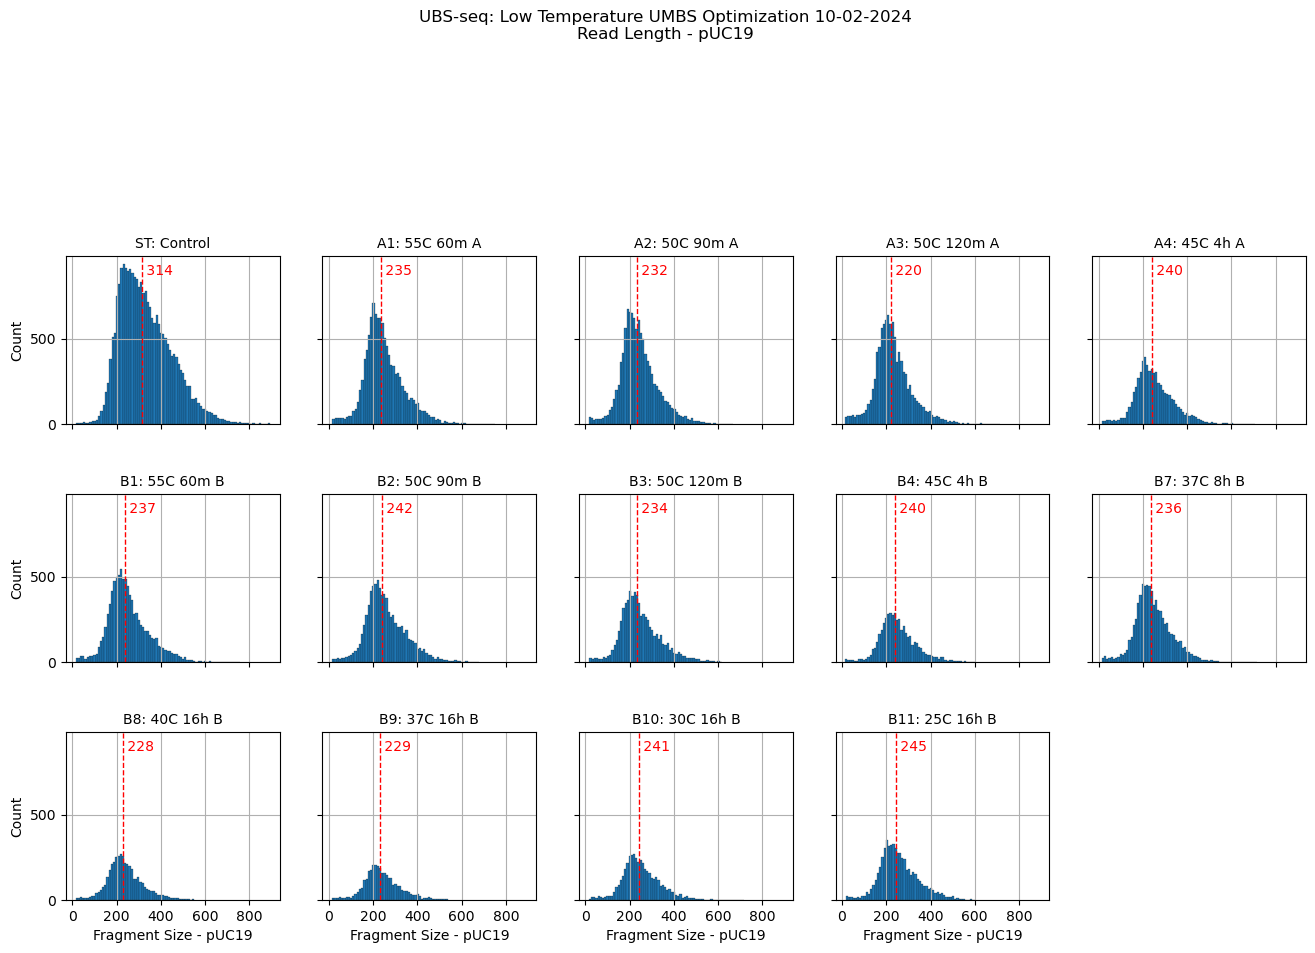

In [102]:
plot_all(in_paths['pUC19'], integrity_plot, figure_title='Read Length')

#### Read Length Lambda

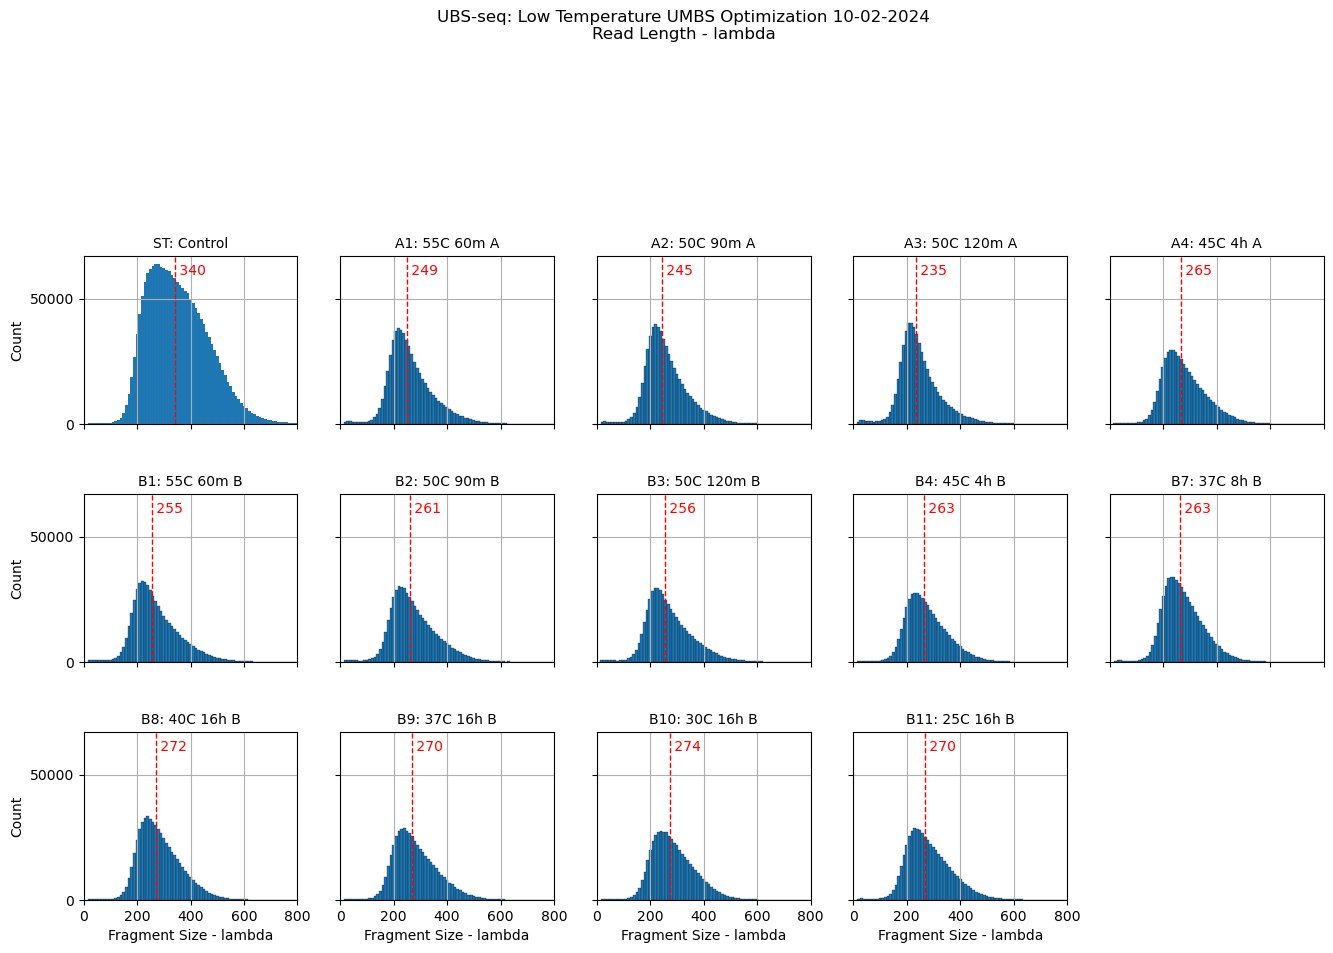

In [104]:
%%capture --no-display
plot_all(in_paths['lambda'], integrity_plot, figure_title='Read Length', xlim=(0,800))

#### Read Length 18SrRNA

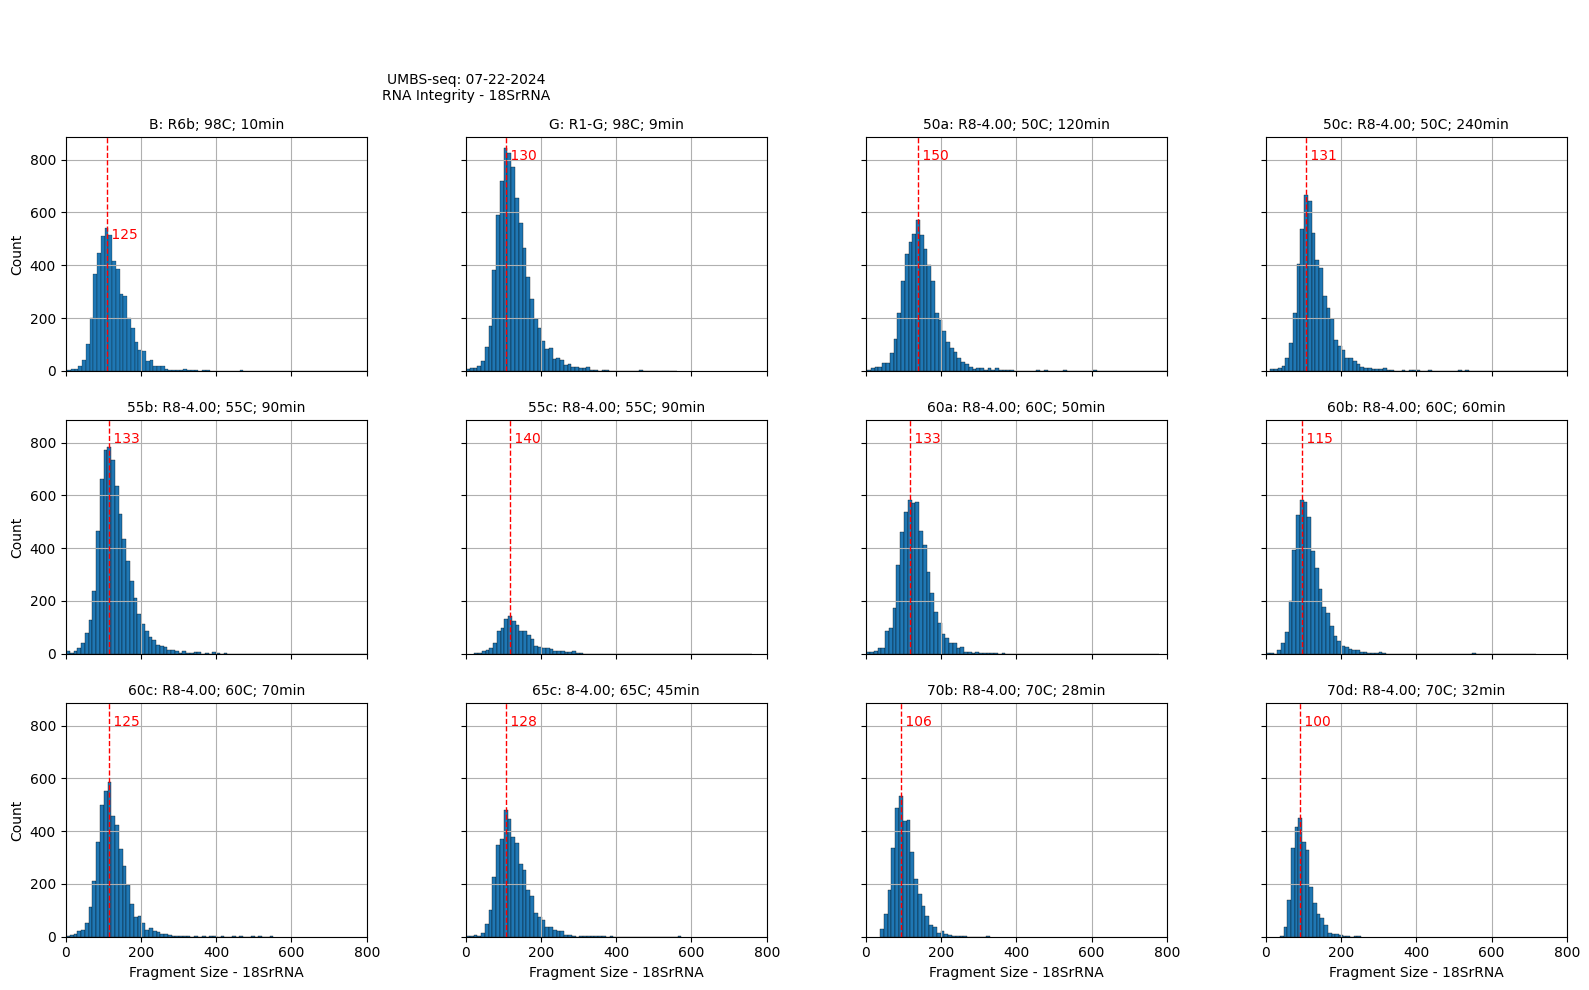

In [104]:
plot_all(in_paths['18SrRNA'], integrity_plot, figure_title='Read Length', xlim=(0,800))

#### Read Length 28SrRna

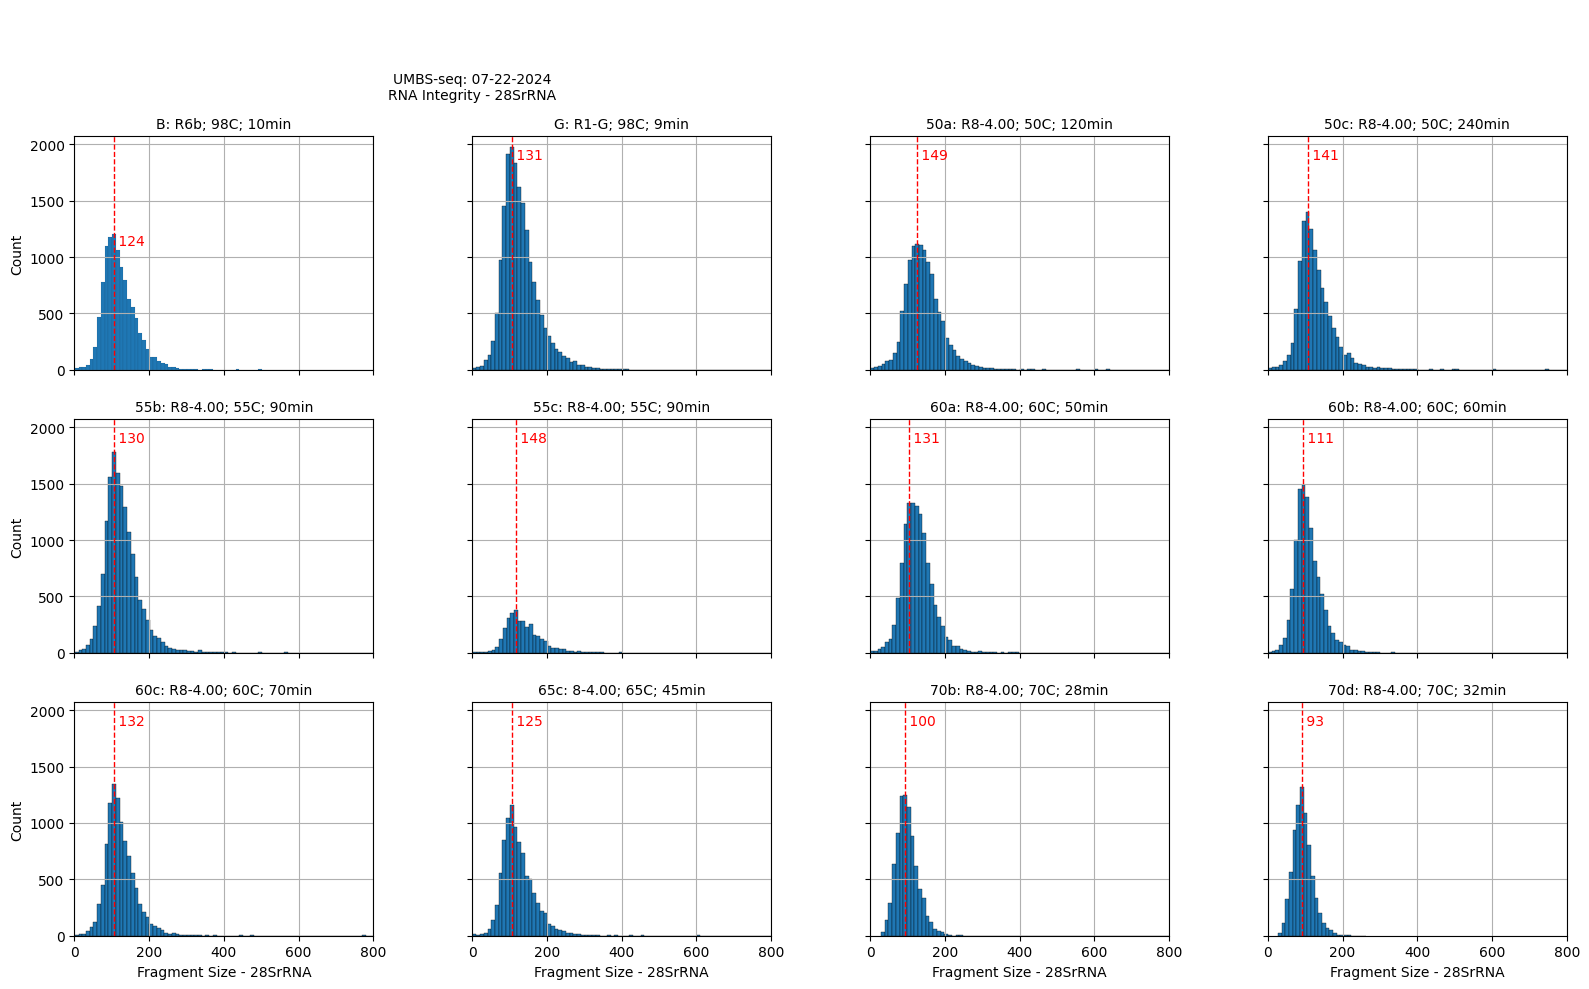

In [105]:
plot_all(in_paths['28SrRNA'], integrity_plot, figure_title='Read Length', xlim=(0,800))

#### Read Length cfDNA

In [ ]:
plot_all(in_paths['human'], integrity_plot, figure_title='Read Length', xlim=(0,700),binwidth=5)

## Step: figures_depth

#### Calculate Depth of Coverage

In [105]:
in_paths = mkpaths("map",refs)
out_path = mkpath("figures")

>>> {map_pUC19} 01:29:36_10-16-2024
>>> {map_lambda} 01:29:36_10-16-2024
>>> {figures} 01:29:36_10-16-2024


In [106]:
def depth_plot(path, sample, ax, ylim, xlim, s, xygrid=True, **kwargs):
    window_size = kwargs.get('window_size', None)  # set window_size for windowing of sample
    df = depth(path, sample, window_size)
    experiment = f'{sample}: {sample2experiment[sample]}'
    xlabel = f'Position - {str(path).split("_")[-1]}'
    sns.scatterplot(data=df, x='Pos', y='Depth', hue='Strand', palette=['blue', 'green'], edgecolor='none',
                    s=s, legend=None, ax=ax)
    ax.set_title(experiment, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Depth [log10]')
    ax.set_ylim(*ylim)
    ax.xaxis.set_major_formatter(adaptive_formatter(threshold=1e10))  # Use K,M,G on x-axis
    ax.grid(xygrid)

def depth(path, sample, window_size):    
    # -F 16 EXCLUDES reverse strand
    result = !samtools view -h -F 16 {fname(path,sample,"bam")} | samtools depth - 
    fwd = [list(map(int, s.split('\t')[1:])) for s in result]
    fwd = [[pos, np.log10(depth)] for pos, depth in fwd]
    
    # -f 16 INCLUDES reverse strand
    result = !samtools view -h -f 16 {fname(path,sample,"bam")} | samtools depth - 
    rev = [list(map(int, s.split('\t')[1:])) for s in result]
    rev = [[pos, np.log10(depth)] for pos, depth in rev]
    df = pd.DataFrame(fwd + rev, columns=['Pos', 'Depth'])
    df['Strand'] = ['Forward'] * len(fwd) + ['Reverse'] * len(rev)
    if window_size:
        df = windows_depth(df, window_size)
    return df

#### Depth 5mC164

/tmp/ipykernel_453956/2686241114.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


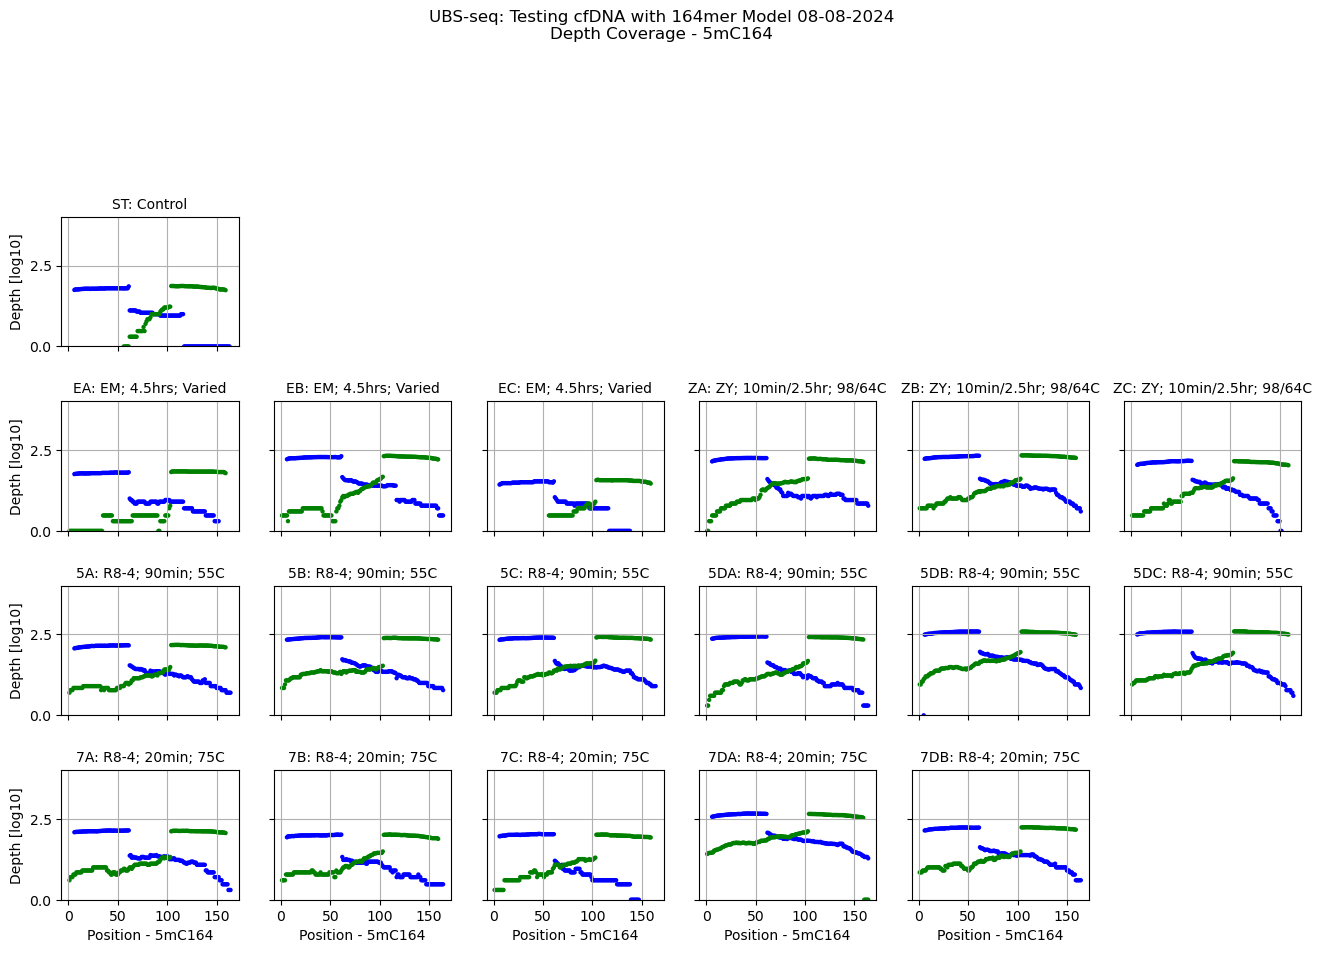

In [101]:
plot_all(in_paths['5mC164'], depth_plot, figure_title = 'Depth Coverage', ylim=(0,4),s=10)

#### Depth pUC19

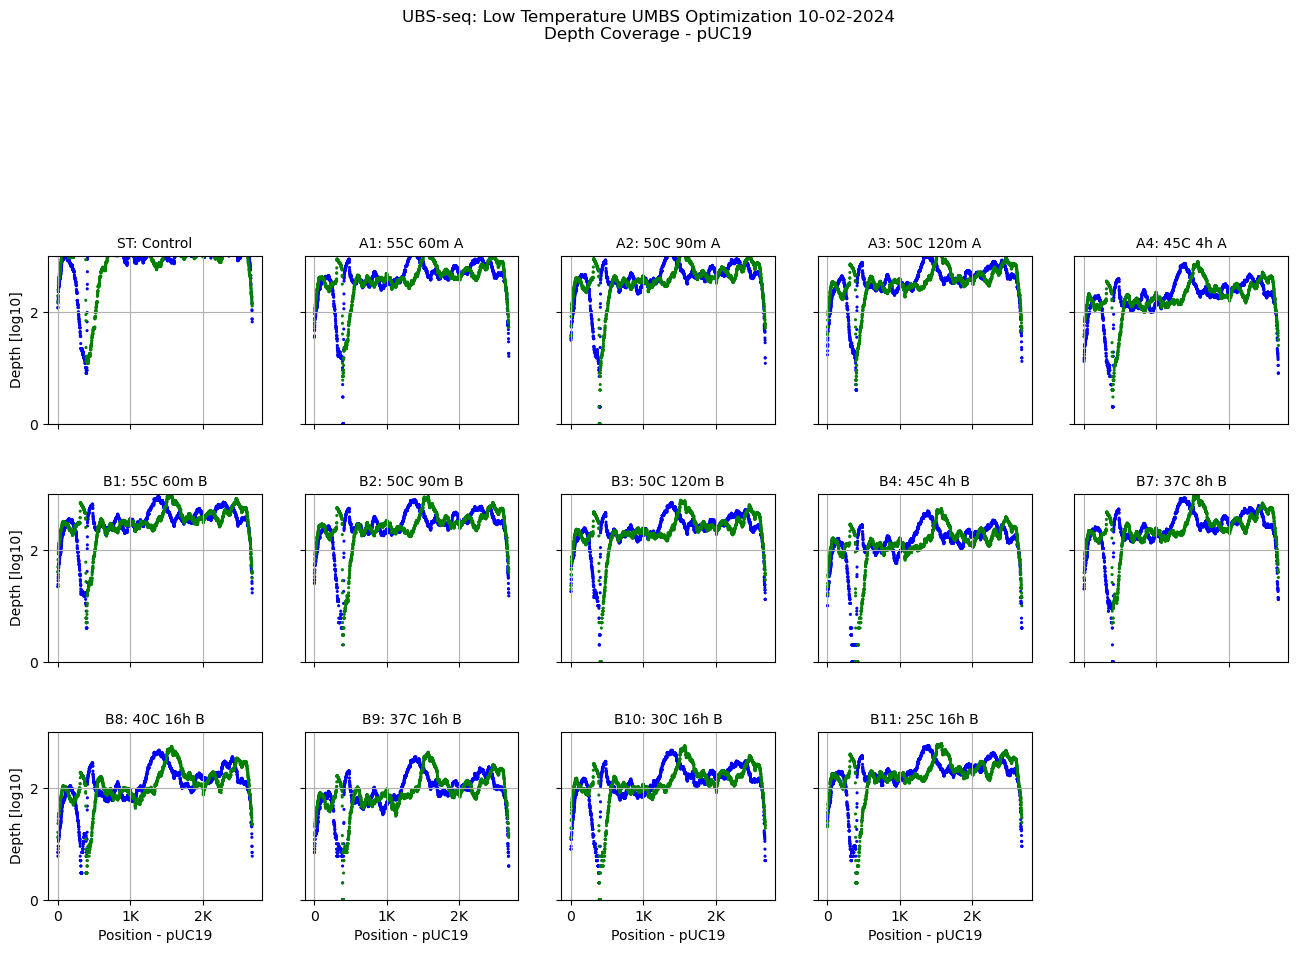

In [107]:
%%capture --no-display
plot_all(in_paths['pUC19'],depth_plot, figure_title = 'Depth Coverage', ylim=(0,3), s=5)

#### Depth lambda

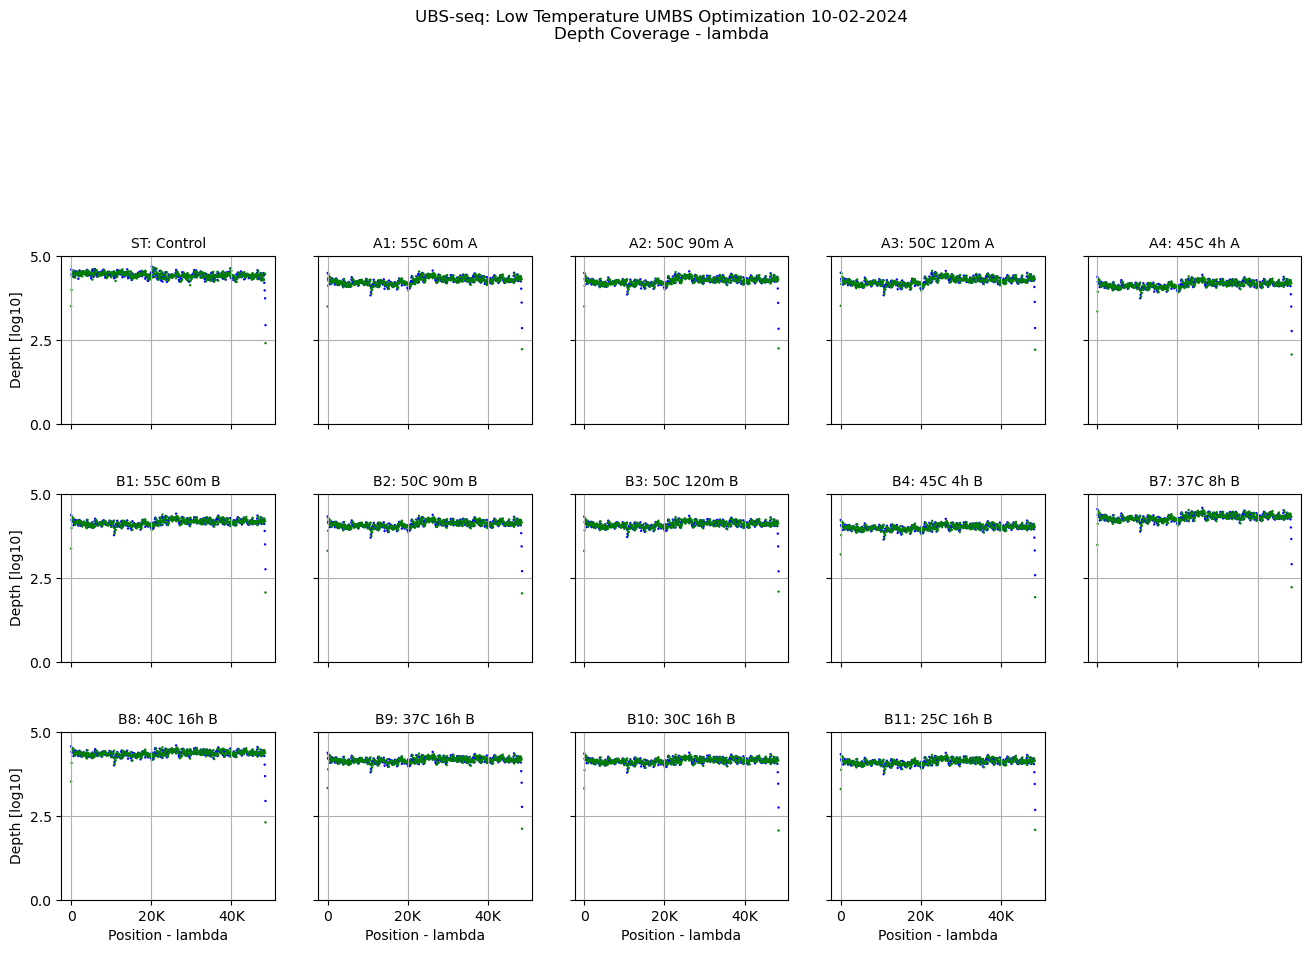

In [108]:
%%capture --no-display
plot_all(in_paths['lambda'],depth_plot, figure_title = 'Depth Coverage', ylim=(0,5), s=3, window_size=100)

#### Depth 18SrRNA

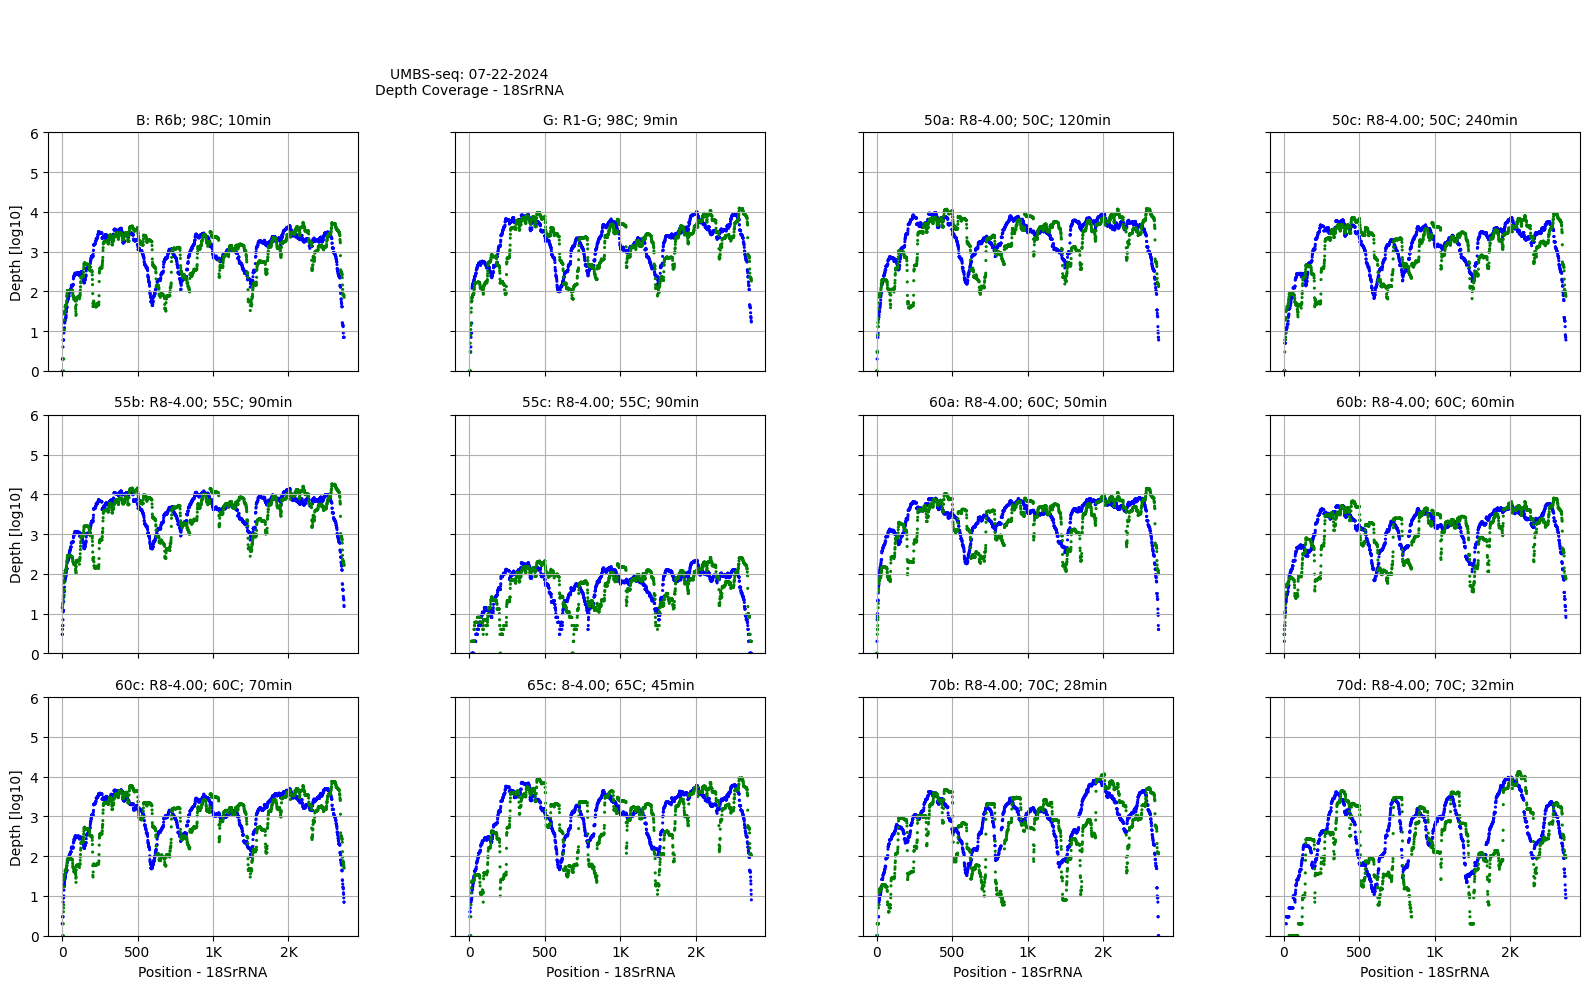

In [108]:
%%capture --no-display
plot_all(in_paths['18SrRNA'],depth_plot, figure_title = 'Depth Coverage', ylim=(0,6), s=5)

#### Depth 28SrRNA

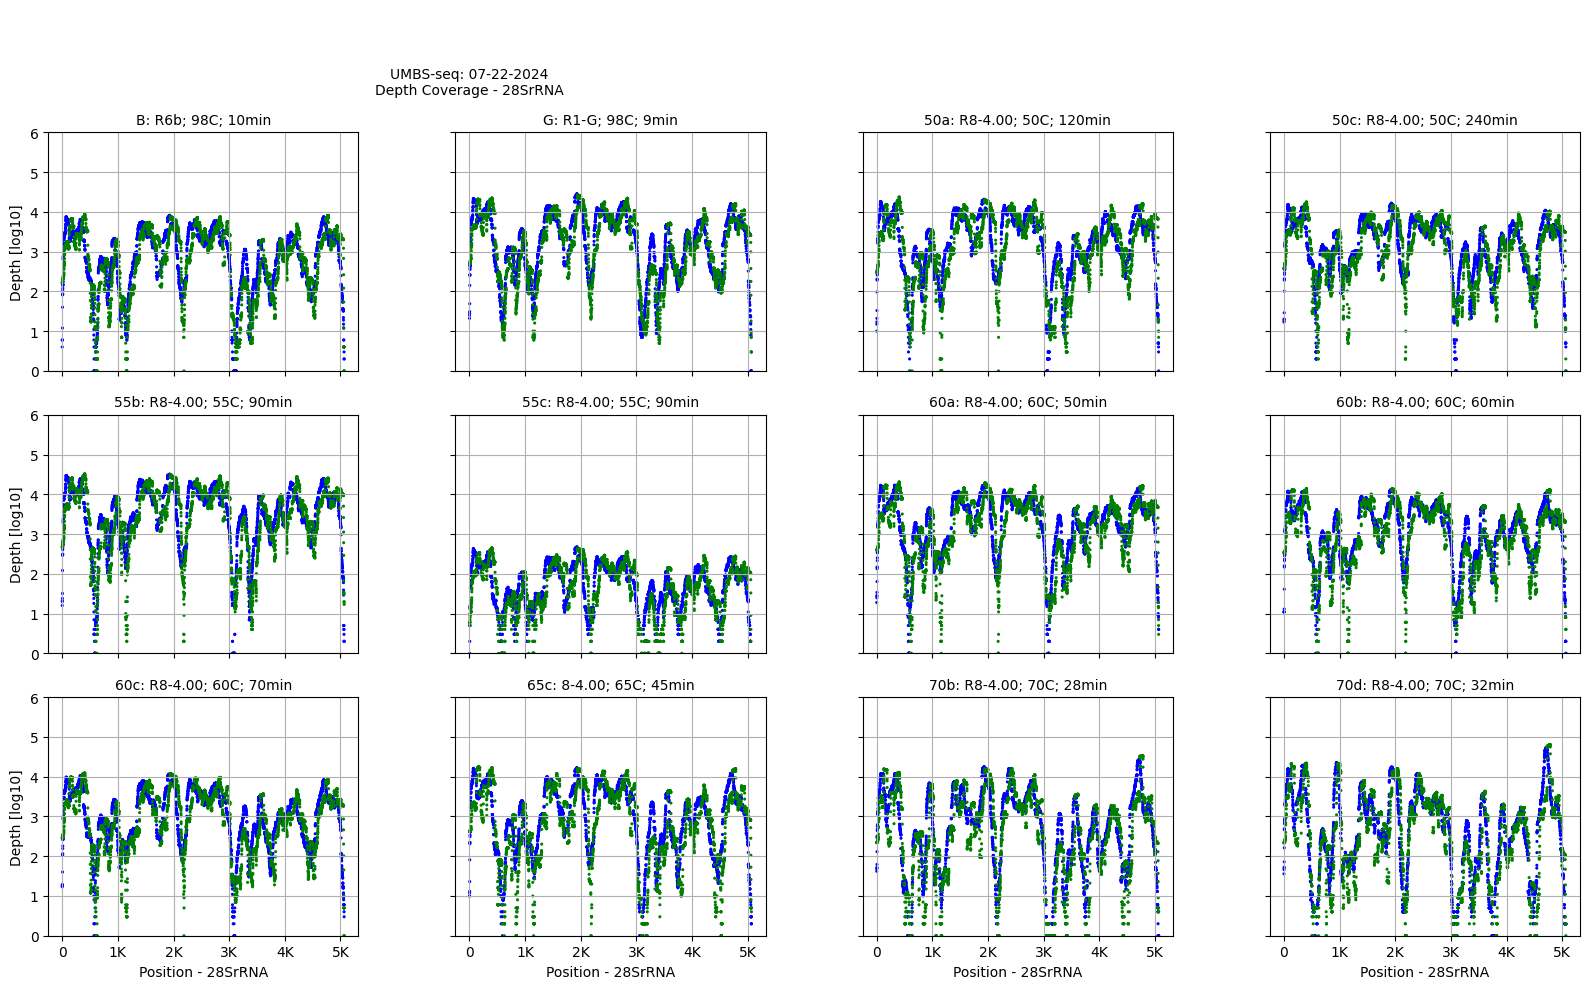

In [109]:
%%capture --no-display
plot_all(in_paths['28SrRNA'],depth_plot, figure_title = 'Depth Coverage', ylim=(0,6), s=5)

## Step: figures_conv_unconv

#### Create Conv_Unconv Ratio

In [114]:
in_paths = mkpaths("ratio_conv_unconv",refs)
out_path = mkpath("figures")

>>> {ratio_conv_unconv_pUC19} 01:48:17_10-16-2024
>>> {ratio_conv_unconv_lambda} 01:48:17_10-16-2024
>>> {figures} 01:48:17_10-16-2024


In [110]:
def conv_unconverted_plot(path, sample, ax, ylim, xlim, xygrid=True, ylabel=conv_unconv_y_label, s=5, **kwargs):
    every_nth, min_depth, palette = kwargs.get('every_nth',1), kwargs.get('min_depth',1), kwargs.get('palette',['blue','red'])
    aux_handle  = kwargs.get('aux_handle',None) # aux_file is passed to plot_all which passes down aux_handle
    window_size = kwargs.get('window_size',None)# set window_size for windowing of sample
    
    df, a5c, ac = conv_unconverted(path,sample, min_depth, every_nth, window_size, aux_handle)
    a5c,ac = round(a5c,2),round(ac,2)
    experiment = f'{sample}: {sample2experiment[sample]}'
    xlabel = f'Position - {str(path).split("_")[-1]}'
    
    sns.scatterplot(data=df, x='Pos', y='Ratio', hue='Meth', edgecolor='none', palette=palette, s=s, legend=None, ax=ax)

    title_1 = f'{experiment}'
    title_2_left = f'C = {ac}%  '
    title_2_right = f'5mC = {a5c}%'
    ax.text(0.5, 1.20, title_1, transform=ax.transAxes, ha='center', va='bottom', fontsize=9)
    if ac  > 0: ax.text(0.45, 1.02, title_2_left, transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color='blue')
    if a5c > 0: ax.text(0.50, 1.02, title_2_right, transform=ax.transAxes, ha='left', va='bottom', fontsize=9, color='red')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if ylim: ax.set_ylim(*ylim)
    if xlim: ax.set_xlim(*xlim)
    ax.xaxis.set_major_formatter(adaptive_formatter(threshold=1e10)) # Use K,M,G on x-axis
    ax.grid(False) if not xygrid else ax.grid(True)
    
    # NOTE: THESE LINES HAVE BEEN BLOCKED OUT ON A TEMP BASIS
    if a5c > 0: ax.axhline(y=a5c, color='red', linestyle='--', linewidth=1) 
    if ac > 0 : ax.axhline(y=ac, color='blue', linestyle='--', linewidth=1)

def conv_unconverted(path, sample, min_depth, every_nth, window_size, aux_handle=None):
    ref = str(path).split('_')[-1]
    df = pd.read_csv(fname(path, sample, 'tsv.gz'), sep='\t')
    df = df[df.Depth >= min_depth]
    if window_size:
        windows = windows_unconverted if exp_type == 'UBS-seq' else windows_converted
        df = windows(df, window_size)
        df['Meth'] = 0
        df['Ratio'] *= 100
        a5c = 0 if exp_type == 'UBS-seq' else df['Ratio'].mean()
        ac  = df['Ratio'].mean() if exp_type == 'UBS-seq' else 0
        if aux_handle: print(f'{ref},{sample},{ac},{a5c}', file=aux_handle)
        return df, a5c, ac
        
    df.index = np.arange(1, len(df) + 1)
    df = df[['Pos', ratio_conv_unconv, 'Depth']].rename(columns={ratio_conv_unconv: 'Ratio'})
    df = df.iloc[::every_nth]
    #df = df[df.Depth >= min_depth]
    df['Ratio'] *= 100
    df['Meth'] = 0
    meths = set(df.Pos).intersection(refs_meth[ref])
    df.loc[df['Pos'].isin(meths), 'Meth'] = 1
    t5c,tc = df[df.Meth == 1]['Ratio'], df[df.Meth == 0]['Ratio']
    a5c = t5c.mean() if not t5c.empty else 0
    ac = tc.mean() if not tc.empty else 0
    if aux_handle: print(f'{ref},{sample},{ac},{a5c}', file=aux_handle)    
    return df, a5c, ac

#### Converted Ratio 5mC164

In [112]:
%%capture --no-display
plot_all(in_paths['5mC164'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nUn-Filtered\nDepth ≥ 10', min_depth=10,
         s=5, every_nth = 1,  ylim=(0,105))

#### Converted Ratio pUC19

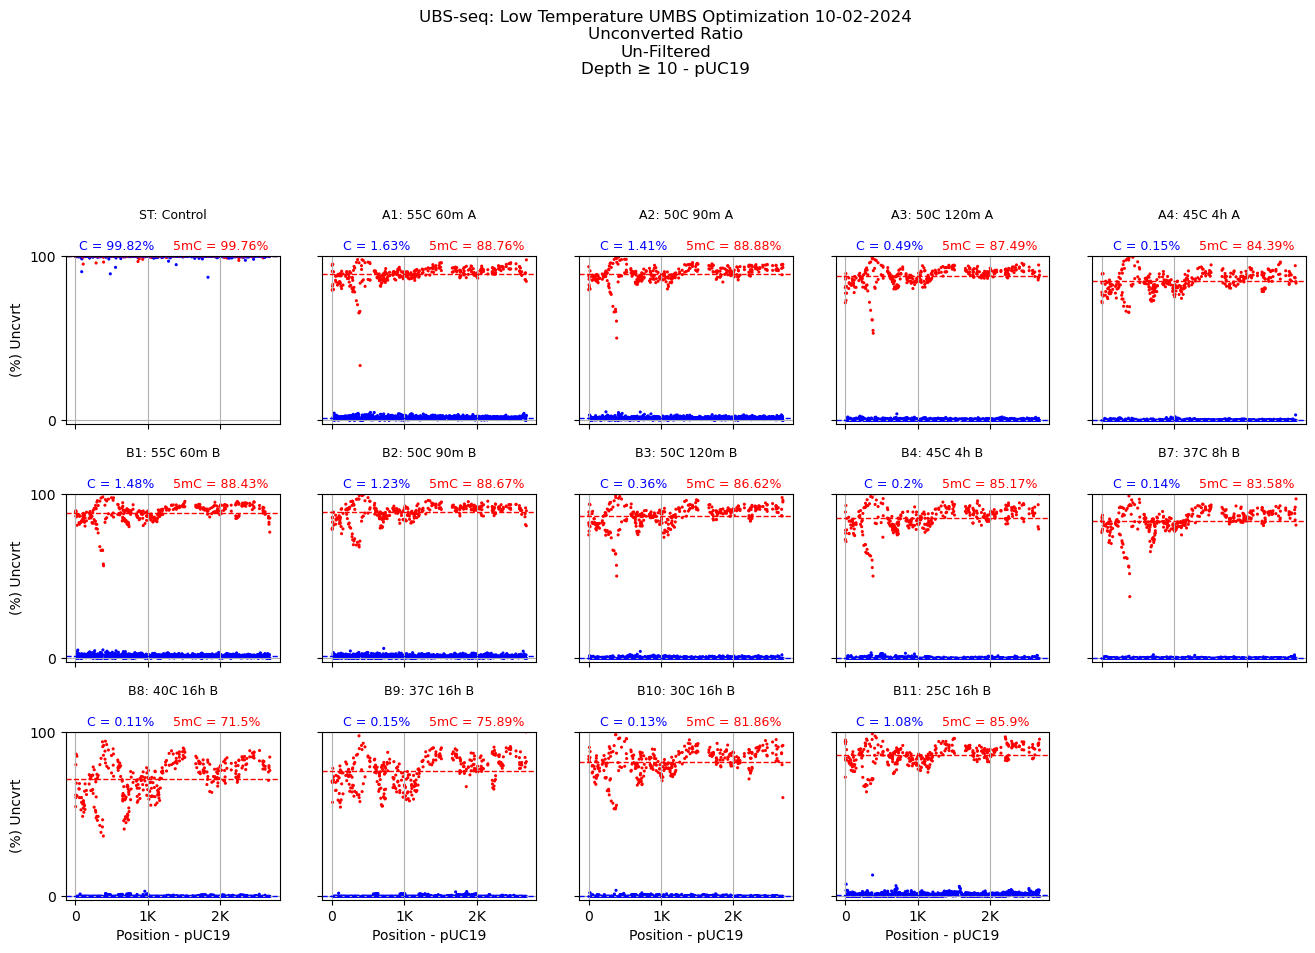

In [113]:
%%capture --no-display
plot_all(in_paths['pUC19'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nUn-Filtered\nDepth ≥ 10', min_depth = 10,
         s=5, every_nth=1, ylim=(-2,100),
         aux_fname=fname(out_path,f'avg_pUC19','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio lambda

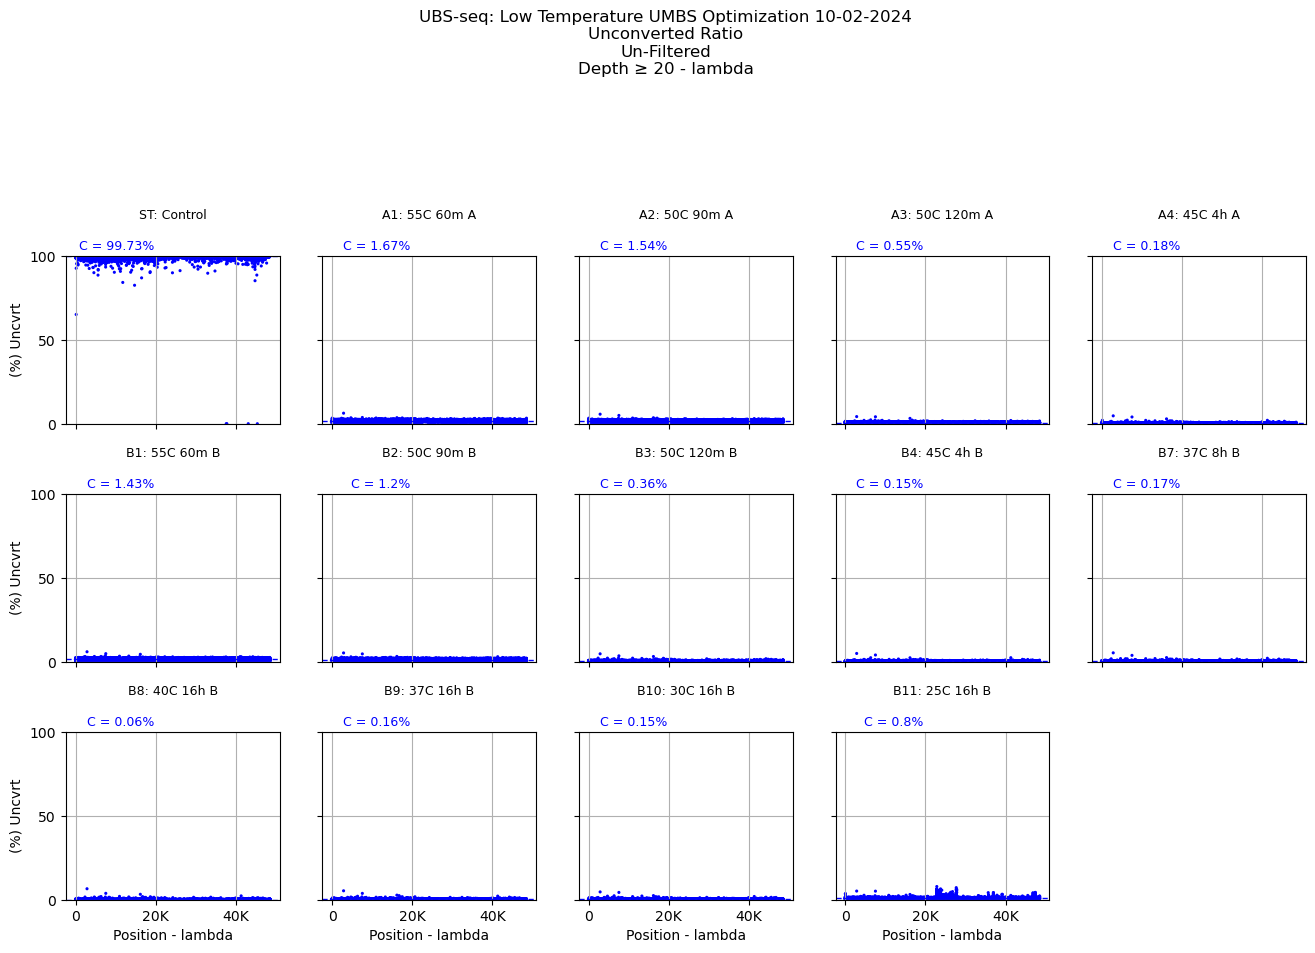

In [115]:
%%capture --no-display
plot_all(in_paths['lambda'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nUn-Filtered\nDepth ≥ 20', min_depth = 20,
         s=5, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_lambda','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio human

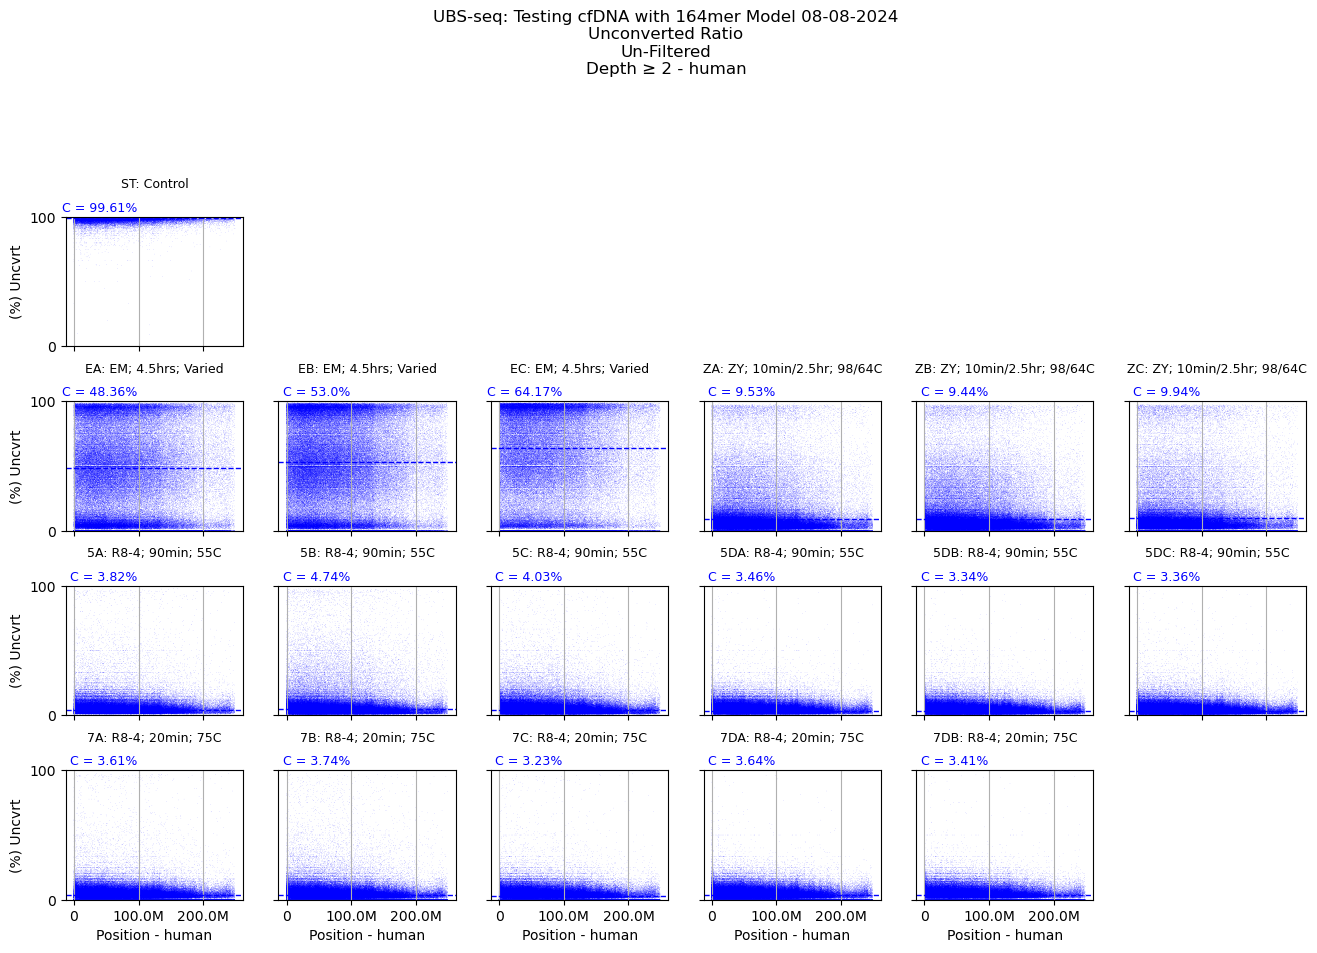

In [134]:
%%capture --no-display
plot_all(in_paths['human'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nUn-Filtered\nDepth ≥ 2', min_depth = 2,
         s=.05, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_human','csv'), aux_header='ref,SampleID,ac,a5c', window_size=10_000)

#### Converted Ratio Human Mitochondria (MT)

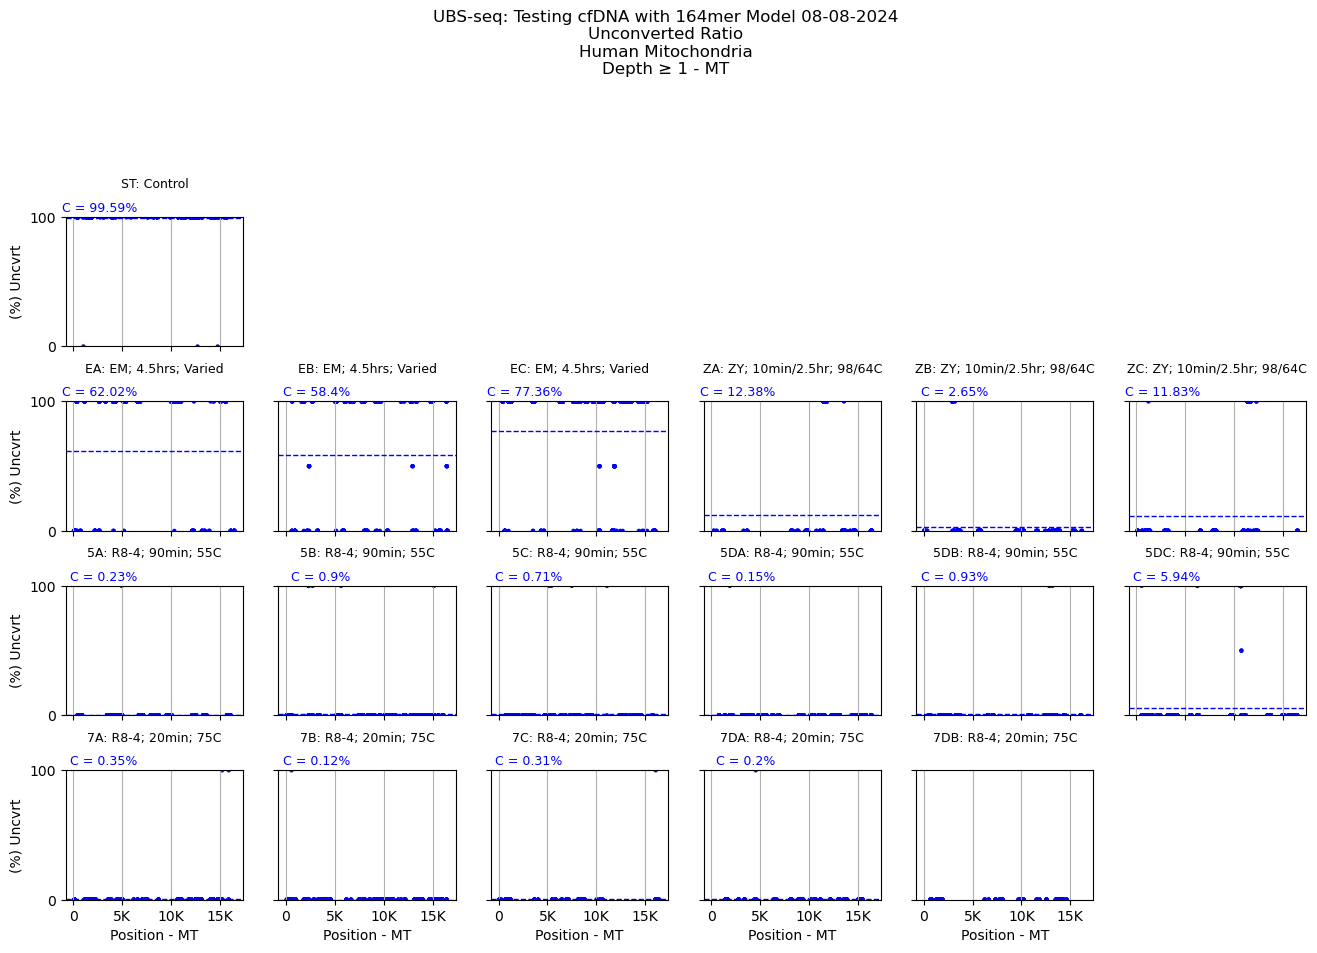

In [118]:
%%capture --no-display
plot_all(in_paths['MT'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nHuman Mitochondria\nDepth ≥ 1',
         s=10, min_depth = 1, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_human_MT','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio Human X

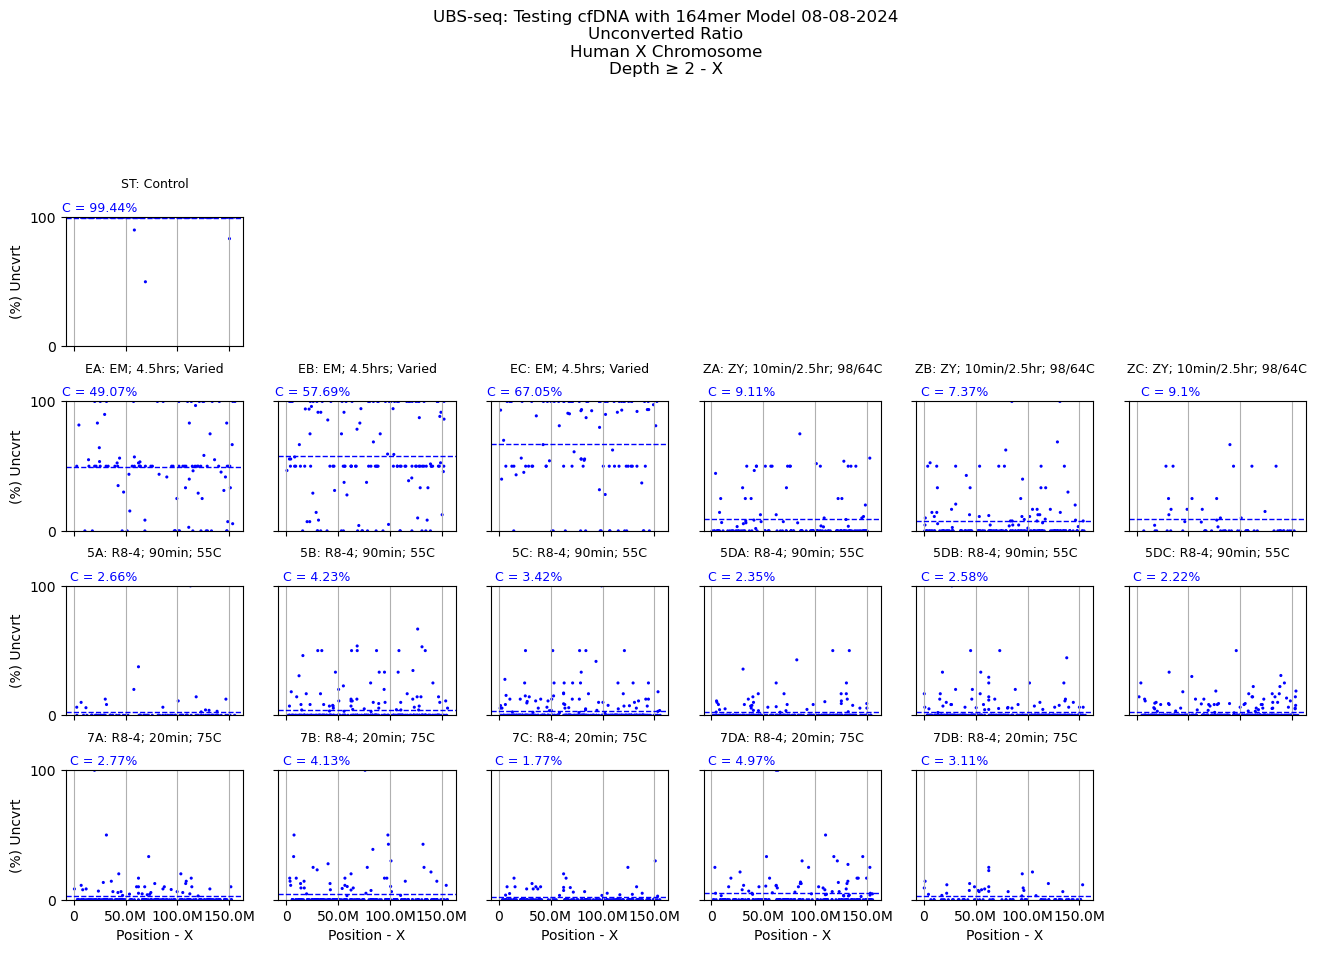

In [119]:
%%capture --no-display
plot_all(in_paths['X'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nHuman X Chromosome\nDepth ≥ 2',
         s=5, min_depth = 2, every_nth = 1, ylim=(0,100), window_size=10000,
        aux_fname=fname(out_path,f'avg_human_X','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio Human 1

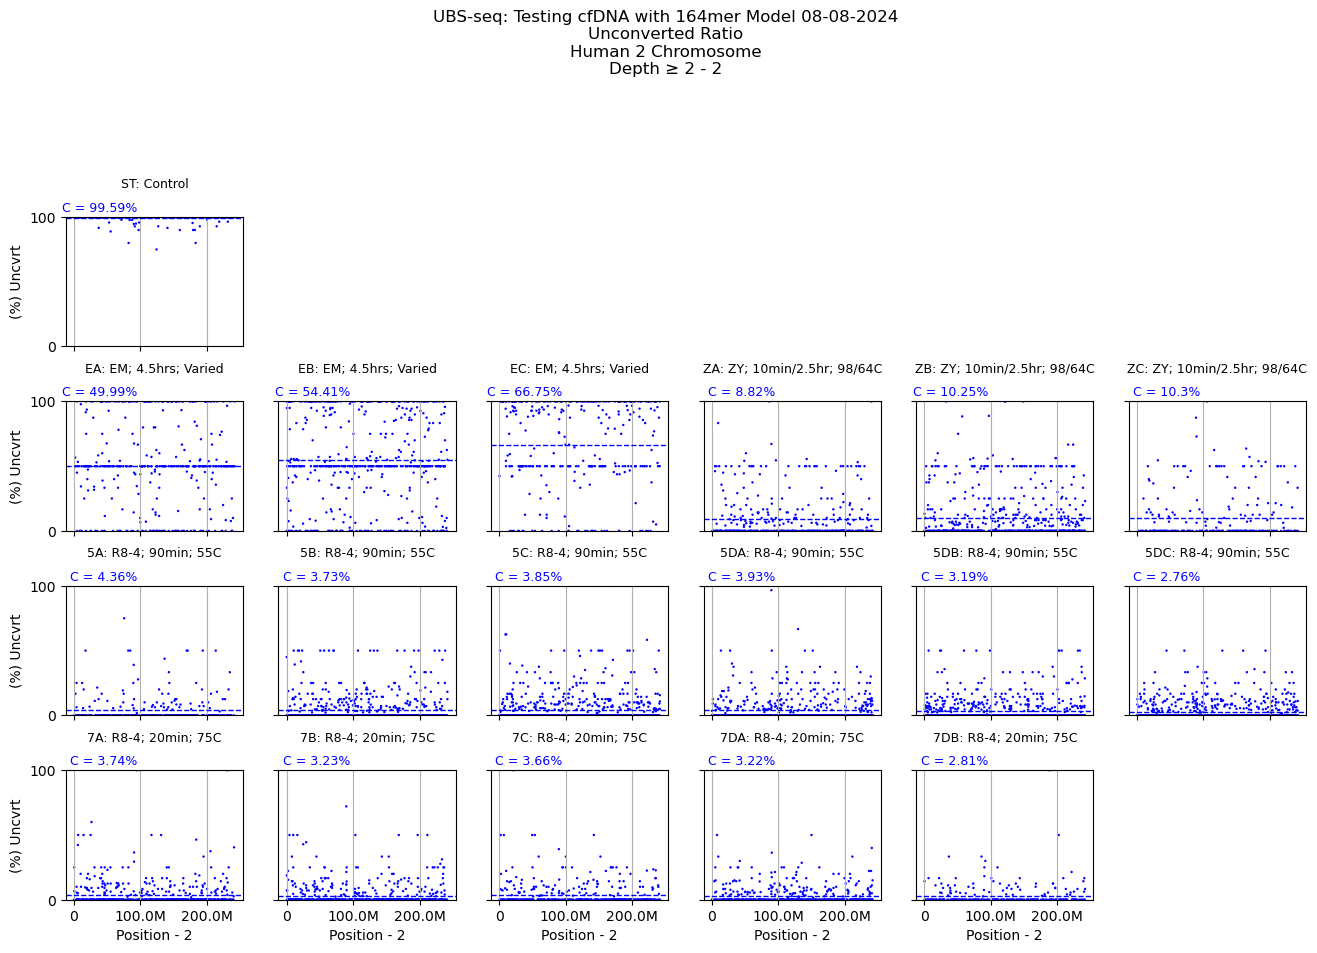

In [121]:
%%capture --no-display
plot_all(in_paths['2'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nHuman 2 Chromosome\nDepth ≥ 2',
         s=3, min_depth = 2, every_nth = 1, ylim=(0,100),window_size=10000,
        aux_fname=fname(out_path,f'avg_human_2','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio 18SrRNA

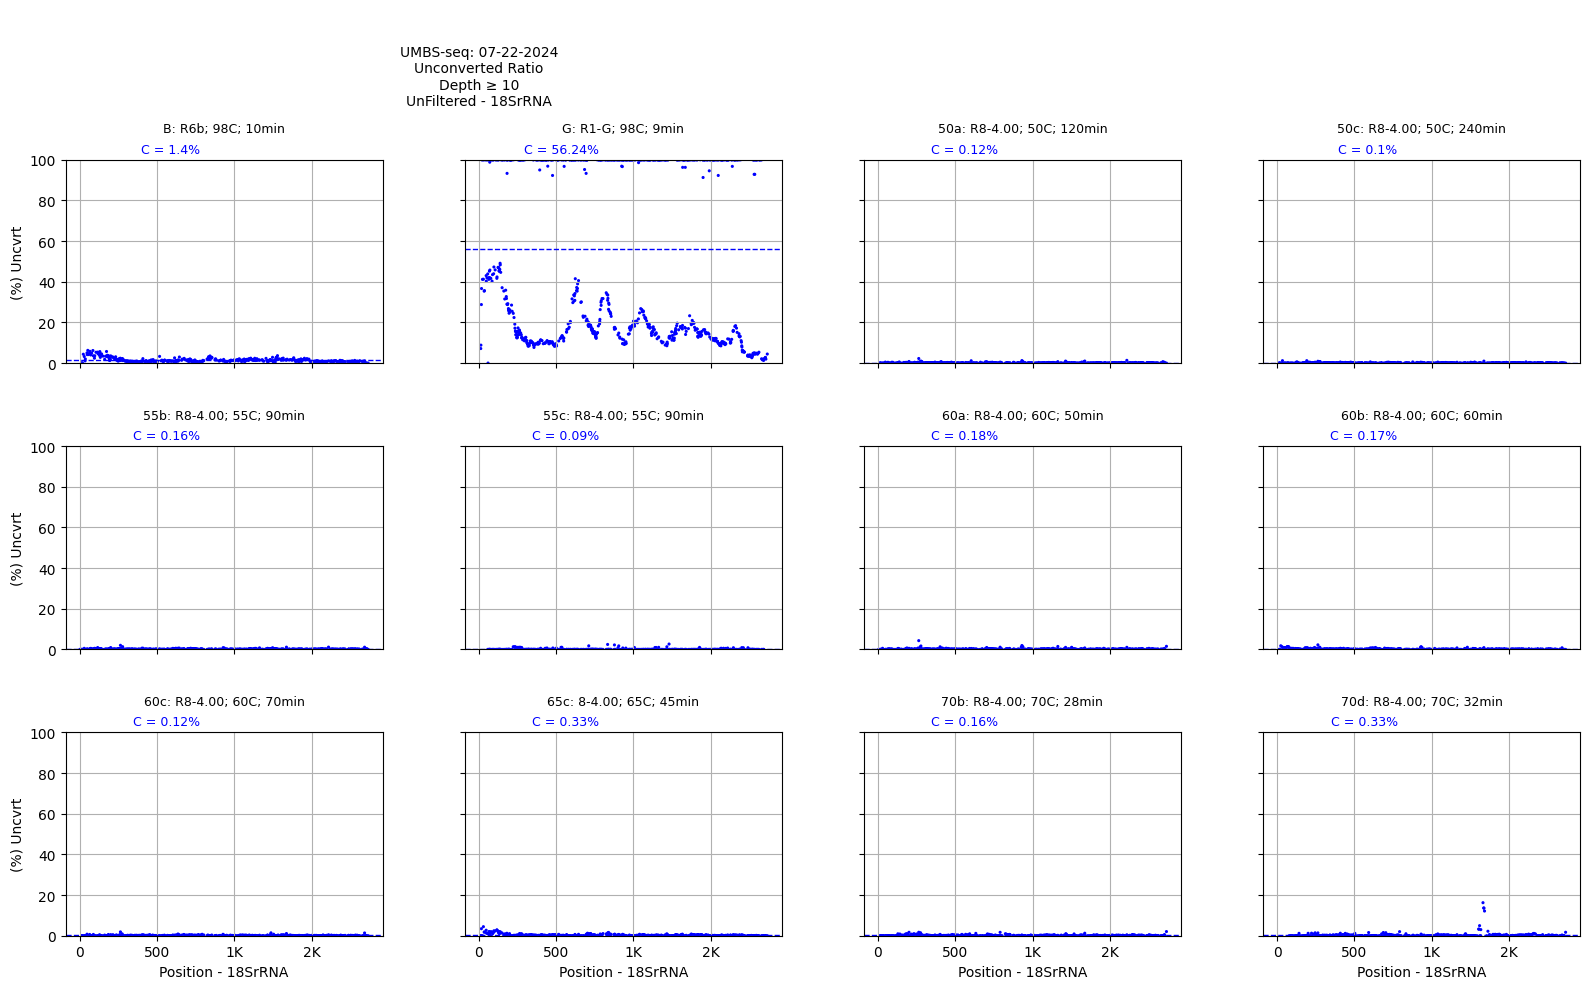

In [119]:
%%capture --no-display
plot_all(in_paths['18SrRNA'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nUn-Filtered\nDepth ≥ 10',
         s=5, min_depth = 10, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_18srRNA','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio 28SrRNA

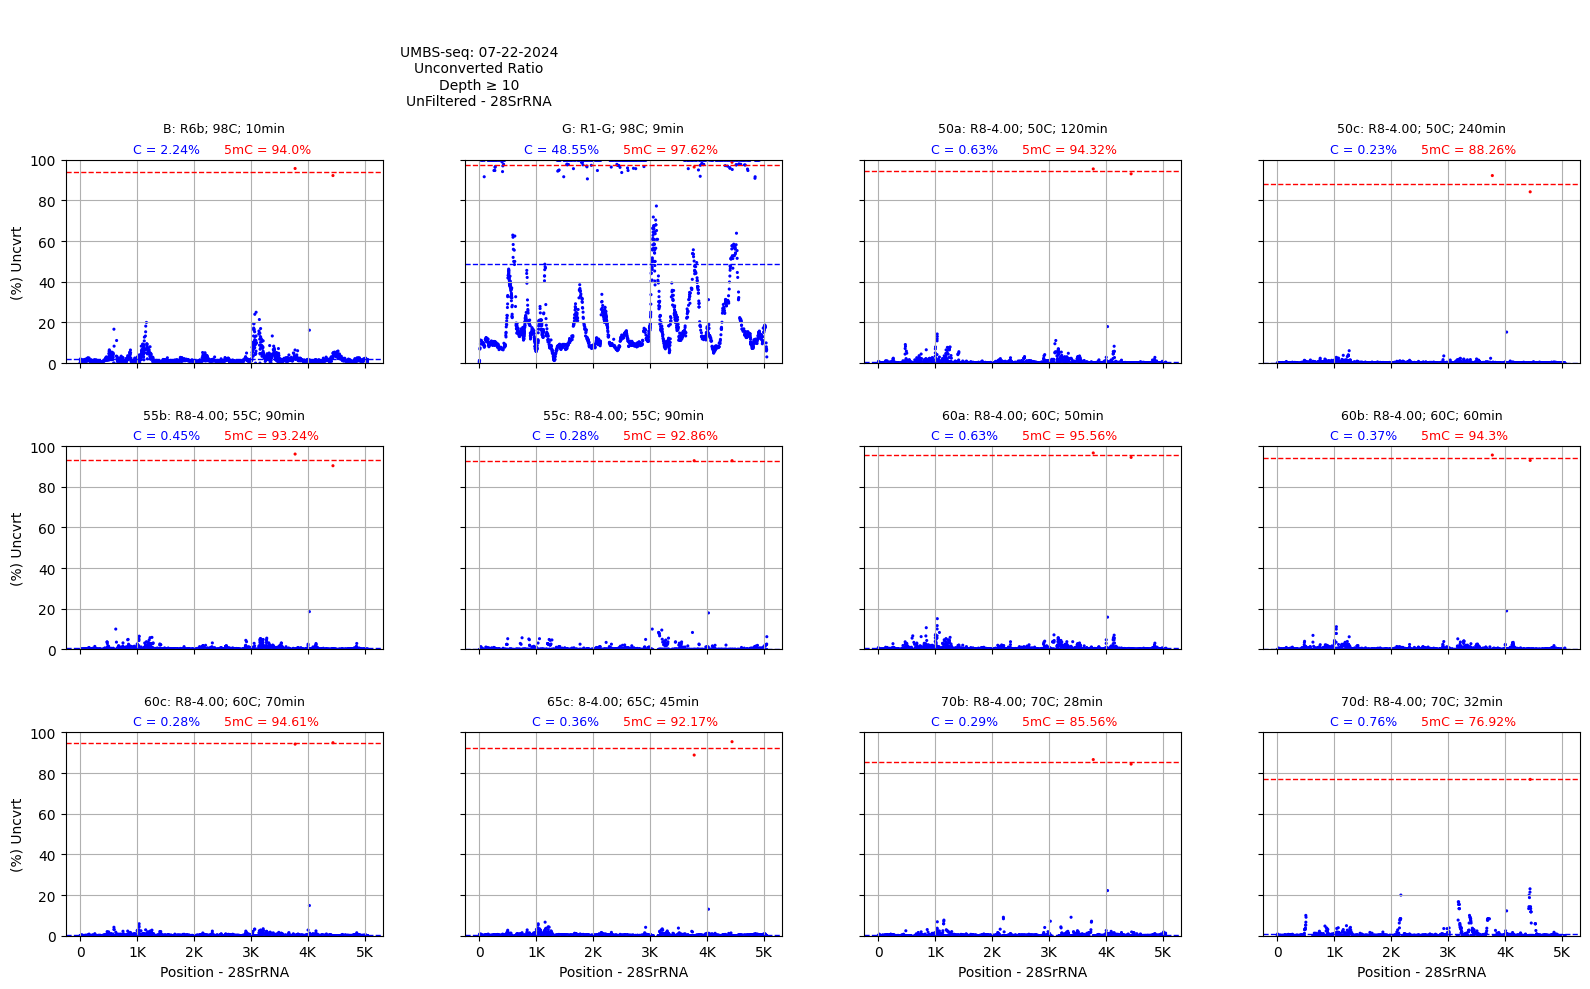

In [120]:
%%capture --no-display
plot_all(in_paths['28SrRNA'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nUn-Filtered\nDepth ≥ 10',
         s=5, min_depth = 10, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_28srRNA','csv'), aux_header='ref,SampleID,ac,a5c')

## Step: figures_conv_unconv_filter

#### Create Conv_Unconv Ratio

In [112]:
in_paths = mkpaths("ratio_conv_unconv_filter",refs)
out_path = mkpath("figures")

>>> {ratio_conv_unconv_filter_lambda} 00:23:02_09-26-2024
>>> {figures} 00:23:02_09-26-2024


#### Converted Ratio 5mC164

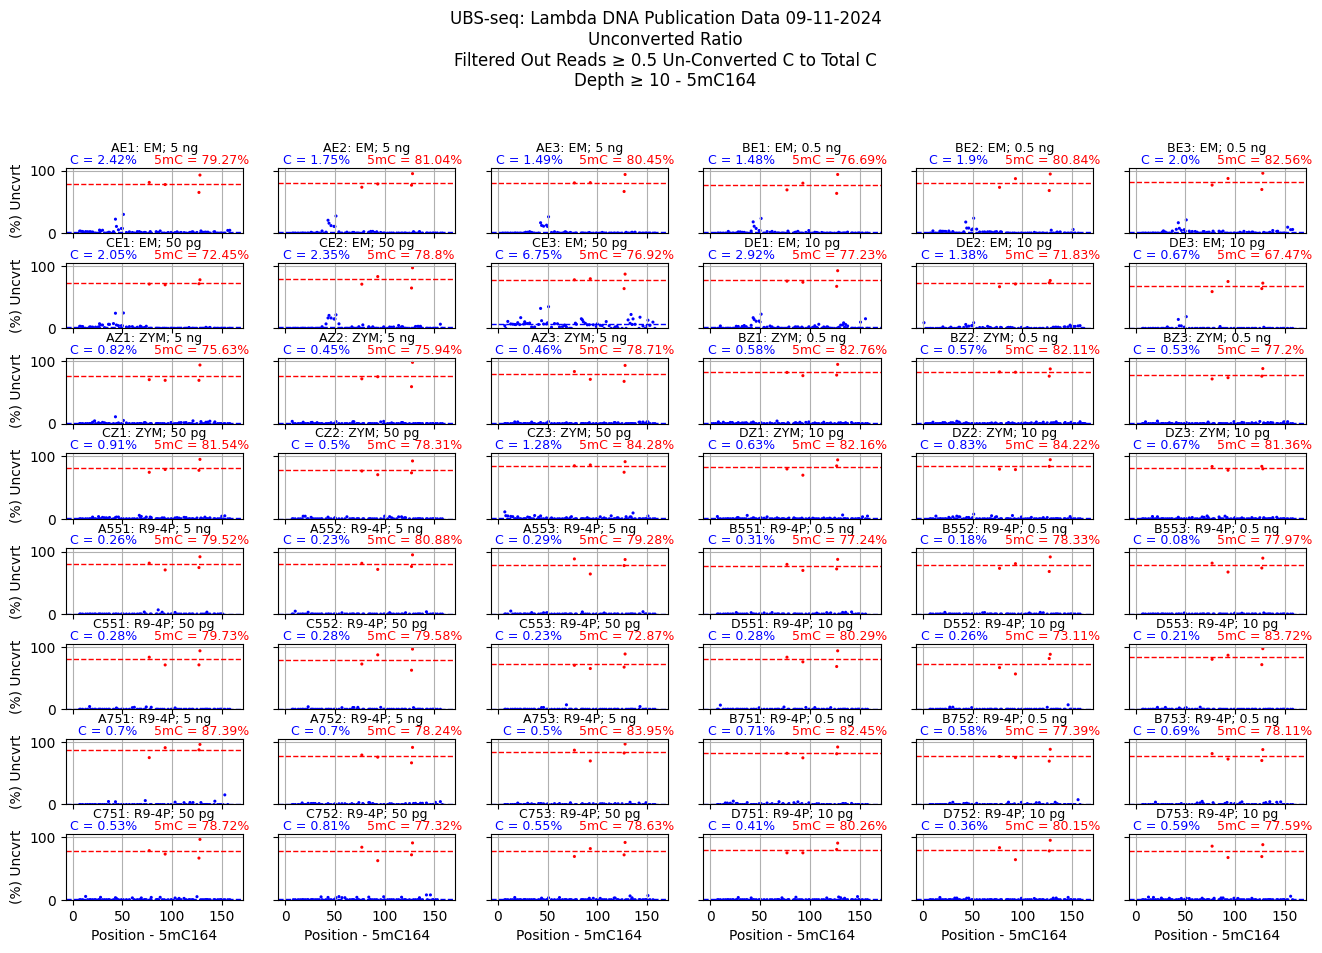

In [371]:
%%capture --no-display
plot_all(in_paths['5mC164'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nFiltered Out Reads ≥ 0.5 Un-Converted C to Total C\nDepth ≥ 10', min_depth = 10,
         s=5, every_nth = 1, ylim=(0,105))

#### Converted Ratio pUC19

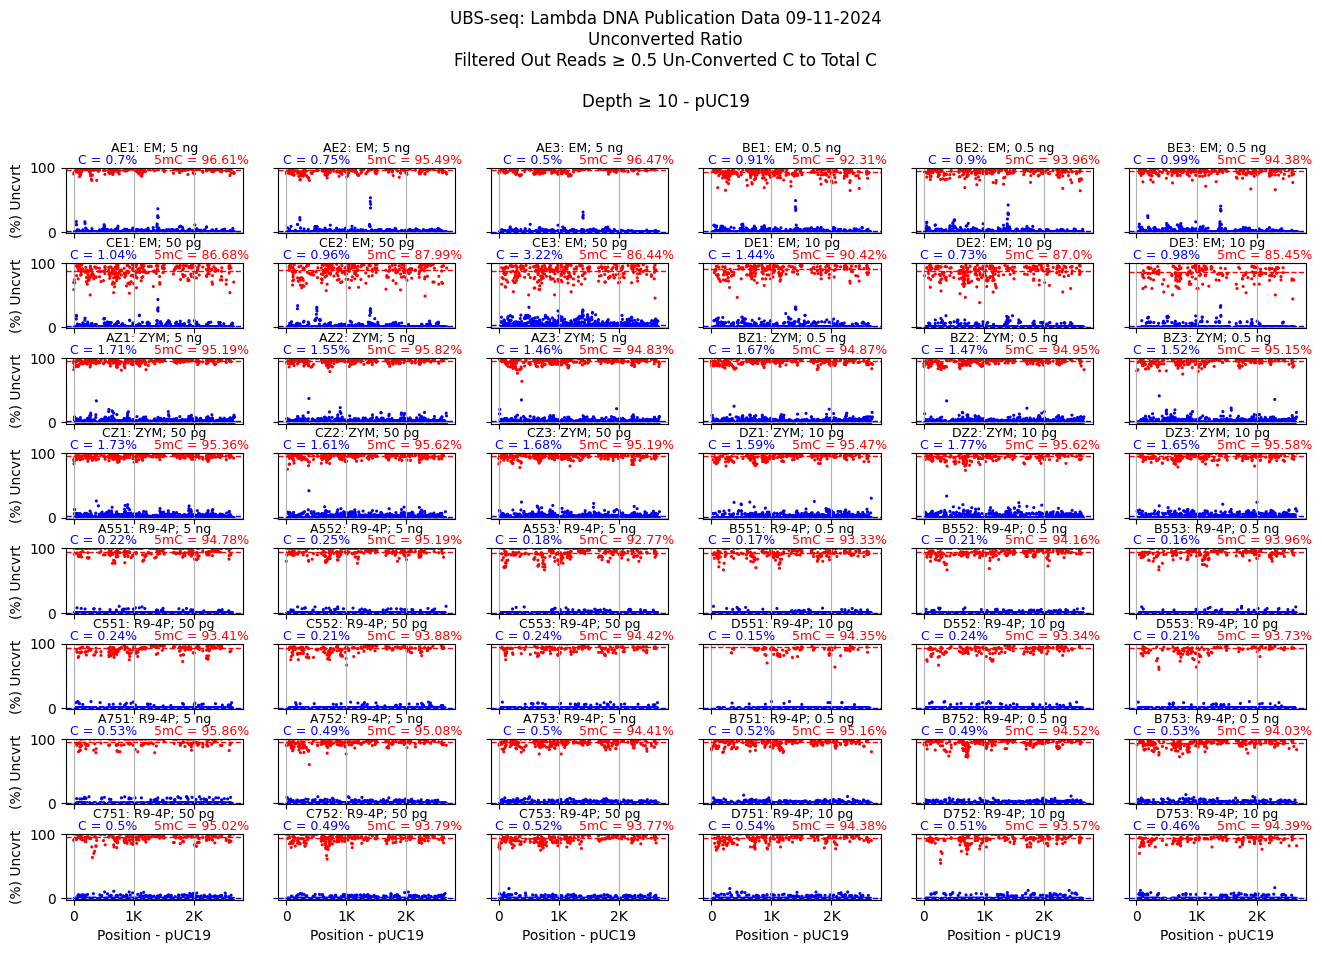

In [372]:
%%capture --no-display
plot_all(in_paths['pUC19'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nFiltered Out Reads ≥ 0.5 Un-Converted C to Total C\n\nDepth ≥ 10', min_depth = 10,
         s=5, every_nth=1, ylim=(-2,100),
         aux_fname=fname(out_path,f'avg_pUC19','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio lambda

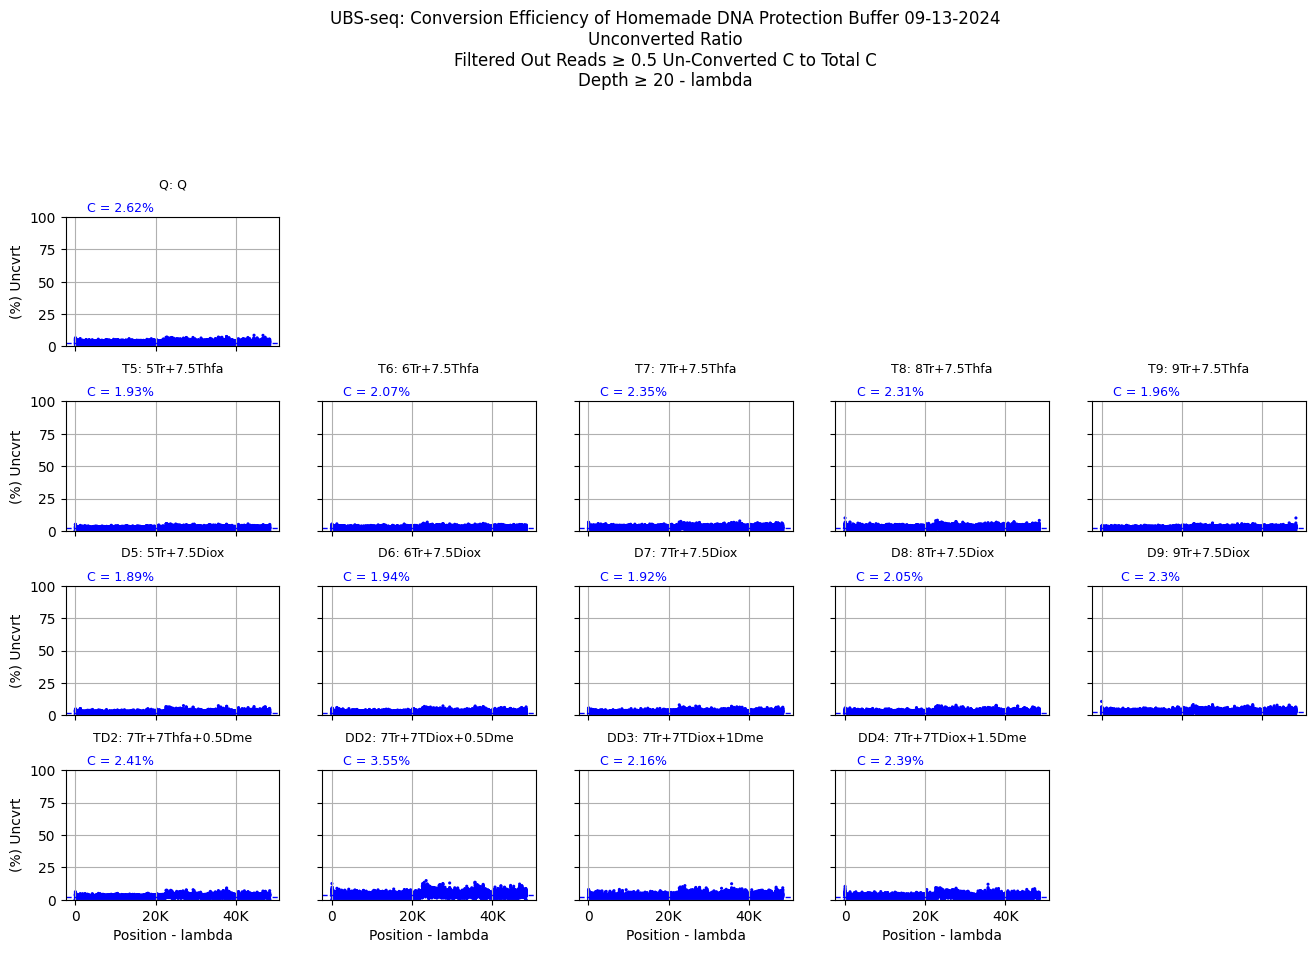

In [113]:
%%capture --no-display
plot_all(in_paths['lambda'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nFiltered Out Reads ≥ 0.5 Un-Converted C to Total C\nDepth ≥ 20',min_depth=20,
         s=5, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_lambda_filter','csv'), aux_header='ref,SampleID,ac,a5c')


#### Converted Ratio 18SrRNA

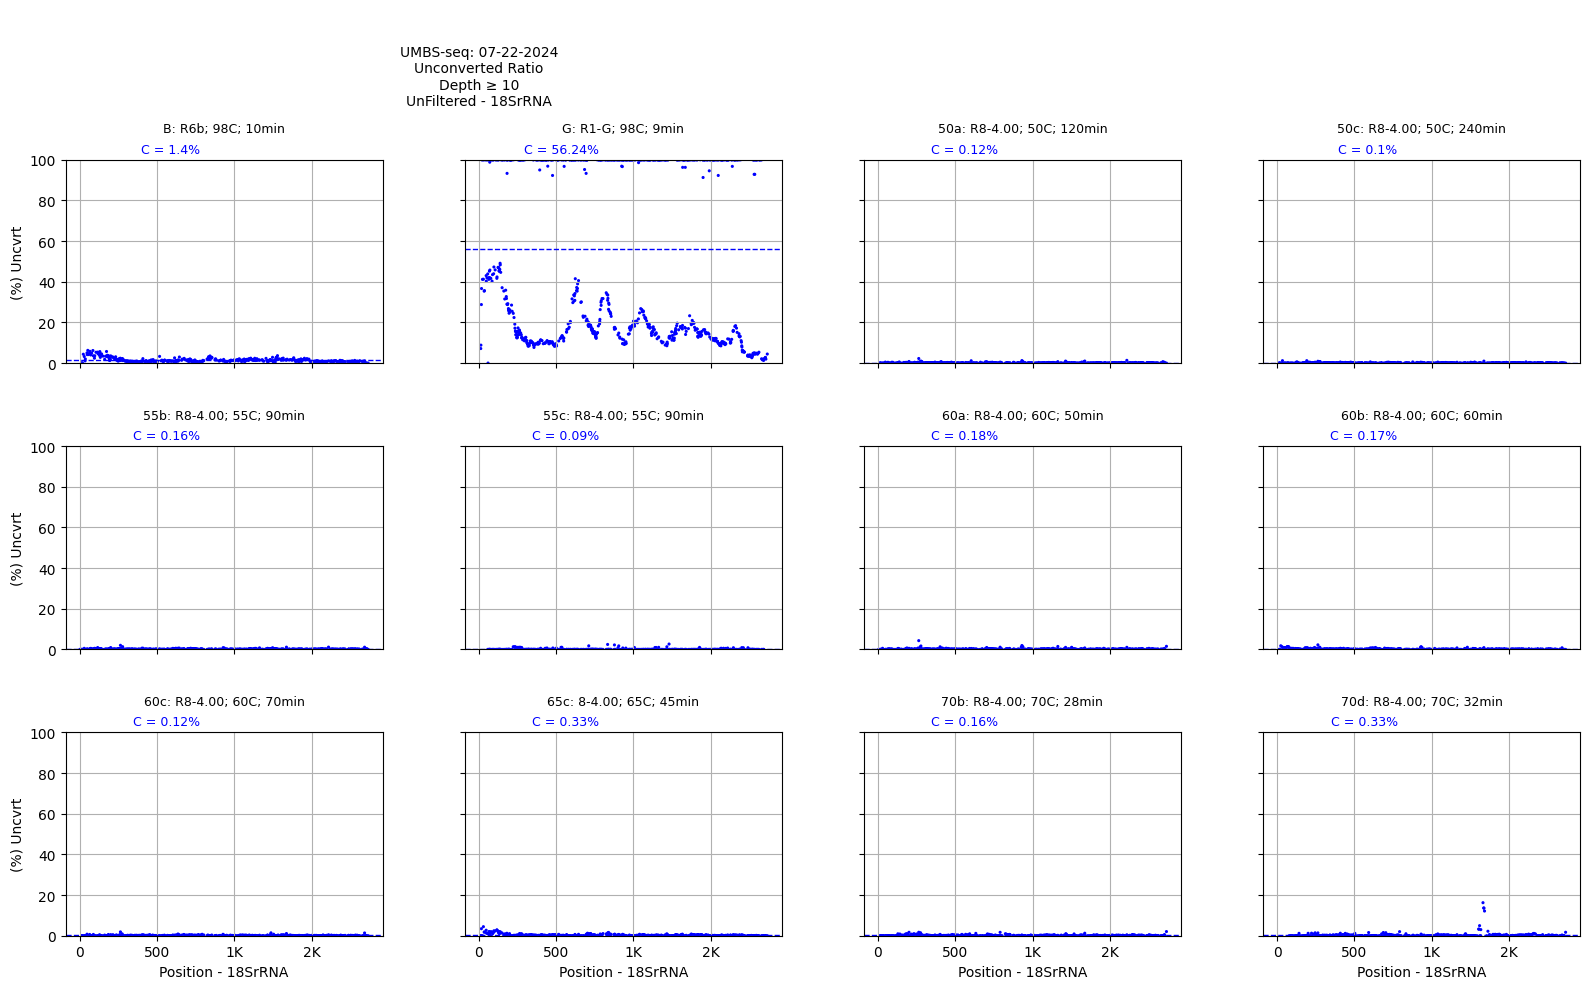

In [119]:
%%capture --no-display
plot_all(in_paths['18SrRNA'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nFiltered\nDepth ≥ 10',
         s=5, min_depth = 10, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_18srRNA','csv'), aux_header='ref,SampleID,ac,a5c')

#### Converted Ratio 28SrRNA

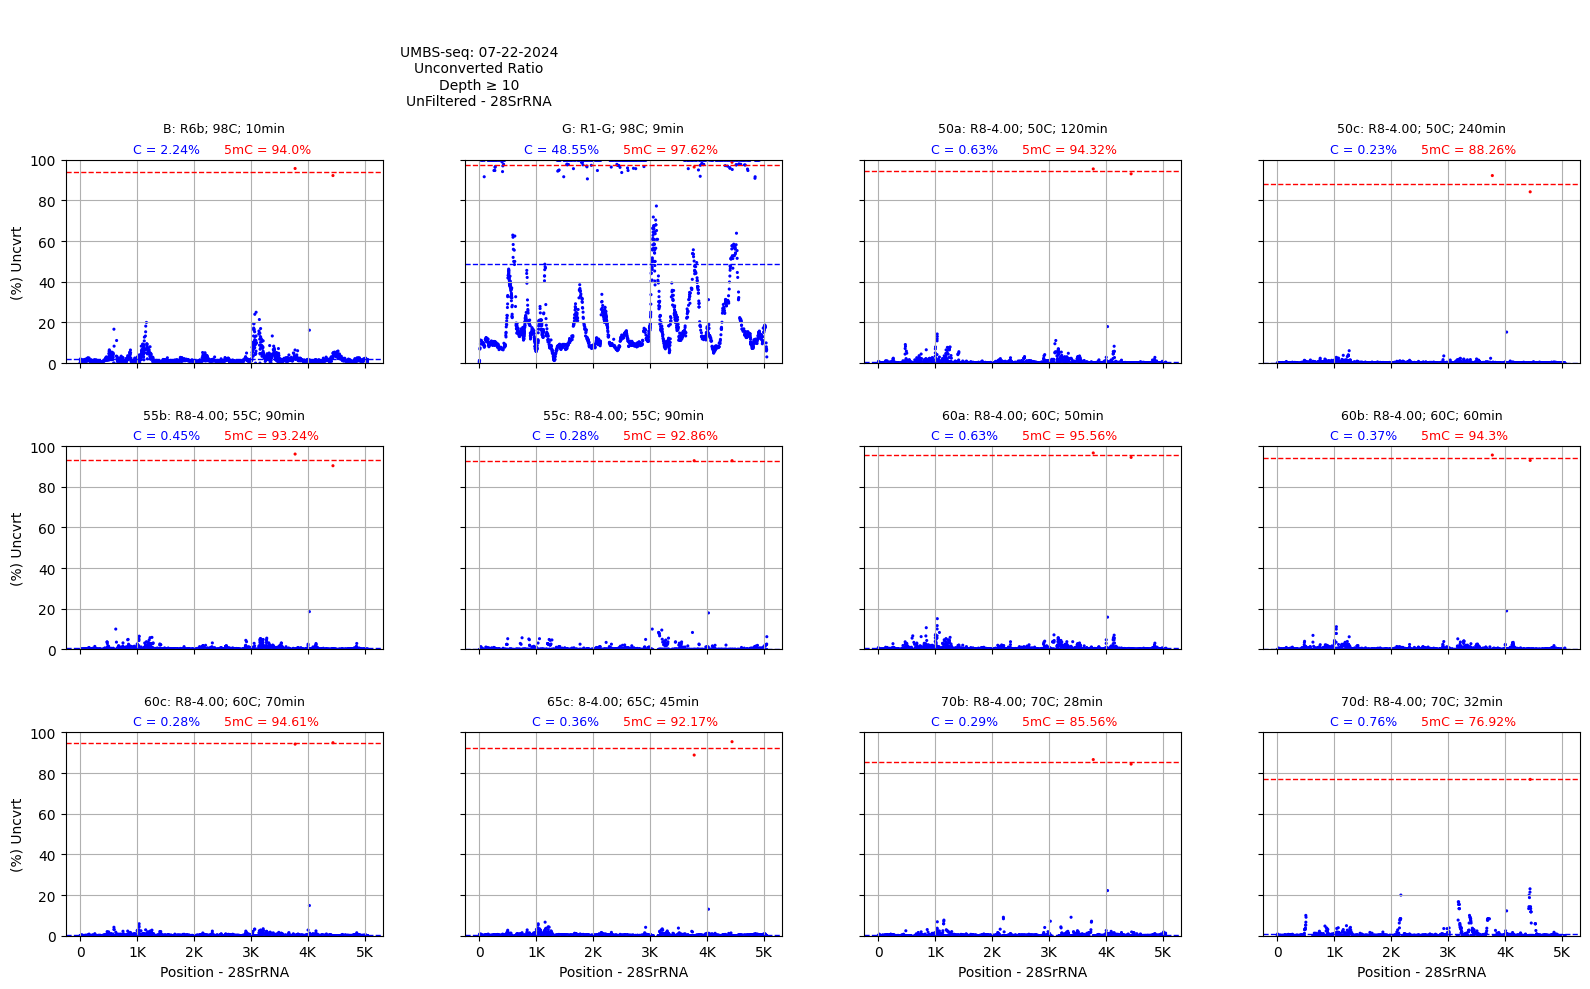

In [120]:
%%capture --no-display
plot_all(in_paths['28SrRNA'], conv_unconverted_plot, figure_title=f'{conv_unconv_figure_label}\nFiltered\nDepth ≥ 10',
         s=5, min_depth = 10, every_nth = 1, ylim=(0,100),
        aux_fname=fname(out_path,f'avg_28srRNA','csv'), aux_header='ref,SampleID,ac,a5c')

## Step: motif_conv_unconv_human

#### Motif Type for Converted and UnConverted Human

In [ ]:
in_path = mkpath('ratio_conv_unconv_human')
out_path = mkpath('motif_conv_unconv_human')
out_path_fig = mkpath("figures")

***Note: Using Polars human2.py with extention file.parquet***

#### Group by Motif Type (CG, CHG or CHH) and filter out non Chromosomal Regions

**read_human_tsv does the following: 1) reads tsv.gz files, 2) filters out non-Chromosomal regions, 3) creates Motif_type column (CG, CHG or CHH)**

In [444]:
import human2
reload(human2)
from human2 import *

In [ ]:
for sample in samples:
    (read_human_tsv(fname(in_path,sample,'tsv.gz'))
        .write_parquet(fname(out_path,sample,'pq')))

#### Generate Figure by Sample and Motif Type

```
human_motif_df(df: pl.DataFrame, depth: int = 1) -> pl.DataFrame
    1) Filters for Depth >= 1
    2) Groups by Motif_type
    3) Ratios are Sum over Genome of [Un]Converted/Depth
    Note: This is different Mean of Each C [Un]Converted/Depth
```

In [ ]:
title = 'Ratio_conv_unconv_by_motif_human'

In [ ]:
dfs = human_concat_dfs(out_path, samples, human_motif_df,suffix='pq')
dfs.write_csv(fname(out_path,title,'csv'))
dfs

#### Converted C (UnMethylated)

In [ ]:
fn = 'Ratio_conv_by_motif_human'
depth = 2 # >= 2 

dfs = pl.read_csv(fname(out_path,title,'csv')).filter(pl.col('Depth') >= depth)
plot_df = dfs.join(pl.DataFrame(list(sample2experiment.items()),schema=['Sample','Contents'],orient='row'),on='Sample')
plot_df = plot_df.with_columns(pl.col('Ratio_conv','Ratio_unconv')*100)

plt.figure(figsize=(16,10))
ax = sns.barplot(x='Ratio_conv', y='Sample', hue='Motif_type', data=plot_df, orient='h')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')
plt.xlabel('Converted to Total C (%)')
plt.ylabel('Sample')
plt.title('(%) Converted to Total C (%) by Sample and Motif Type')
plt.tight_layout()

save_path = fname(out_path_fig, fn, 'png')
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

#### Un-Converted C (Methylated)

In [ ]:
fn = 'Ratio_unconv_by_motif_human'
depth = 2 # >= 1 

dfs = pl.read_csv(fname(out_path,title,'csv')).filter(pl.col('Depth') >= depth)
plot_df = dfs.join(pl.DataFrame(list(sample2experiment.items()),schema=['Sample','Contents'],orient='row'),on='Sample')
plot_df = plot_df.with_columns(pl.col('Ratio_conv','Ratio_unconv')*100)

plt.figure(figsize=(16,10))
ax = sns.barplot(x='Ratio_unconv', y='Sample', hue='Motif_type', data=plot_df, orient='h')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')
plt.xlabel('UnConverted to Total C (%)')
plt.ylabel('Sample')
plt.title('(%) UnConverted to Total C (%) by Sample and Motif Type')
plt.tight_layout()

save_path = fname(out_path_fig, fn, 'png')
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

## Step: plot_coverage_human

#### Calculate Plot Coverage

In [122]:
in_path = mkpath('dedup_human')
out_path = mkpath('plot_coverage_human')
out_path_fig = mkpath("figures")

>>> {dedup_human} 16:17:06_10-15-2024
>>> {plot_coverage_human} 16:17:06_10-15-2024
>>> {figures} 16:17:06_10-15-2024


**plotCoverage**

```
The tool generates a panel of two plots.

- The first one simply represents the frequencies of the found read coverages, which helps you judge how relevant the mean coverage value (printed next to the sample name) is. If the distribution of read coverages is more or less homoskedatic and, ideally, normally distributed (most likely it won’t be), then the mean is a very appropriate proxy for sequencing depth.

- The second plot helps you answer the question what is the fraction of the genome that has a depth of sequencing of 2?
```
```
plotCoverage -b {bams}, space delimited bam files
    -o {fname(out_path_fig,'Avg_read_coverage', '')}, output path
    -n 1000000, Number of 1 bp regions to sample 
    -p max, maximum number of processors
    --plotTitle "Read Coverage" \
    --outRawCounts {fname(out_path,'plot_coverage_counts','tsv')} > {fname(out_path,'plot_coverage_metrics','tsv')}
```

In [123]:
bams = fnames_string([fname(in_path,sample, 'bam') for sample in samples],' ')
bams

'dedup_human/ST.bam dedup_human/EA.bam dedup_human/EB.bam dedup_human/EC.bam dedup_human/ZA.bam dedup_human/ZB.bam dedup_human/ZC.bam dedup_human/5A.bam dedup_human/5B.bam dedup_human/5C.bam dedup_human/5DA.bam dedup_human/5DB.bam dedup_human/5DC.bam dedup_human/7A.bam dedup_human/7B.bam dedup_human/7C.bam dedup_human/7DA.bam dedup_human/7DB.bam'

In [124]:
! plotCoverage -b {bams} \
    -o {fname(out_path_fig,'Avg_read_coverage', '')}\
    -n 1000000 \
    -p max \
    --plotTitle "Read Coverage" \
    --outRawCounts {fname(out_path,'plot_coverage_counts','tsv')} > {fname(out_path,'plot_coverage_metrics','tsv')}

![Plot Coverage](figures/Avg_read_coverage.png)

In [125]:
pd.read_csv(fname(out_path,'plot_coverage_metrics','tsv'),sep='\s+')

sample  mean   std  min  25%  50%  75%  max
0    ST.bam  0.02  0.15    0  0.0  0.0  0.0   19
1    EA.bam  0.02  0.13    0  0.0  0.0  0.0   17
2    EB.bam  0.02  0.15    0  0.0  0.0  0.0   18
3    EC.bam  0.01  0.12    0  0.0  0.0  0.0   15
4    ZA.bam  0.02  0.14    0  0.0  0.0  0.0   17
5    ZB.bam  0.02  0.16    0  0.0  0.0  0.0   20
6    ZC.bam  0.01  0.12    0  0.0  0.0  0.0   13
7    5A.bam  0.01  0.13    0  0.0  0.0  0.0   12
8    5B.bam  0.03  0.17    0  0.0  0.0  0.0   16
9    5C.bam  0.03  0.17    0  0.0  0.0  0.0   15
10  5DA.bam  0.02  0.16    0  0.0  0.0  0.0   15
11  5DB.bam  0.03  0.18    0  0.0  0.0  0.0   23
12  5DC.bam  0.03  0.18    0  0.0  0.0  0.0   25
13   7A.bam  0.02  0.15    0  0.0  0.0  0.0   18
14   7B.bam  0.02  0.15    0  0.0  0.0  0.0   15
15   7C.bam  0.02  0.14    0  0.0  0.0  0.0   19
16  7DA.bam  0.02  0.16    0  0.0  0.0  0.0   16
17  7DB.bam  0.01  0.12    0  0.0  0.0  0.0    8

## Step: plot_TSS_TSE_human

#### Plot Profile from TSS through TSE by Motif

In [126]:
in_path = mkpath('motif_conv_unconv_human')
out_path = mkpath('plot_tss_tse_human')
out_path_fig = mkpath("figures")

>>> {motif_conv_unconv_human} 16:22:24_10-15-2024
>>> {plot_tss_tse_human} 16:22:24_10-15-2024
>>> {figures} 16:22:24_10-15-2024


#### Generate BedGraph Files from motif_conv_unconv_human

#### DeepTools are used through out: [DeepTools](https://deeptools.readthedocs.io/en/latest/)

```
The BEDGraph file format is a tab-delimited format used to represent continuous-valued data across genomic intervals,
often for visualization in genome browsers. It consists of four columns:

1. chrom: Chromosome name (e.g., chr1).
2. chromStart: Start position of the interval (0-based, inclusive).
3. chromEnd: End position of the interval (1-based, exclusive).
4. value: A numeric score representing some quantitative feature (e.g., coverage, signal intensity).)

The file does not require a header but may include a track line for metadata. BEDGraph files are typically sorted by
chromosome and position for better performance in genome browsers and often have the extension .bedgraph or .bg
```

#### Group: Chrom, Chrom_start, Chrom_end, Ratio_unconv by Sample and Motif_type
Note: Pos is 1-based; Chrom_start and Chrom_end are 0-based, i.e., Pos = 30 -> [29,30]

In [127]:
pl.read_parquet(fname(in_path,samples[0],'pq')).head()

shape: (5, 11)
┌────────┬───────┬───────┬────────┬───┬────────────┬──────────────┬───────┬────────────┐
│ Sample ┆ Chrom ┆ Pos   ┆ Strand ┆ … ┆ Ratio_conv ┆ Ratio_unconv ┆ Motif ┆ Motif_type │
│ ---    ┆ ---   ┆ ---   ┆ ---    ┆   ┆ ---        ┆ ---          ┆ ---   ┆ ---        │
│ str    ┆ enum  ┆ i64   ┆ str    ┆   ┆ f64        ┆ f64          ┆ str   ┆ str        │
╞════════╪═══════╪═══════╪════════╪═══╪════════════╪══════════════╪═══════╪════════════╡
│ ST     ┆ 1     ┆ 62024 ┆ -      ┆ … ┆ 0.0        ┆ 1.0          ┆ CTG   ┆ CHG        │
│ ST     ┆ 1     ┆ 62034 ┆ -      ┆ … ┆ 0.0        ┆ 1.0          ┆ CAA   ┆ CHH        │
│ ST     ┆ 1     ┆ 62044 ┆ -      ┆ … ┆ 0.0        ┆ 1.0          ┆ CTA   ┆ CHH        │
│ ST     ┆ 1     ┆ 62047 ┆ -      ┆ … ┆ 0.0        ┆ 1.0          ┆ CTA   ┆ CHH        │
│ ST     ┆ 1     ┆ 62049 ┆ -      ┆ … ┆ 0.0        ┆ 1.0          ┆ CTC   ┆ CHH        │
└────────┴───────┴───────┴────────┴───┴────────────┴──────────────┴───────┴────────────┘

In [128]:
motifs = ['CG','CHG','CHH']

In [129]:
for sample in samples:
    df = pl.read_parquet(fname(in_path,sample,'pq'))
    for motif in motifs:
        fn = '_'.join([sample, motif])
        (df.filter(pl.col('Motif_type') == motif)
            .with_columns(Start=pl.col('Pos') -1, End=pl.col('Pos'),Ratio_unconv=pl.col('Ratio_unconv')*100)
            .select(['Chrom','Start','End','Ratio_unconv'])
            .write_csv(fname(out_path, fn,'bg'),separator='\t',include_header=False))

In [130]:
pl.read_csv(fname(out_path,'_'.join([samples[0],'CG']),'bg'),separator='\t',infer_schema=False,has_header=False)

shape: (419_835, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str      ┆ str      ┆ str      ┆ str      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1        ┆ 62420    ┆ 62421    ┆ 100.0    │
│ 1        ┆ 79401    ┆ 79402    ┆ 100.0    │
│ 1        ┆ 79417    ┆ 79418    ┆ 0.0      │
│ 1        ┆ 127492   ┆ 127493   ┆ 100.0    │
│ 1        ┆ 187076   ┆ 187077   ┆ 100.0    │
│ …        ┆ …        ┆ …        ┆ …        │
│ Y        ┆ 56871109 ┆ 56871110 ┆ 100.0    │
│ Y        ┆ 56881364 ┆ 56881365 ┆ 100.0    │
│ Y        ┆ 56881847 ┆ 56881848 ┆ 100.0    │
│ Y        ┆ 56882344 ┆ 56882345 ┆ 100.0    │
│ Y        ┆ 57188010 ┆ 57188011 ┆ 100.0    │
└──────────┴──────────┴──────────┴──────────┘

#### Generate BigWig Files from BedGraph Files

```
bedGraphToBigWig v 2.10 - Convert a bedGraph file to bigWig format (bbi version: 4).
usage:
   bedGraphToBigWig in.bedGraph chrom.sizes out.bw
where in.bedGraph is a four column file in the format:
      <chrom> <start> <end> <value>
and chrom.sizes is a two-column file/URL: <chromosome name> <size in bases>
and out.bw is the output indexed big wig file.
```

**Use the human.fa.fai file instead of chrom.sizes file**

In [131]:
human_fa_fai = '../../reference/fasta/human.fa.fai'

In [132]:
for sample in samples:
    for motif in motifs:
        fn = '_'.join([sample, motif])
        !bedGraphToBigWig {fname(out_path,fn,'bg')} {human_fa_fai} {fname(out_path,fn,'bw')}

**Delete BedGraph Files**

In [ ]:
#! cd {out_path}; rm *.bedgraph

#### Generate ComputeMatrix from BigWig Files

```
computeMatrix scale-regions -S input.bigWig input2.bigWig ...,      Space delimited BigWig Files

                            -R  ../../../reference/gtf/human.gtf    - GTF or Bed Files corresponding to reference genome
                            --beforeRegionStartLength 3000          - Distance upstream of the start site of the regions defined in the region file. If the regions are genes,
                                                                      this would be the distance upstream of thetranscription start site. (Default: 0)
                            --regionBodyLength 5000,                - Distance in bases to which all regions will be fit (Default: 1000)
                            --afterRegionStartLength 3000           - Distance downstream of the end site of the given regions. If the regions are genes, this would be the
                                                                      distance downstream of the transcription end site. (Default: 0)
                            --skipZeros                             - Whether regions with only scores of zero should beincluded or not. Default is to include them. (default: False
                            -p                                      - Number of processors (Default: 1, most: max)
                            -o matrix.mat.gz                        - Output file
```

**Define motif groups**

In [133]:
motif_samples = ['ST','EA','EC','ZA','ZC','5A','5C','7A','7C']

In [134]:
mot = 'CG'
motif_CG =  fnames_string([fname(out_path, '_'.join([s,mot]),'bw') for s in motif_samples])

In [135]:
# Validate
for fn in motif_CG.split(' '):
    !ls {fn}

plot_tss_tse_human/ST_CG.bw
plot_tss_tse_human/EA_CG.bw
plot_tss_tse_human/EC_CG.bw
plot_tss_tse_human/ZA_CG.bw
plot_tss_tse_human/ZC_CG.bw
plot_tss_tse_human/5A_CG.bw
plot_tss_tse_human/5C_CG.bw
plot_tss_tse_human/7A_CG.bw
plot_tss_tse_human/7C_CG.bw


In [136]:
mot = 'CHG'
motif_CHG =  fnames_string([fname(out_path, '_'.join([s,mot]),'bw') for s in motif_samples])

In [137]:
# Validate
for fn in motif_CHG.split(' '):
    !ls {fn}

plot_tss_tse_human/ST_CHG.bw
plot_tss_tse_human/EA_CHG.bw
plot_tss_tse_human/EC_CHG.bw
plot_tss_tse_human/ZA_CHG.bw
plot_tss_tse_human/ZC_CHG.bw
plot_tss_tse_human/5A_CHG.bw
plot_tss_tse_human/5C_CHG.bw
plot_tss_tse_human/7A_CHG.bw
plot_tss_tse_human/7C_CHG.bw


In [138]:
mot = 'CHH'
motif_CHH =  fnames_string([fname(out_path, '_'.join([s,mot]),'bw') for s in motif_samples])

In [139]:
# Validate
for fn in motif_CG.split(' '):
    !ls {fn}

plot_tss_tse_human/ST_CG.bw
plot_tss_tse_human/EA_CG.bw
plot_tss_tse_human/EC_CG.bw
plot_tss_tse_human/ZA_CG.bw
plot_tss_tse_human/ZC_CG.bw
plot_tss_tse_human/5A_CG.bw
plot_tss_tse_human/5C_CG.bw
plot_tss_tse_human/7A_CG.bw
plot_tss_tse_human/7C_CG.bw


**Define matrix groups (of motif groups)**

In [140]:
motif_groups = {'CpG': motif_CG, 'CHG': motif_CHG, 'CHH': motif_CHH}
motif_groups

{'CpG': 'plot_tss_tse_human/ST_CG.bw plot_tss_tse_human/EA_CG.bw plot_tss_tse_human/EC_CG.bw plot_tss_tse_human/ZA_CG.bw plot_tss_tse_human/ZC_CG.bw plot_tss_tse_human/5A_CG.bw plot_tss_tse_human/5C_CG.bw plot_tss_tse_human/7A_CG.bw plot_tss_tse_human/7C_CG.bw',
 'CHG': 'plot_tss_tse_human/ST_CHG.bw plot_tss_tse_human/EA_CHG.bw plot_tss_tse_human/EC_CHG.bw plot_tss_tse_human/ZA_CHG.bw plot_tss_tse_human/ZC_CHG.bw plot_tss_tse_human/5A_CHG.bw plot_tss_tse_human/5C_CHG.bw plot_tss_tse_human/7A_CHG.bw plot_tss_tse_human/7C_CHG.bw',
 'CHH': 'plot_tss_tse_human/ST_CHH.bw plot_tss_tse_human/EA_CHH.bw plot_tss_tse_human/EC_CHH.bw plot_tss_tse_human/ZA_CHH.bw plot_tss_tse_human/ZC_CHH.bw plot_tss_tse_human/5A_CHH.bw plot_tss_tse_human/5C_CHH.bw plot_tss_tse_human/7A_CHH.bw plot_tss_tse_human/7C_CHH.bw'}

In [141]:
mat_groups = motif_groups
mat_prefix = 'motif_groups'
'------------------------'
print(mat_prefix)
print(mat_groups)

motif_groups
{'CpG': 'plot_tss_tse_human/ST_CG.bw plot_tss_tse_human/EA_CG.bw plot_tss_tse_human/EC_CG.bw plot_tss_tse_human/ZA_CG.bw plot_tss_tse_human/ZC_CG.bw plot_tss_tse_human/5A_CG.bw plot_tss_tse_human/5C_CG.bw plot_tss_tse_human/7A_CG.bw plot_tss_tse_human/7C_CG.bw', 'CHG': 'plot_tss_tse_human/ST_CHG.bw plot_tss_tse_human/EA_CHG.bw plot_tss_tse_human/EC_CHG.bw plot_tss_tse_human/ZA_CHG.bw plot_tss_tse_human/ZC_CHG.bw plot_tss_tse_human/5A_CHG.bw plot_tss_tse_human/5C_CHG.bw plot_tss_tse_human/7A_CHG.bw plot_tss_tse_human/7C_CHG.bw', 'CHH': 'plot_tss_tse_human/ST_CHH.bw plot_tss_tse_human/EA_CHH.bw plot_tss_tse_human/EC_CHH.bw plot_tss_tse_human/ZA_CHH.bw plot_tss_tse_human/ZC_CHH.bw plot_tss_tse_human/5A_CHH.bw plot_tss_tse_human/5C_CHH.bw plot_tss_tse_human/7A_CHH.bw plot_tss_tse_human/7C_CHH.bw'}


**Generate ComputeMatrix for matrix groups**

In [ ]:
for motif, bws in mat_groups.items():
    fn = f'{mat_prefix}_{motif}'
    !computeMatrix scale-regions -S {bws} \
    -R ../../reference/gtf/human.gtf \
    --beforeRegionStartLength 3000 \
    --regionBodyLength 5000 \
    --afterRegionStartLength 3000 \
    -p max \
    -o {fname(out_path,fn,'mat.gz')}

A region that is shorter than the bin size (possibly only after accounting for unscaled regions) was found: (8) ENST00000415118 14:22438546:22438554. Skipping...
A region that is shorter than the bin size (possibly only after accounting for unscaled regions) was found: (9) ENST00000434970 14:22439006:22439015. Skipping...
A region that is shorter than the bin size (possibly only after accounting for unscaled regions) was found: (8) ENST00000415118 14:22438546:22438554. Skipping...
A region that is shorter than the bin size (possibly only after accounting for unscaled regions) was found: (9) ENST00000434970 14:22439006:22439015. Skipping...
A region that is shorter than the bin size (possibly only after accounting for unscaled regions) was found: (8) ENST00000415118 14:22438546:22438554. Skipping...
A region that is shorter than the bin size (possibly only after accounting for unscaled regions) was found: (9) ENST00000434970 14:22439006:22439015. Skipping...


#### Generate PlotProfiles

In [ ]:
for motif in mat_groups.keys():
    fn = f'{mat_prefix}_{motif}'
    title = f"'{mat_prefix} - {motif} Motif'"
    ! plotProfile -m {fname(out_path,fn,'mat.gz')} -out {fname(out_path_fig,fn,'mat.png')} --plotTitle {title} --perGroup \
        -y "Methylation Level (%)" --yMin 0 --yMax 100  --plotHeight 10 --plotWidth 16 --dpi 400

![motif_greoups_CpG](figures/motif_groups_CpG.mat.png)

![motif_greoups_CHG](figures/motif_groups_CHG.mat.png)

![motif_greoups_HH](figures/motif_groups_CHH.mat.png)

## Step: figures_conv_unconv_lambda

### Lambda - Un-Filtered

In [116]:
df_l = pd.read_csv(f'figures/avg_lambda.csv')
df_l.head()

ref SampleID         ac  a5c
0  lambda       ST  99.729411    0
1  lambda       A1   1.673824    0
2  lambda       A2   1.543558    0
3  lambda       A3   0.553917    0
4  lambda       A4   0.184511    0

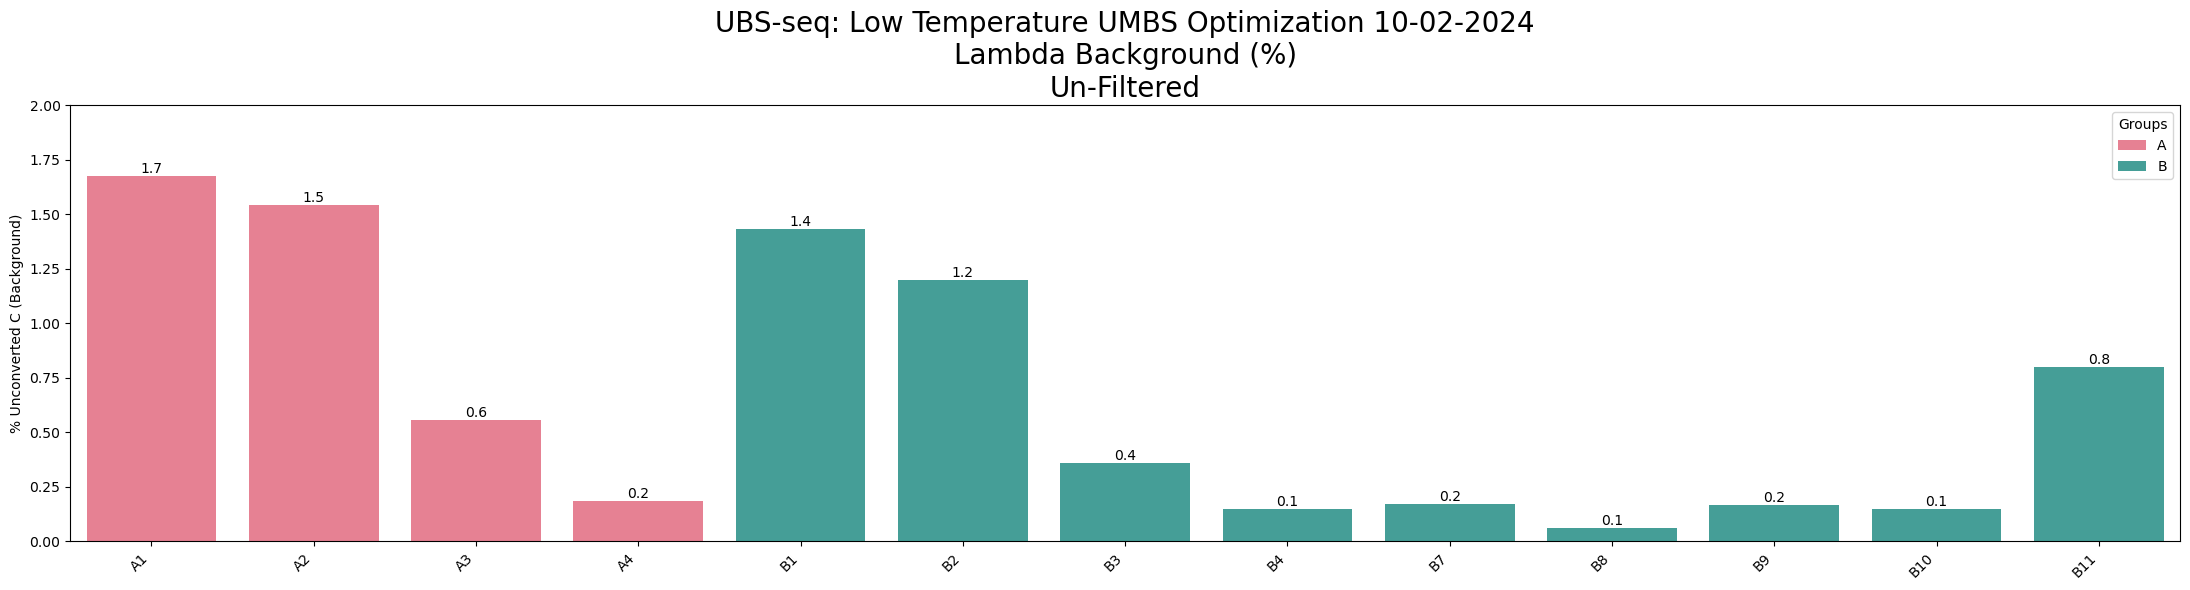

In [129]:
generate_bar_graph(df_l, value_col='ac', yrange=2, ylabel = '% Unconverted C (Background)', 
                   title= f"{experiment_title}\nLambda Background (%)\nUn-Filtered",
                   groups=sample_groups)

### Lambda - Filtered

In [126]:
df_l_filter = pd.read_csv(f'figures/avg_lambda_filter.csv')
df_l_filter.head()

ref SampleID        ac  a5c
0  lambda        Q  2.622942    0
1  lambda       T5  1.932100    0
2  lambda       T6  2.073091    0
3  lambda       T7  2.351456    0
4  lambda       T8  2.307992    0

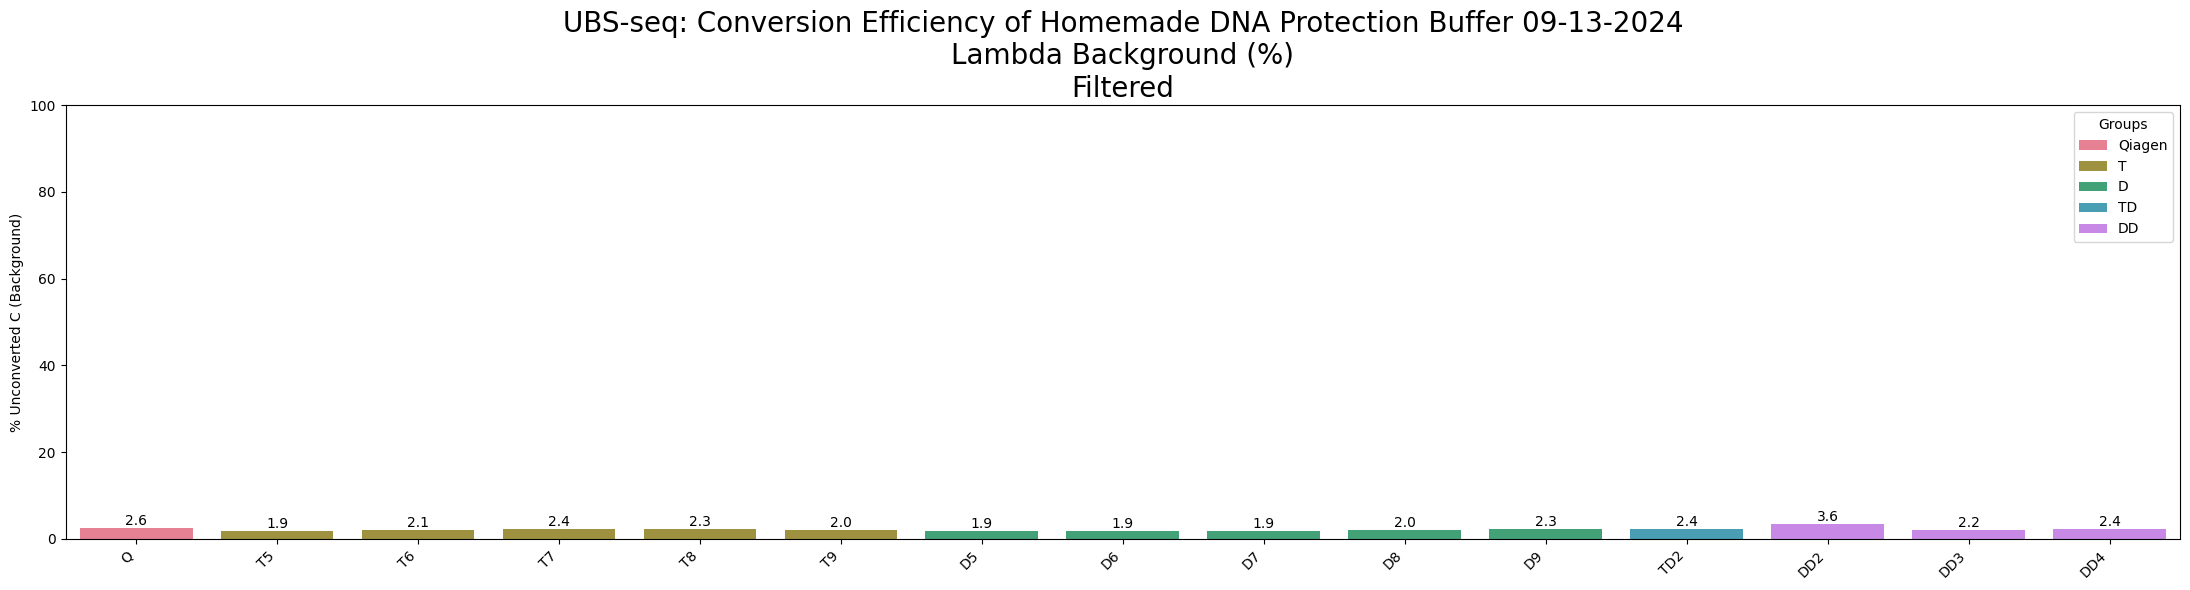

In [127]:
generate_bar_graph(df_l_filter, value_col='ac', yrange=100, ylabel = '% Unconverted C (Background)', 
                   title= f"{experiment_title}\nLambda Background (%)\nFiltered",
                   groups=sample_groups)

## Step: figures_conv_unconv_groups_misc

In [378]:
df_al = agg_replicates(df_l, 3)
df_al.head()

SampleID      mean       std
0      AE1  0.572823  0.109888
1      BE1  0.766808  0.064335
2      CE1  2.472176  2.672017
3      DE1  1.618862  1.200968
4      AZ1  0.558134  0.018465

#### DNA Publication Data: Lambda Background EM-seq, Zymo, UMBS-55C, UMBS-75C (Mean of Replicates) 9-11-24

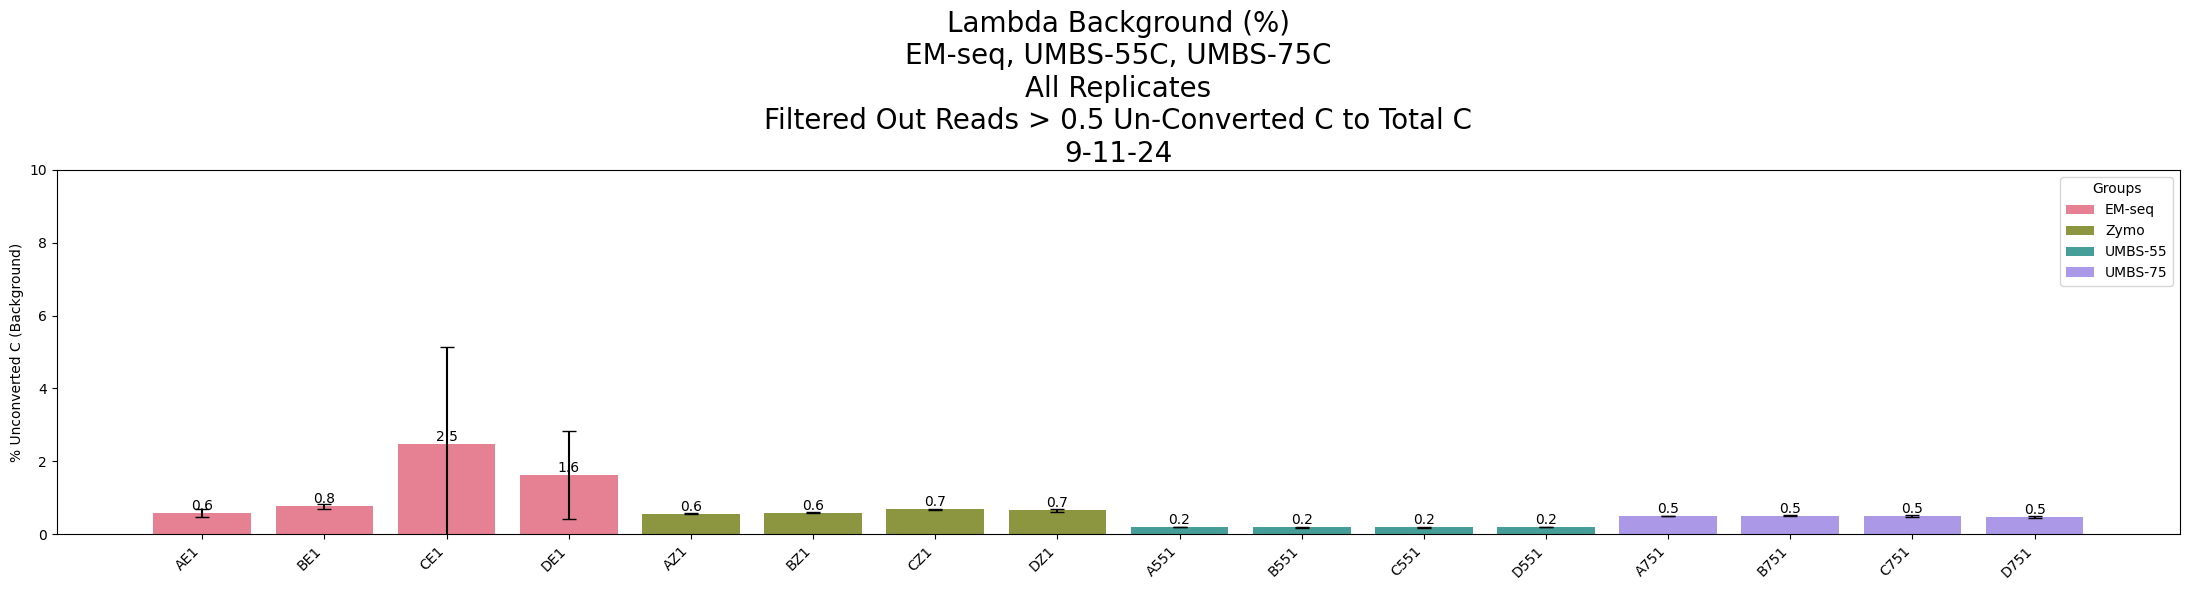

In [379]:
generate_bar_graph(df_al, value_col='mean', yrange=10,ylabel = '% Unconverted C (Background)',
                   title="Lambda Background (%)\nEM-seq, UMBS-55C, UMBS-75C\nAll Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                   groups={'EM-seq':[0,1,2,3],'Zymo':[4,5,6,7],'UMBS-55':[8,9,10,11],'UMBS-75':[12,13,14,15]})

#### DNA Publication Data: Lambda Background EM-seq, UMBS-55C, UMBS-75C (Mean of Replicates) 9-11-24

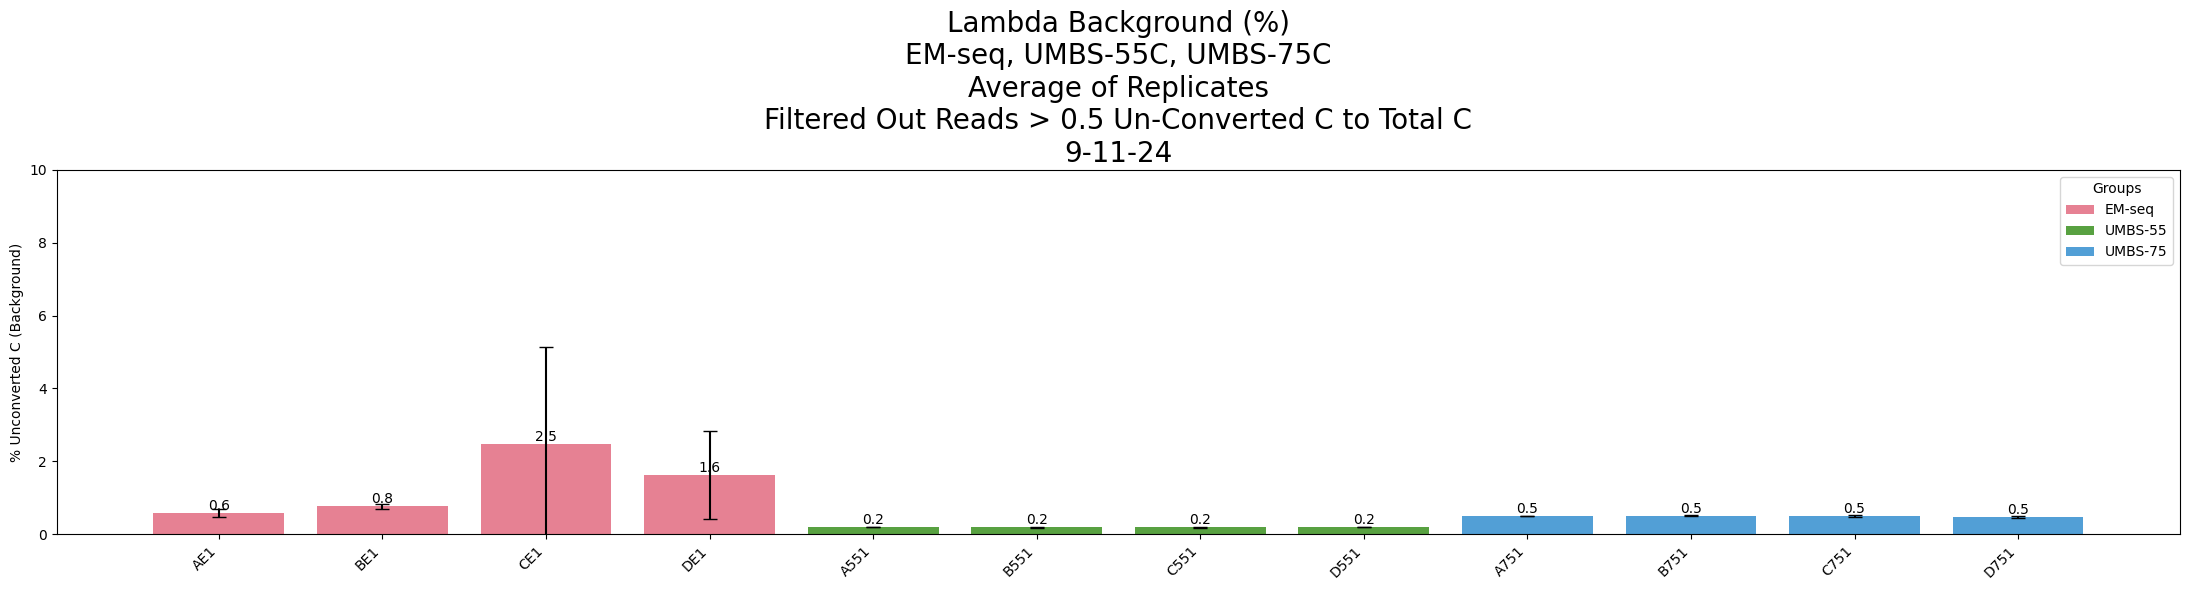

In [380]:
generate_bar_graph(df_al,value_col='mean', yrange=10,ylabel = '% Unconverted C (Background)',
                   title="Lambda Background (%)\nEM-seq, UMBS-55C, UMBS-75C\nAverage of Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                   groups={'EM-seq':[0,1,2,3],'UMBS-55':[8,9,10,11],'UMBS-75':[12,13,14,15]})

#### DNA Publication Data: Lambda Background EM-seq vs.UMBS-55C (Mean of Replicates) 9-11-24

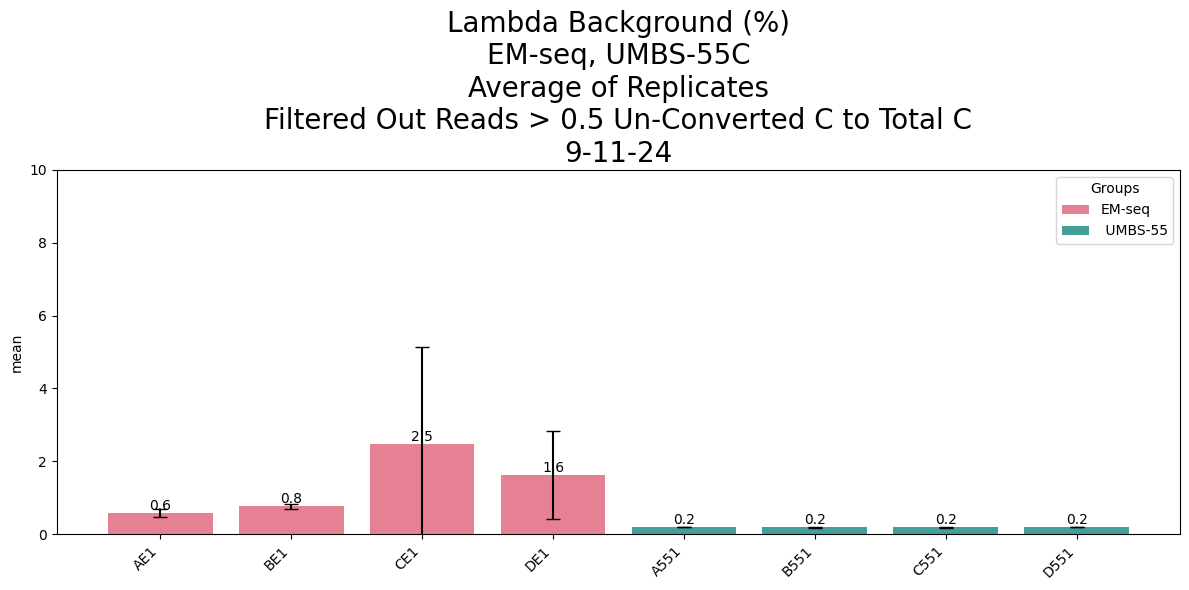

In [381]:
generate_bar_graph(df_al,value_col='mean', yrange=10,
                   title="Lambda Background (%)\nEM-seq, UMBS-55C\nAverage of Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                   size=(12,6),
                   groups={'EM-seq':[0,1,2,3],' UMBS-55':[8,9,10,11]})

### pUC19 5mC

In [343]:
df_p = pd.read_csv(f'figures/avg_pUC19.csv')
df_p.head()

ref SampleID        ac        a5c
0  pUC19      AE1  0.697693  96.609801
1  pUC19      AE2  0.749556  95.489981
2  pUC19      AE3  0.504767  96.472133
3  pUC19      BE1  0.912799  92.307093
4  pUC19      BE2  0.902737  93.962747

#### pUC19 EM-seq, Zymo, UMBS-55C, UMBS-75C (All Replicates) 

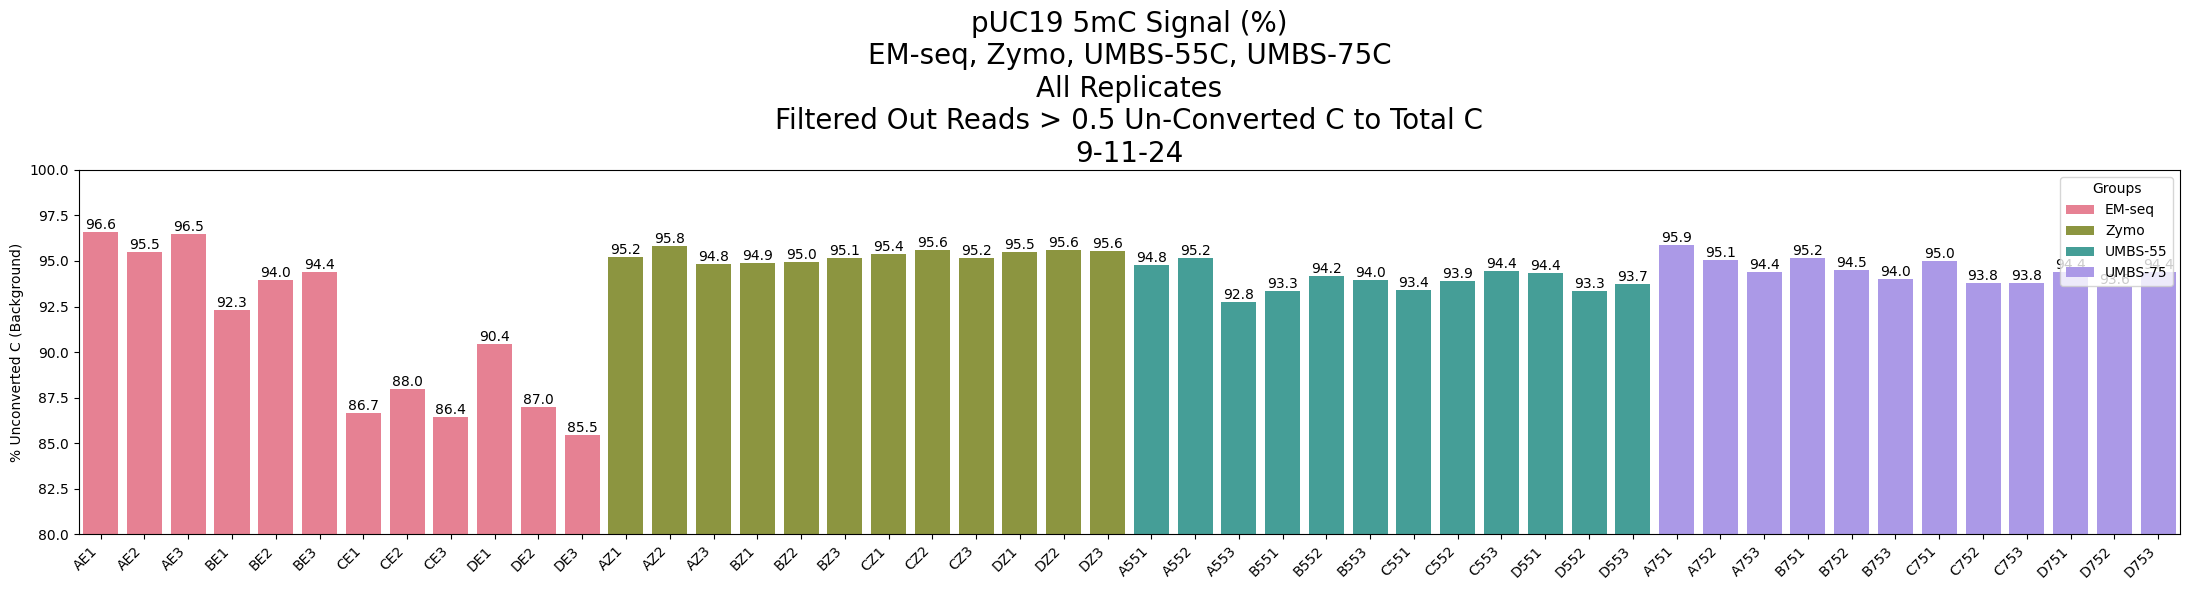

In [345]:
generate_bar_graph(df_p, label_col='SampleID', value_col='a5c', yrange=(80,100), ylabel = '% Unconverted C (Background)', 
                title= "pUC19 5mC Signal (%)\nEM-seq, Zymo, UMBS-55C, UMBS-75C\nAll Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                groups={'EM-seq': range(0,12),'Zymo':range(12,24),'UMBS-55': range(24,36),'UMBS-75': range(36,48)})

In [347]:
df_ap = agg_replicates(df_p, group_size_or_list=3, sample_col= 'SampleID', value_col='a5c')
df_ap.head()

SampleID       mean       std
0      AE1  96.190638  0.610679
1      BE1  93.548428  1.094653
2      CE1  87.035959  0.838495
3      DE1  87.621832  2.540623
4      AZ1  95.279749  0.502973

#### DNA Publication Data: pUC19 5mC EM-seq, Zymo, UMBS-55C, UMBS-75C (Mean of Replicates) 9-11-24

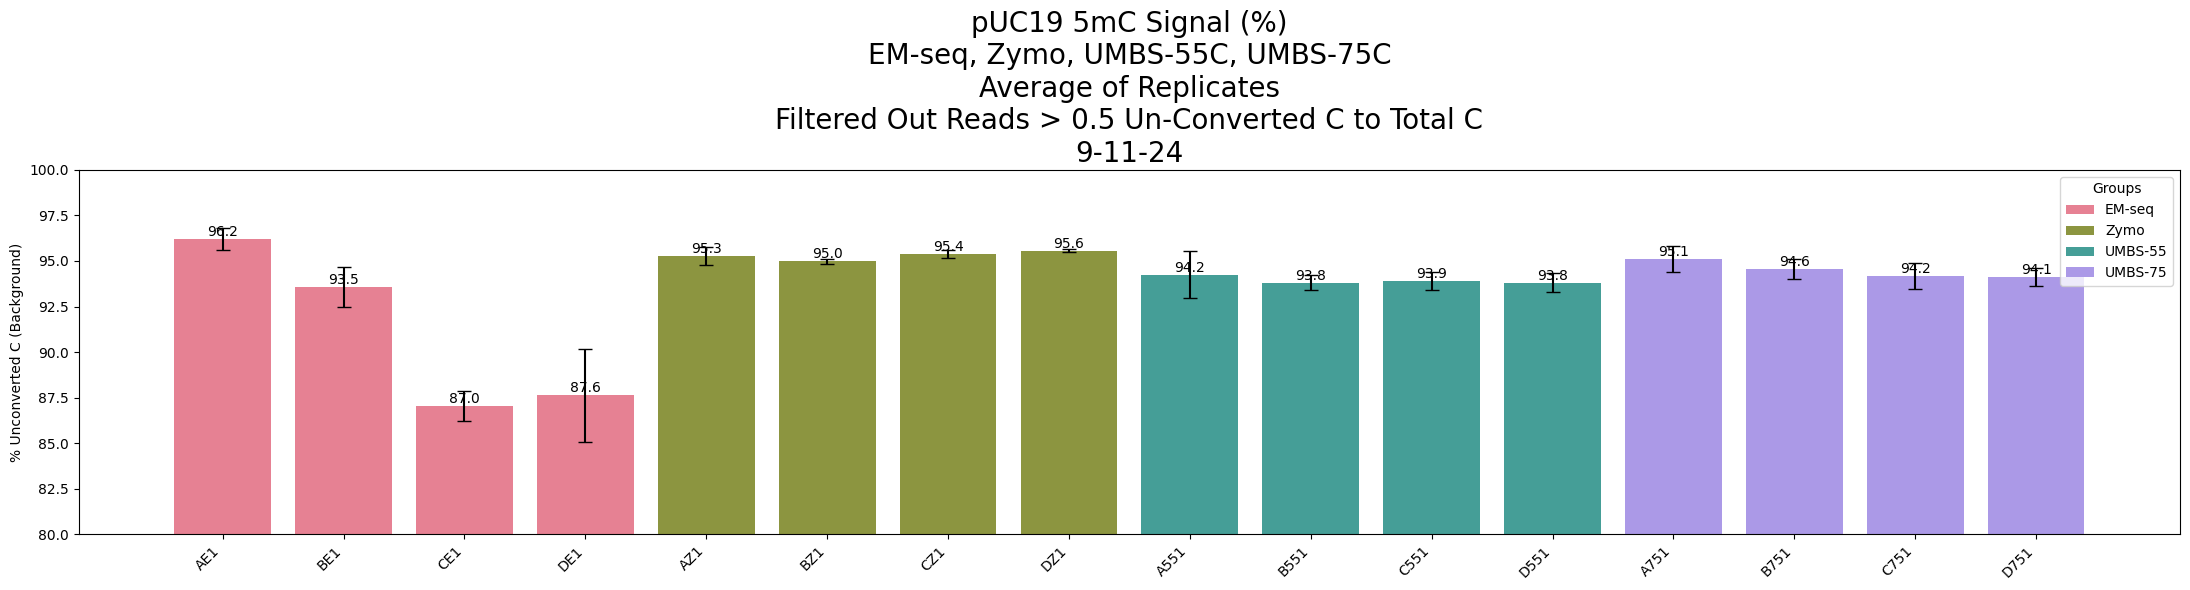

In [348]:
generate_bar_graph(df_ap, value_col='mean', yrange=(80,100),ylabel = '% Unconverted C (Background)',
                title= "pUC19 5mC Signal (%)\nEM-seq, Zymo, UMBS-55C, UMBS-75C\nAverage of Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                   groups={'EM-seq':[0,1,2,3],'Zymo':[4,5,6,7],'UMBS-55':[8,9,10,11],'UMBS-75':[12,13,14,15]})

#### DNA Publication Data: pUC19 5mC EM-seq, UMBS-55C, UMBS-75C (Mean of Replicates) 9-11-24

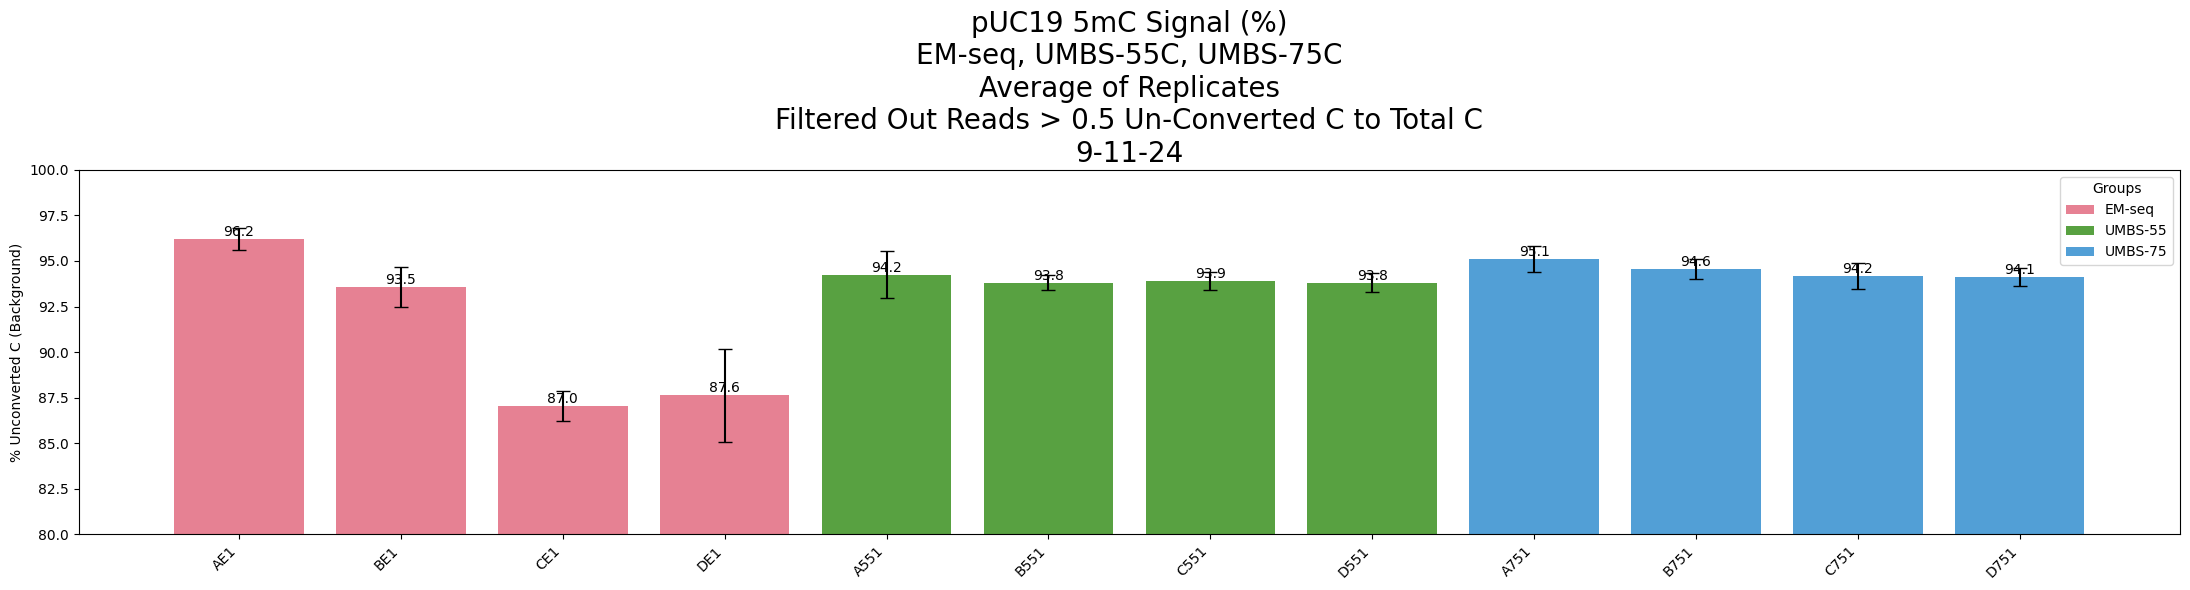

In [350]:
generate_bar_graph(df_ap,value_col='mean', yrange=(80,100),ylabel = '% Unconverted C (Background)',
                title= "pUC19 5mC Signal (%)\nEM-seq, UMBS-55C, UMBS-75C\nAverage of Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                   groups={'EM-seq':[0,1,2,3],'UMBS-55':[8,9,10,11],'UMBS-75':[12,13,14,15]})

#### DNA Publication Data: pUC19 5mC EM-seq vs.UMBS-55C (Mean of Replicates) 9-11-24

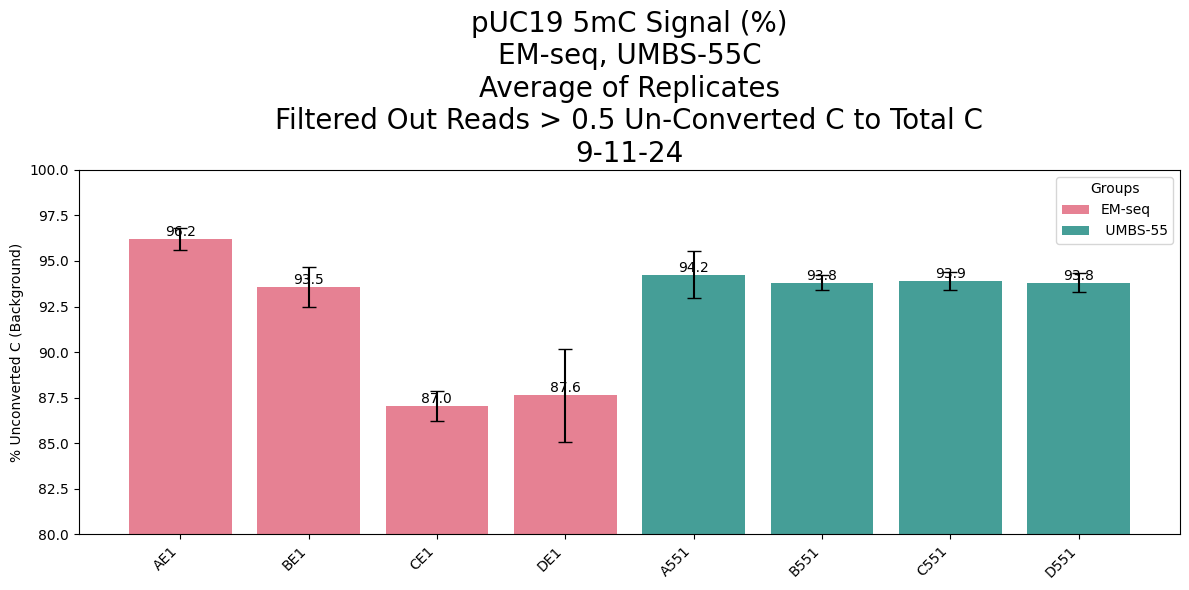

In [351]:
generate_bar_graph(df_ap,value_col='mean', yrange=(80,100),ylabel = '% Unconverted C (Background)', size=(12,6),
                title= "pUC19 5mC Signal (%)\nEM-seq, UMBS-55C\nAverage of Replicates\nFiltered Out Reads > 0.5 Un-Converted C to Total C\n9-11-24",
                groups={'EM-seq':[0,1,2,3],' UMBS-55':[8,9,10,11]})

## Polars Experiments

#### Create Conv_Unconv Ratio

In [103]:
in_paths = mkpaths("ratio_conv_unconv",refs)
out_path = mkpath("figures")

>>> {ratio_conv_unconv_lambda} 00:15:48_09-26-2024
>>> {figures} 00:15:48_09-26-2024


In [140]:
import polars as pl

In [242]:
mz = 10
dcg = (pl.read_csv(in_paths['lambda']/'D5.tsv.gz',separator='\t')
    .filter(pl.col('Motif').str.contains(r'^CG'))
    .with_columns((pl.col('Pos')/mz).ceil()*mz)
    )
dcg            

shape: (6_226, 10)
┌────────┬────────┬─────────┬────────┬───┬───────┬────────────┬──────────────┬───────┐
│ Sample ┆ Chrom  ┆ Pos     ┆ Strand ┆ … ┆ Depth ┆ Ratio_conv ┆ Ratio_unconv ┆ Motif │
│ ---    ┆ ---    ┆ ---     ┆ ---    ┆   ┆ ---   ┆ ---        ┆ ---          ┆ ---   │
│ str    ┆ str    ┆ f64     ┆ str    ┆   ┆ i64   ┆ f64        ┆ f64          ┆ str   │
╞════════╪════════╪═════════╪════════╪═══╪═══════╪════════════╪══════════════╪═══════╡
│ D5     ┆ lambda ┆ 10.0    ┆ +      ┆ … ┆ 63    ┆ 0.825397   ┆ 0.174603     ┆ CGG   │
│ D5     ┆ lambda ┆ 10.0    ┆ -      ┆ … ┆ 89    ┆ 0.730337   ┆ 0.269663     ┆ CGC   │
│ D5     ┆ lambda ┆ 10.0    ┆ +      ┆ … ┆ 103   ┆ 0.834951   ┆ 0.165049     ┆ CGA   │
│ D5     ┆ lambda ┆ 10.0    ┆ -      ┆ … ┆ 231   ┆ 0.636364   ┆ 0.363636     ┆ CGC   │
│ D5     ┆ lambda ┆ 20.0    ┆ +      ┆ … ┆ 407   ┆ 0.690418   ┆ 0.309582     ┆ CGC   │
│ …      ┆ …      ┆ …       ┆ …      ┆ … ┆ …     ┆ …          ┆ …            ┆ …     │
│ D5     ┆ lambda ┆ 48490.0 ┆ -      ┆ … ┆ 510   ┆ 0.676471   ┆ 0.323529     ┆ CGG   │
│ D5     ┆ lambda ┆ 48500.0 ┆ +      ┆ … ┆ 178   ┆ 0.696629   ┆ 0.303371     ┆ CGA   │
│ D5     ┆ lambda ┆ 48500.0 ┆ -      ┆ … ┆ 168   ┆ 0.738095   ┆ 0.261905     ┆ CGG   │
│ D5     ┆ lambda ┆ 48510.0 ┆ +      ┆ … ┆ 36    ┆ 0.805556   ┆ 0.194444     ┆ CG    │
│ D5     ┆ lambda ┆ 48510.0 ┆ -      ┆ … ┆ 39    ┆ 0.666667   ┆ 0.333333     ┆ CGT   │
└────────┴────────┴─────────┴────────┴───┴───────┴────────────┴──────────────┴───────┘

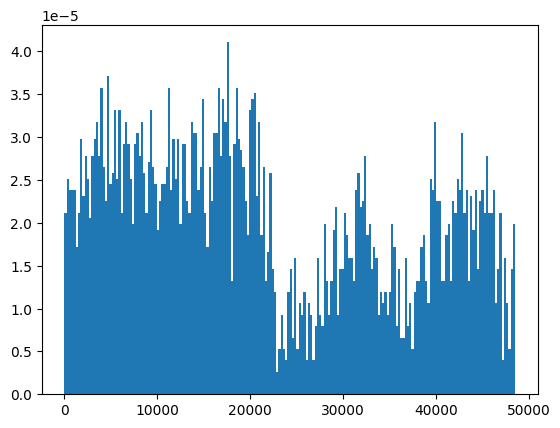

In [243]:
a=plt.hist(dcg['Pos'],density=True,bins=200)

In [247]:
mz = 10
dcga = (pl.concat([pl.read_csv(f,separator='\t') for f in in_paths['lambda'].glob('*')])
    .filter(pl.col('Motif').str.contains(r'^CG'))
    .filter(pl.col('Strand') == '+')
    .filter(pl.col('Ratio_unconv') > .4)
    .with_columns((pl.col('Pos')/mz).ceil()*mz))
dcga

shape: (3_216, 10)
┌────────┬────────┬─────────┬────────┬───┬───────┬────────────┬──────────────┬───────┐
│ Sample ┆ Chrom  ┆ Pos     ┆ Strand ┆ … ┆ Depth ┆ Ratio_conv ┆ Ratio_unconv ┆ Motif │
│ ---    ┆ ---    ┆ ---     ┆ ---    ┆   ┆ ---   ┆ ---        ┆ ---          ┆ ---   │
│ str    ┆ str    ┆ f64     ┆ str    ┆   ┆ i64   ┆ f64        ┆ f64          ┆ str   │
╞════════╪════════╪═════════╪════════╪═══╪═══════╪════════════╪══════════════╪═══════╡
│ TD2    ┆ lambda ┆ 6030.0  ┆ +      ┆ … ┆ 2009  ┆ 0.594823   ┆ 0.405177     ┆ CGA   │
│ TD2    ┆ lambda ┆ 6050.0  ┆ +      ┆ … ┆ 1983  ┆ 0.599597   ┆ 0.400403     ┆ CGG   │
│ TD2    ┆ lambda ┆ 6060.0  ┆ +      ┆ … ┆ 1868  ┆ 0.596895   ┆ 0.403105     ┆ CGG   │
│ TD2    ┆ lambda ┆ 24470.0 ┆ +      ┆ … ┆ 1183  ┆ 0.599324   ┆ 0.400676     ┆ CGT   │
│ TD2    ┆ lambda ┆ 26830.0 ┆ +      ┆ … ┆ 1331  ┆ 0.584523   ┆ 0.415477     ┆ CGC   │
│ …      ┆ …      ┆ …       ┆ …      ┆ … ┆ …     ┆ …          ┆ …            ┆ …     │
│ D9     ┆ lambda ┆ 16830.0 ┆ +      ┆ … ┆ 890   ┆ 0.597753   ┆ 0.402247     ┆ CGG   │
│ D9     ┆ lambda ┆ 35230.0 ┆ +      ┆ … ┆ 1058  ┆ 0.587902   ┆ 0.412098     ┆ CGG   │
│ D9     ┆ lambda ┆ 48480.0 ┆ +      ┆ … ┆ 634   ┆ 0.589905   ┆ 0.410095     ┆ CGG   │
│ T8     ┆ lambda ┆ 20.0    ┆ +      ┆ … ┆ 359   ┆ 0.593315   ┆ 0.406685     ┆ CGG   │
│ D7     ┆ lambda ┆ 48490.0 ┆ +      ┆ … ┆ 348   ┆ 0.597701   ┆ 0.402299     ┆ CGG   │
└────────┴────────┴─────────┴────────┴───┴───────┴────────────┴──────────────┴───────┘

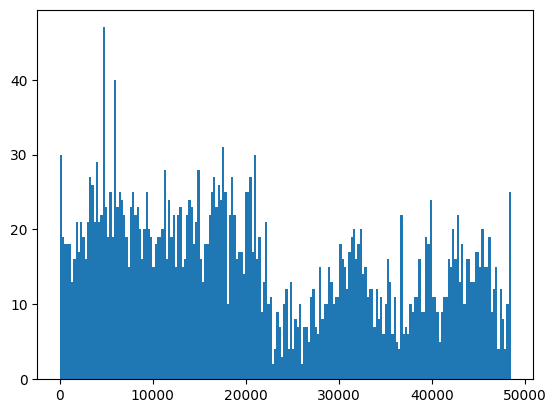

In [248]:
_=plt.hist(x=dcga['Pos'],bins=200)

In [222]:
mz = 100
dcga = (pl.concat([pl.read_csv(f,separator='\t') for f in in_paths['lambda'].glob('*')])
    .filter(pl.col('Motif').str.contains(r'^CG'))
    .filter(pl.col('Ratio_unconv') > .5)
    .with_columns((pl.col('Pos')/mz).ceil()*mz))
dcga

shape: (67, 10)
┌────────┬────────┬─────────┬────────┬───┬───────┬────────────┬──────────────┬───────┐
│ Sample ┆ Chrom  ┆ Pos     ┆ Strand ┆ … ┆ Depth ┆ Ratio_conv ┆ Ratio_unconv ┆ Motif │
│ ---    ┆ ---    ┆ ---     ┆ ---    ┆   ┆ ---   ┆ ---        ┆ ---          ┆ ---   │
│ str    ┆ str    ┆ f64     ┆ str    ┆   ┆ i64   ┆ f64        ┆ f64          ┆ str   │
╞════════╪════════╪═════════╪════════╪═══╪═══════╪════════════╪══════════════╪═══════╡
│ DD4    ┆ lambda ┆ 100.0   ┆ -      ┆ … ┆ 135   ┆ 0.466667   ┆ 0.533333     ┆ CGC   │
│ DD2    ┆ lambda ┆ 100.0   ┆ -      ┆ … ┆ 217   ┆ 0.488479   ┆ 0.511521     ┆ CGC   │
│ DD2    ┆ lambda ┆ 100.0   ┆ +      ┆ … ┆ 407   ┆ 0.4914     ┆ 0.5086       ┆ CGC   │
│ DD2    ┆ lambda ┆ 100.0   ┆ -      ┆ … ┆ 513   ┆ 0.448343   ┆ 0.551657     ┆ CGA   │
│ DD2    ┆ lambda ┆ 100.0   ┆ +      ┆ … ┆ 448   ┆ 0.497768   ┆ 0.502232     ┆ CGG   │
│ …      ┆ …      ┆ …       ┆ …      ┆ … ┆ …     ┆ …          ┆ …            ┆ …     │
│ DD2    ┆ lambda ┆ 20800.0 ┆ -      ┆ … ┆ 960   ┆ 0.469792   ┆ 0.530208     ┆ CGC   │
│ DD2    ┆ lambda ┆ 22600.0 ┆ -      ┆ … ┆ 1132  ┆ 0.492049   ┆ 0.507951     ┆ CGT   │
│ DD2    ┆ lambda ┆ 26200.0 ┆ +      ┆ … ┆ 1204  ┆ 0.499169   ┆ 0.500831     ┆ CGG   │
│ DD2    ┆ lambda ┆ 36700.0 ┆ +      ┆ … ┆ 1247  ┆ 0.494787   ┆ 0.505213     ┆ CGT   │
│ DD2    ┆ lambda ┆ 36700.0 ┆ +      ┆ … ┆ 1176  ┆ 0.497449   ┆ 0.502551     ┆ CGA   │
└────────┴────────┴─────────┴────────┴───┴───────┴────────────┴──────────────┴───────┘

## Step: figures_concentration

In [654]:
in_path = mkpath("../experiment_conc.csv")
out_path = mkpath("figures")

>>> {../experiment_conc.csv} 22:49:52_09-24-2024
>>> {figures} 22:49:52_09-24-2024


In [700]:
df_conc = pd.read_csv(in_path)
df_conc.head()

SampleID RecipeID  Amount  Conc
0      AE1   EM-seq    5 ng  36.4
1      AE2   EM-seq    5 ng  35.8
2      AE3   EM-seq    5 ng  47.2
3      BE1   EM-seq  0.5 ng  25.0
4      BE2   EM-seq  0.5 ng  24.2

In [701]:
df_conc = pd.read_csv(in_path)

# set the correct order
recipe_order = ['EM-seq', 'Zymo', 'UMBS-55', 'UMBS-75']
amount_order = ['5 ng','0.5 ng', '50 pg', '10 pg']

df_conc['RecipeID'] = pd.Categorical(df_conc['RecipeID'], categories=recipe_order, ordered=True)
df_conc['Amount']   = pd.Categorical(df_conc['Amount']  , categories=amount_order, ordered=True)

# group by 'Amount' then 'RecipeID' get the 'Conc' and finally calcuate the 'mean' and 'std'
df_conc = (df_conc.groupby(['Amount','RecipeID'],observed=True)['Conc']
        .agg(['mean','std'])
        .reset_index())
df_conc

Amount RecipeID       mean        std
0     5 ng   EM-seq  39.800000   6.415606
1     5 ng     Zymo  29.666667   4.239497
2     5 ng  UMBS-55  53.600000  11.881077
3     5 ng  UMBS-75  54.666667  10.153489
4   0.5 ng   EM-seq  24.600000   0.400000
5   0.5 ng     Zymo  21.300000   8.876373
6   0.5 ng  UMBS-55  63.266667   8.732315
7   0.5 ng  UMBS-75  69.800000   3.903844
8    50 pg   EM-seq   0.596667   0.014048
9    50 pg     Zymo   1.796667   0.045092
10   50 pg  UMBS-55  19.833333   3.453018
11   50 pg  UMBS-75  16.133333   3.458805
12   10 pg   EM-seq   0.935333   0.317328
13   10 pg     Zymo   1.726667   0.447698
14   10 pg  UMBS-55  11.706667   3.428430
15   10 pg  UMBS-75  12.233333   1.962991

In [702]:
# generate_bar_graph() expects a single label, generated with .assign Rem: .astype(str) to convert each column to str
df_conc = df_conc.assign(label=lambda d: d['Amount'].astype(str) + ', ' + d['RecipeID'].astype(str))[['label','mean','std']]

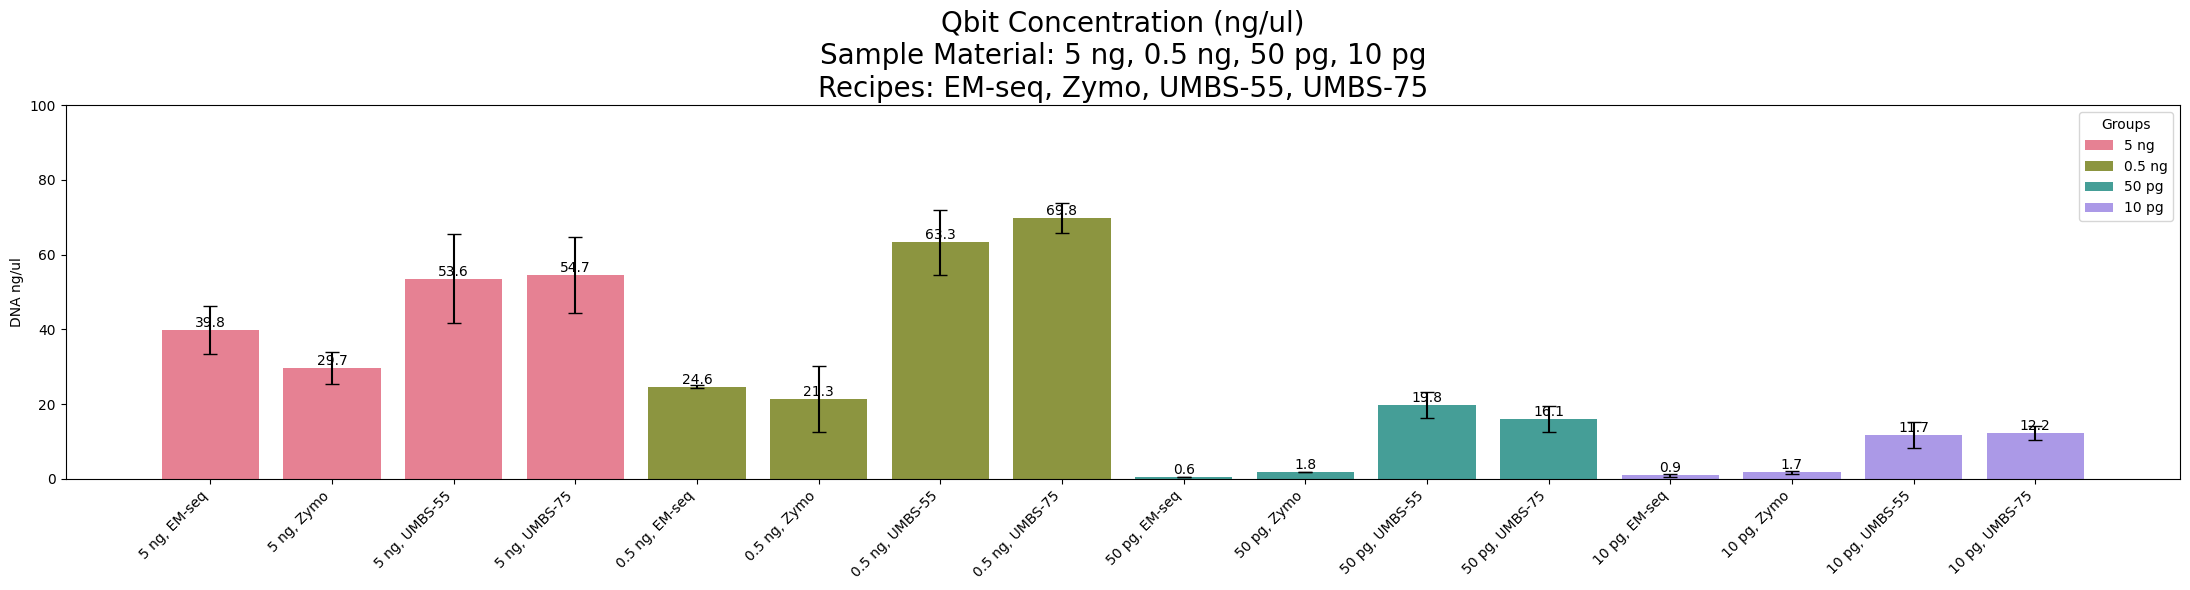

In [703]:
generate_bar_graph(df_conc,value_col='mean',label_col='label', ylabel='DNA ng/ul',
                   title="Qbit Concentration (ng/ul)\nSample Material: 5 ng, 0.5 ng, 50 pg, 10 pg\nRecipes: EM-seq, Zymo, UMBS-55, UMBS-75",
                   groups={'5 ng': range(0,4), '0.5 ng': range(4,8), '50 pg': range(8,12), '10 pg': range(12,16)})

## Step: figures_cmer_background

#### Analyze Background by Cmer 

In [199]:
in_paths = mkpaths("ratio_conv_unconv",refs)
out_path = mkpath("figures")

>>> {ratio_conv_unconv_5mC164} 11:16:43_09-06-2024
>>> {ratio_conv_unconv_pUC19} 11:16:43_09-06-2024
>>> {ratio_conv_unconv_lambda} 11:16:43_09-06-2024
>>> {figures} 11:16:43_09-06-2024


In [192]:
samples

['0',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'E1',
 'E2',
 'E3',
 'E4',
 'L1',
 'L2',
 'L3',
 'L4']

In [200]:
#umbs = ['55:65','55:75','55:85','60:50','60:55','60:60','65:35','65:40','65:45','70:28','70:30','70:32','75:20','75:25','75:30']
#commercial = ['Bio','Bioplus','Dia8','Dia','Pro8','Pro']
methyl = ['0','A1','A2','A3','A4','A5']
ethyl = ['0','E1','E2','E3','E4',]
ally = ['0','L1','L2','L3','L4']

In [201]:
groups = {'methyl': methyl,'ethyl': ethyl, 'ally':ally}

In [206]:
def background_by_cmer(path, sample, min_depth=10, every_nth=1):
    cmers, c_offset = ['TC','CC','AC','GC'], 1
    ref = str(path).split('_')[-1]
    seq = fasta2seq(get_ref(ref,'fa'))
    df,a5c,ac = conv_unconverted(path, sample, min_depth, every_nth,window_size=None)
    df['Ratio'] = df['Ratio'] / 100
    a5c,ac = a5c/100, ac/100

    df['Cmer'] = ""
    for cmer in cmers:
        pdcs = find_cmers(seq, cmer, c_offset=c_offset) # pred cmer pos
        df.loc[df['Pos'].isin(pdcs), 'Cmer'] = cmer
    
    dfc_data = []
    for cmer in cmers:
        ratios = df[(df.Cmer == cmer) & (df.Meth == 0)]['Ratio']
        if len(ratios) > 0:
            dfc_data.append([cmer, sum(ratios)/len(ratios), sum(ratios)/len(df)])
        else:
            dfc_data.append([cmer, 0, 0])
    
    dfc = pd.DataFrame(dfc_data, columns=['cmer','avg_cmer','con_cmer'])# average_ratio_cmer, contribution_ratio_cmer
    return dfc

In [207]:
def print_cmer_background_by_group(path, group_label,group,):
    ref = str(path).split('_')[-1]
    print(f'{group_label} = {group}')
    print('----------------')
    for sample in group:
        dfc = background_by_cmer(path,sample)
        dfc[['avg_cmer','con_cmer']] = 100*dfc[['avg_cmer','con_cmer']].round(4) 
        print(f'Sample= {sample}')
        print(f'Background={round(dfc.con_cmer.sum(),5)}%')
        print(dfc[['cmer','avg_cmer','con_cmer']])
        print('----------------')

In [208]:
def subfigure_cmer_background_by_group(path, group_label, group, statistic='avg_cmer', ax=None):
    all_data = []
    for sample in group:
        dfc = background_by_cmer(path, sample)
        dfc[['avg_cmer', 'con_cmer']] = 100 * dfc[['avg_cmer', 'con_cmer']].round(4)
        dfc['sample'] = sample
        all_data.append(dfc)
    combined_df = pd.concat(all_data, ignore_index=True)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    sns.barplot(x='sample', y=statistic, hue='cmer', data=combined_df, ax=ax)
    
    title = f'Average Cmer Background for {group_label}' if statistic == 'avg_cmer' else f'Contribution by Cmer to Background for {group_label}'
    ax.set_title(title)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Average Cmer (%)' if statistic == 'avg_cmer' else 'Contribution (%)')
    ax.legend(title='Cmer')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    return ax

def figure_cmer_background_group(path, groups, group_name='Groups', statistic='avg_cmer'):
    ref = str(path).split('_')[-1].capitalize()
    fig, axs = plt.subplots(len(groups), 1, figsize=(16, 12)) 
    fig.suptitle(f'{experiment_title}\nCmer {ref} Background Analysis for {group_name} ({statistic})', fontsize=16)
    
    for (group_label, group), ax in zip(groups.items(), axs):
        subfigure_cmer_background_by_group(path, group_label, group, statistic=statistic, ax=ax)
    
    plt.tight_layout()
    save_format='png'
    save_path = f'figures/cmer_analysis_{group_name.lower()}_{ref}.{save_format}'
    plt.savefig(save_path, format=save_format, bbox_inches='tight')
    plt.show()

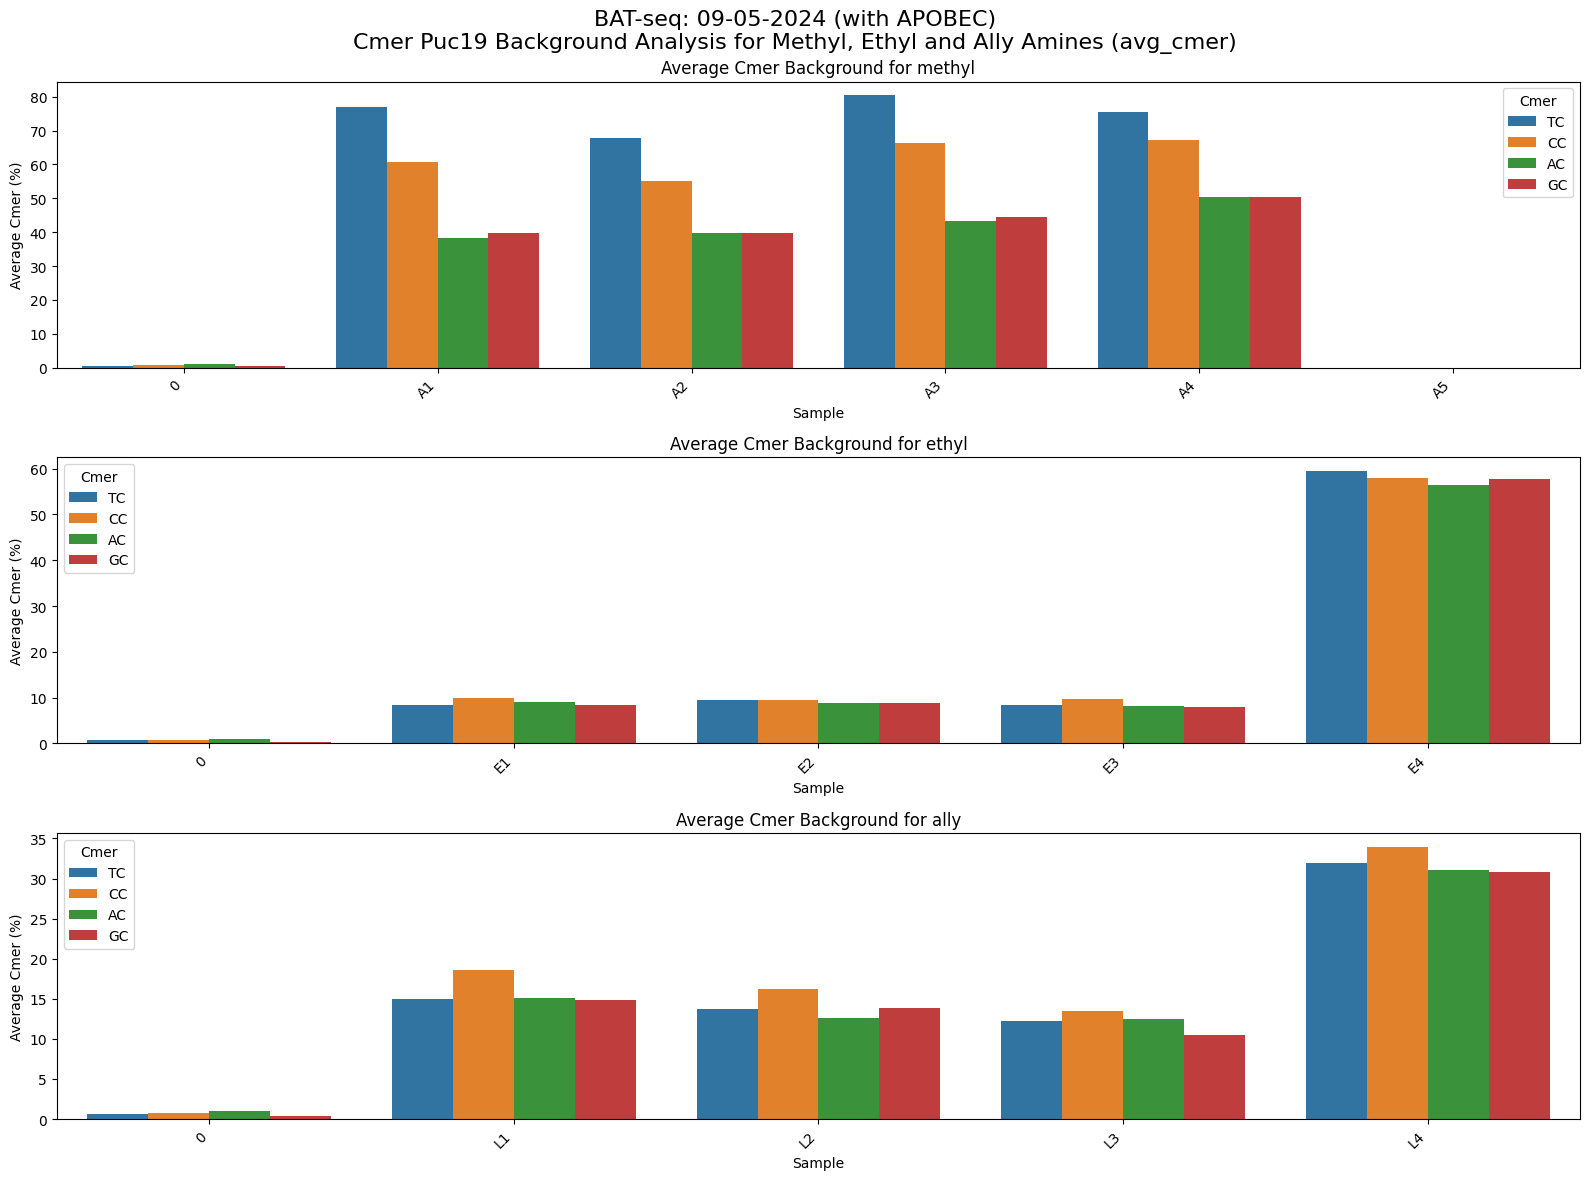

In [210]:
figure_cmer_background_group(in_paths['pUC19'], groups, group_name='Methyl, Ethyl and Ally Amines', statistic='avg_cmer')

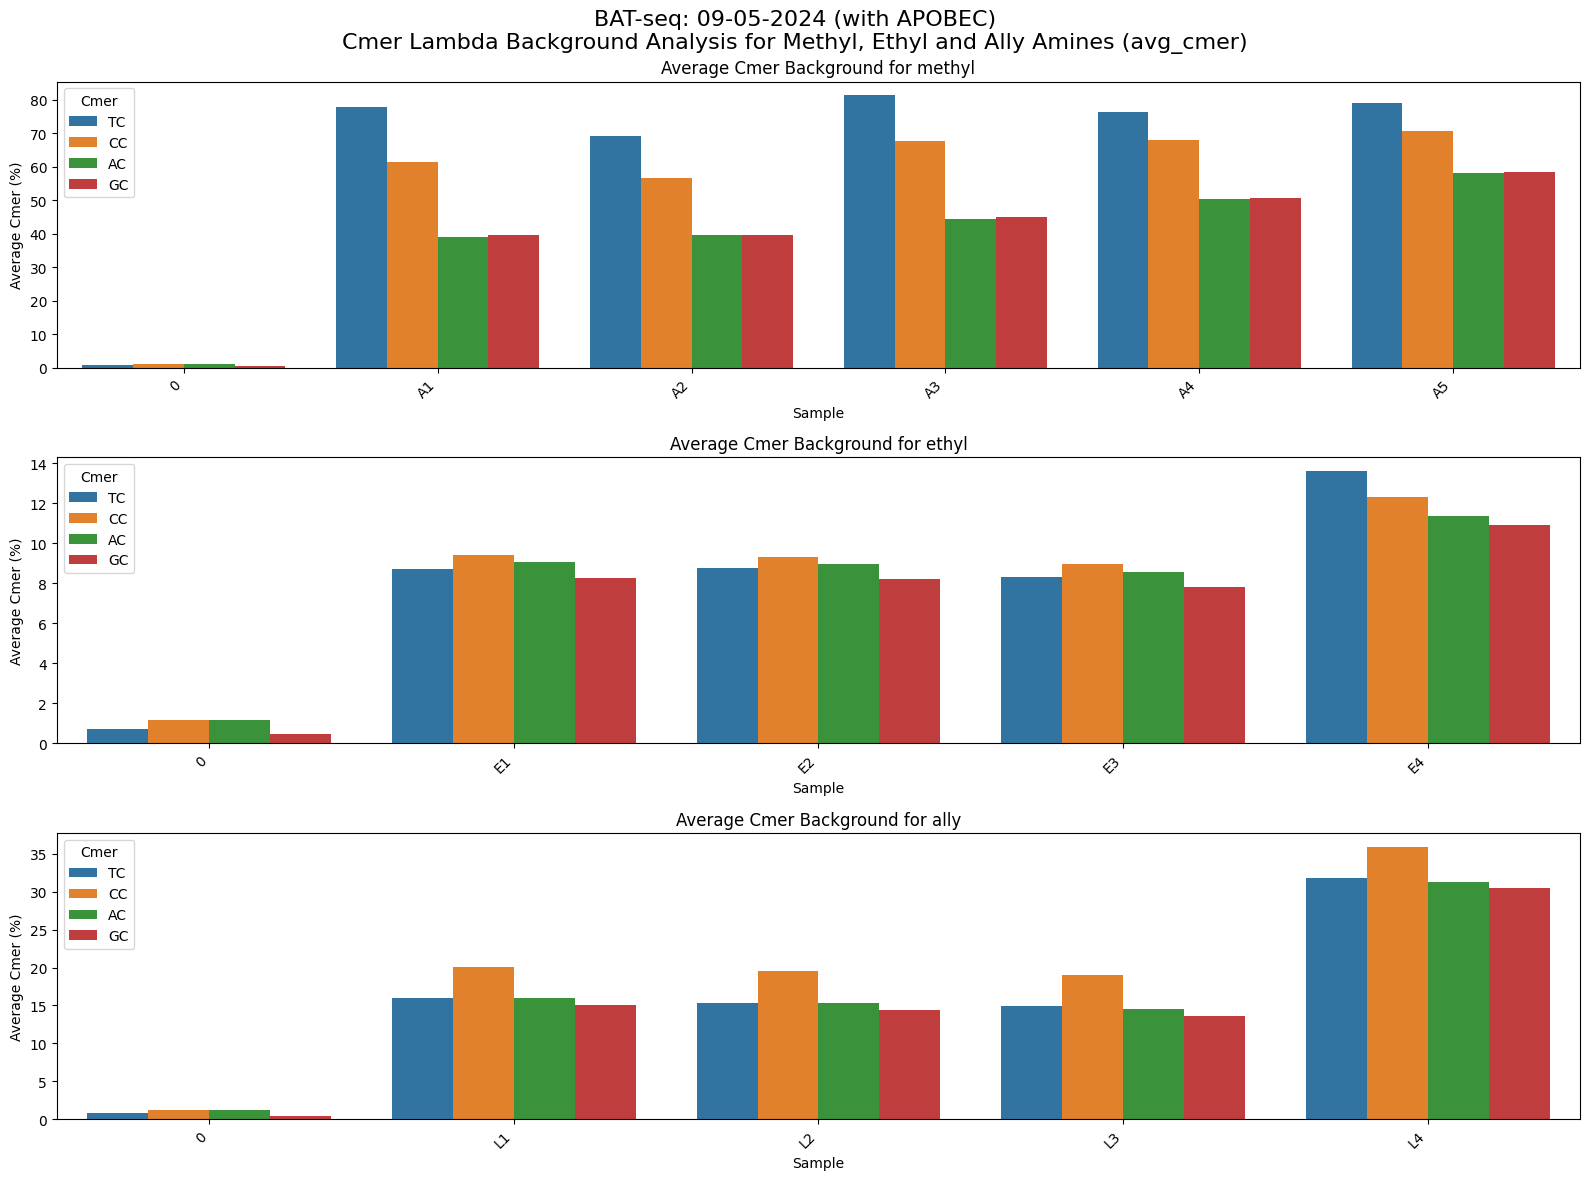

In [209]:
figure_cmer_background_group(in_paths['lambda'], groups, group_name='Methyl, Ethyl and Ally Amines', statistic='avg_cmer')

## Analyze Unusual Outliers

In [37]:
#in_paths = mkpaths("ratio_unconverted_filter",refs)
in_paths = mkpaths("ratio_conv_unconv",refs)

in_path = in_paths['lambda']
out_path = mkpath("figures")

>>> {ratio_conv_unconv_pUC19} 10:33:15_06-26-2024
>>> {ratio_conv_unconv_lambda} 10:33:15_06-26-2024
>>> {figures} 10:33:15_06-26-2024


In [38]:
def unconverted_df(path, sample, min_depth,every_nth):
    ref = str(path).split('_')[-1]
    df = pd.read_csv(fname(path, sample, 'tsv.gz'),sep='\t')
    df.index = range(1, len(df) + 1)
    df = df[['Pos', ratio_conv_unconv, 'Depth']] 
    df = df.rename(columns={ratio_conv_unconv: 'Ratio'})
    df['Ratio'] = df['Ratio'] * 100
    df['Meth'] = 0
    meths = list(set(df.Pos.tolist()).intersection(refs_meth[ref]))
    df.loc[df['Pos'].isin(meths), 'Meth'] = 1
    df  = df[df.Depth >= min_depth]
    t5c, tc = df[df.Meth == 1]['Ratio'].tolist(), df[df.Meth == 0]['Ratio'].tolist()
    #a5c = round(sum(t5c)/len(t5c),1) if len(t5c) > 0 else 0
    #ac  = round(sum(tc)/len(tc),1)   if len(tc)  > 0 else 0
    a5c = round(sum(t5c)/len(t5c),2) if len(t5c) > 0 else 0
    ac  = round(sum(tc)/len(tc),2)   if len(tc)  > 0 else 0
    df = df.iloc[::every_nth]
    #print(f'{ref},{sample},{ac},{a5c}', file=avgfile) # Save averages to file
    return df, a5c, ac

In [39]:
df,a5c,ac = unconverted_df(in_path, '2a', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  8.37790    561     0
7883   13855  5.87084    511     0
10884  19101  3.24254    771     0
11060  19419  3.18560    722     0
15627  30029  6.33609    363     0

In [1350]:
df,a5c,ac = unconverted_df(in_path, '2b', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  6.73317    401     0
7634   13415  3.89222    334     0
7688   13509  3.44037    436     0
7883   13855  4.79798    396     0
8795   15414  4.15755    457     0
15627  30029  5.88235    306     0
18673  36693  3.44168    523     0

In [1351]:
df,a5c,ac = unconverted_df(in_path, '3A', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  8.01187    674     0
3356    5936  3.06834    717     0
7634   13415  3.93258    534     0
7883   13855  6.07407    675     0
15627  30029  6.98690    458     0
18673  36693  3.63850    852     0

In [606]:
df,a5c,ac = unconverted_df(in_path, '3B', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  6.48148    432     0
7883   13855  7.14286    392     0
8795   15414  3.04762    525     0
15627  30029  6.08108    296     0

In [606]:
df,a5c,ac = unconverted_df(in_path, '3B', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  6.48148    432     0
7883   13855  7.14286    392     0
8795   15414  3.04762    525     0
15627  30029  6.08108    296     0

In [607]:
df,a5c,ac = unconverted_df(in_path, '3C', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
57       136  4.16667     24     0
3063    5458  7.98969    388     0
7883   13855  6.89655    348     0
11060  19419  4.07725    466     0
15627  30029  6.45161    217     0
18673  36693  3.04878    492     0

In [608]:
df,a5c,ac = unconverted_df(in_path, '3D', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  8.21918    511     0
7883   13855  7.63359    524     0
15627  30029  4.12979    339     0

In [609]:
df,a5c,ac = unconverted_df(in_path, '3E', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
5          5  4.16667     24     0
3063    5458  6.33803    426     0
7883   13855  5.05051    396     0
15627  30029  5.73477    279     0

In [610]:
df,a5c,ac = unconverted_df(in_path, '3F', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos     Ratio  Depth  Meth
3063    5458   8.27815    302     0
7883   13855   3.93443    305     0
15627  30029   6.57277    213     0
18673  36693   3.77778    450     0
24182  48502  10.00000     10     0

In [611]:
df,a5c,ac = unconverted_df(in_path, '3G', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  8.81543    363     0
7883   13855  4.14508    386     0
15627  30029  8.74525    263     0
18673  36693  3.52250    511     0

In [612]:
df,a5c,ac = unconverted_df(in_path, '3H', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  9.60452    354     0
7883   13855  5.74713    348     0
15627  30029  5.46875    256     0

In [613]:
df,a5c,ac = unconverted_df(in_path, '3I', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos     Ratio  Depth  Meth
3063    5458  10.47840    439     0
7883   13855   6.11765    425     0
15627  30029   4.41640    317     0

In [638]:
df,a5c,ac = unconverted_df(in_path, '3J', 10, 1)
df[(df.Meth == 0) & (df.Ratio > 3)]

Pos    Ratio  Depth  Meth
3063    5458  7.88863    431     0
7634   13415  3.49462    372     0
7883   13855  7.35294    408     0
12850  22841  3.28638    639     0
15627  30029  5.84615    325     0

In [40]:
import find_cmers
lseq = find_cmers.fasta2seq('../../reference/fasta/lambda.fa')

In [56]:
threshold = 3
def common_cmers(sample_list, in_path):
    from collections import Counter
    pos_count = Counter()
    for sample in sample_list:
        df, a5c, ac = unconverted_df(in_path, sample, 10, 1)
        filtered_items = df[(df.Meth == 0) & (df.Ratio > threshold)].Pos.tolist()
        pos_count.update(filtered_items)
    return dict(sorted(pos_count.items(), key=lambda item: item[1], reverse=True))

def get_substring(input_string, pos):
    zero_based_pos = pos - 1
    start_pos = max(0, zero_based_pos - 10)
    end_pos = min(len(input_string), zero_based_pos + 11)
    substring = input_string[start_pos:end_pos]
    pos_in_substring = zero_based_pos - start_pos
    if 0 <= pos_in_substring < len(substring):
        substring = substring[:pos_in_substring] + f'[{substring[pos_in_substring]}]' + substring[pos_in_substring + 1:]
    return substring

In [57]:
print(f'| {"Pos":<5} | {"Freq":<5} | {"Seq"} |')
print(f'|{"-"*6}|{"-"*6}|{"-"*9}|')
for pos, count in common_cmers(['2a','2b','3A','3B','3C','3G','3H','3I','3J'], in_path).items():
    print(f'| {pos:<5} | {count:<5} | {get_substring(lseq, pos)} |')

| Pos   | Freq  | Seq |
|------|------|---------|
| 5458  | 9     | CGGACGTGAA[C]GCGCAGATCA |
| 13855 | 9     | GTGCAGCGAA[C]TGAGCGCGGT |
| 30029 | 9     | TGCTTGATAA[C]AGGAGTCTTC |
| 36693 | 4     | GTCTTTGGTG[G]TTCCCCTCAT |
| 13415 | 3     | AGAGTTTGAA[C]AGGTGGTGAA |
| 19419 | 2     | AAAGAGACGA[C]CACTGCCAGG |
| 15414 | 2     | ACGAAGGGGA[C]GGTGGTCAGG |
| 19101 | 1     | CCGTCGTTGT[C]GGGCGGGGAT |
| 13509 | 1     | GGGAAATCGA[C]CTGACAGAGG |
| 5936  | 1     | CATTCTTGCG[G]TTGCTGCTGA |
| 136   | 1     | TGCTGAAAGC[G]AGGCTTTTTG |
| 22841 | 1     | ATACATTTTT[G]ATTATTATTT |


In [58]:
fh = open('figures/outliers.csv','w')
print('Pos,Freq,Seq',file=fh)
for pos, count in common_cmers(['Bio', 'Dia', 'Epi', 'Pro', 'Qia', 'Ray', 'Zym'], in_path).items():
    if pos <= 6: break
    print(f'{pos},{count},{get_substring(lseq, pos)}',file=fh)
fh.close()

#### Filter by Total Unmethylated with Methylation Ratio > Threshold = 1% (Background)

In [107]:
threshold = 1 # Ratio > threshold %
def all_cmers(sample_list, in_path):
    outliers = []
    for sample in sample_list:
        df, a5c, ac = unconverted_df(in_path, sample, 10, 1)
        out = df[(df.Meth == 0) & (df.Ratio > threshold)].Pos.tolist()
        outliers = outliers + out
    return outliers

def get_substring(input_string, pos):
    zero_based_pos = pos - 1
    start_pos = max(0, zero_based_pos - 10) # was -3
    end_pos = min(len(input_string), zero_based_pos + 11)
    substring = input_string[start_pos:end_pos]
    pos_in_substring = zero_based_pos - start_pos
    if 0 <= pos_in_substring < len(substring):
        substring = substring[:pos_in_substring] + f'[{substring[pos_in_substring]}]' + substring[pos_in_substring + 1:]
    return substring

##### Total UMBS-seq Outliers 

In [111]:
fh = open('figures/outliers_umbs.csv','w')
print('Pos,Seq',file=fh)
for pos in all_cmers(['2a','2b','3A','3B','3C','3G','3H','3I','3J'], in_path):
    print(f'{pos},{get_substring(lseq, pos)}',file=fh)
fh.close()
n_outs_umbs = ! cat figures/outliers_umbs.csv | wc -l 
n_outs_umbs = int(n_outs_umbs[0]); n_outs_umbs

2899

##### Total Kit Outliers

In [112]:
fh = open('figures/outliers_kits.csv','w')
print('Pos,Seq',file=fh)
for pos in all_cmers(['Bio', 'Dia', 'Epi', 'Pro', 'Qia', 'Ray', 'Zym'], in_path):
    print(f'{pos},{get_substring(lseq, pos)}',file=fh)
fh.close()
n_outs_kits = ! cat figures/outliers_kits.csv | wc -l 
n_outs_kits = int(n_outs_kits[0]); n_outs_kits

127769

##### UMBS-seq Outliers with AA[C] or [G]TT

In [119]:
n_cmer = !cat figures/outliers_umbs.csv |grep 'AA\[C\|G\]TT'|sort -n |wc -l
n_cmer = int(n_cmer[0])

print(n_outs_umbs,n_cmer)
print(round(n_cmer/n_outs_umbs,5))

2899 473
0.16316


##### Kits Outliers with AA[C] or [G]TT

In [120]:
n_cmer = !cat figures/outliers_kits.csv |grep 'AA\[C\|G\]TT'|sort -n |wc -l
n_cmer = int(n_cmer[0])

print(n_outs_kits,n_cmer)
print(round(n_cmer/n_outs_kits,5))

127769 8419
0.06589


##### UMBS-seq Outliers Containing AA[C]...GTGC or GCAC...[G]TT (Not considering NNNNNN)

In [121]:
n_cmer = !cat figures/outliers_umbs.csv |grep 'AA\[C.*GTGC\|GCAC.*G\]TT' |wc -l
n_cmer = int(n_cmer[0])

print(n_outs_umbs,n_cmer)
print(round(n_cmer/n_outs_umbs,5))
!cat figures/outliers_umbs.csv |grep 'AA\[C.*GTGC\|GCAC.*G\]TT'|sort -n|uniq -c |sort -rn

2899 7
0.00241
      1 47597,GGTTGCGTAA[C]AAAGTGCGGT
      1 47003,ATTATGCCAA[C]GCCCCGGTGC
      1 38938,ACCTGTCAAA[C]GGTGCAATGA
      1 37977,AAATATCTAA[C]ACCGTGCGTG
      1 32984,GCGATTCAAA[C]AGGTGCTGGG
      1 27180,ATGGTGCACT[G]TTTATACCAA
      1 26527,AACCATTTAA[C]ACACGTGCGA


##### Kits Outliers Containing AA[C]...GTGC or GCAC...[G]TT (Not considering NNNNNN)

In [122]:
total = !cat figures/outliers_kits.csv |wc -l 
total = int(total[0])
count = !cat figures/outliers_kits.csv |grep 'AA\[C.*GTGC\|GCAC.*G\]TT' |wc -l
count = int(count[0])
print(total, count, round(count/total,6))

!cat figures/outliers_kits.csv |grep 'AA\[C.*GTGC\|GCAC.*G\]TT'|sort -n|uniq -c |sort -rn

127769 174 0.001362
      7 8032,ATCAGCAAAA[C]GGCGGTGCCT
      7 42321,CGAGCTTTAA[C]GTGCGCTAAC
      7 3399,ACAGCCGGAA[C]TGCCGTGCCG
      7 20676,TTCGGCAAAA[C]GTGCAGAAGA
      7 119,AGAAAGGAAA[C]GACAGGTGCT
      6 5991,GGCACGTTCC[G]TTATGAGGAT
      6 5986,AGTCCGGCAC[G]TTCCGTTATG
      6 4909,ACGACATGAA[C]TGCAGTGCAG
      6 44423,GTCACGCACT[G]TTAAGCCGCT
      6 32984,GCGATTCAAA[C]AGGTGCTGGG
      6 3234,GAAAACGCAC[G]TTTACCATGA
      6 17795,ACCAGCACGC[G]TTATCTTGGT
      5 39606,CGCACAGATG[G]TTAACTTTGA
      5 39447,GGTCCGGTAA[C]GTGCTGAGCC
      5 38938,ACCTGTCAAA[C]GGTGCAATGA
      5 24840,AGCACCCGGA[G]TTCCGGAAAC
      5 18696,TACTGATGAA[C]GGTGCGGTGA
      5 11115,CAGCGCACTG[G]TTAAGGCGGG
      5 10766,TGCCTGCACA[G]TTCACCGACG
      4 8567,ACATACTGAA[C]TCCGTGCAGC
      4 6944,TGCCGGACAA[C]ACGATGGTGC
      4 48437,CTCCACGCAC[G]TTGTGATATG
      4 47659,GTAAGGCCAA[C]GTGCTCAAAT
      4 47597,GGTTGCGTAA[C]AAAGTGCGGT
      4 47003,ATTATGCCAA[C]GCCCCGGTGC
      4 45331,ATCGACGCAA[C]GATGTGCGCC
  

##### UMBS-seq Outliers Containing AA[C]NNNNNNGTGC or GCACNNNNNN[G]TT

In [123]:
n_cmer = !cat figures/outliers_umbs.csv |grep 'AA\[C.*GTGC$\|,GCAC.*G\]TT' |wc -l
n_cmer = int(n_cmer[0])

print(n_outs_umbs,n_cmer)
print(round(n_cmer/n_outs_umbs,5))
!cat figures/outliers_umbs.csv |grep 'AA\[C.*GTGC$\|,GCAC.*G\]TT'|sort -n|uniq -c |sort -rn

2899 1
0.00034
      1 47003,ATTATGCCAA[C]GCCCCGGTGC


##### Kits Outliers Containing AA[C]NNNNNNGTGC or GCACNNNNNN[G]TT

In [124]:
total = !cat figures/outliers_kits.csv |wc -l 
total = int(total[0])
count = !cat figures/outliers_kits.csv |grep 'AA\[C.*GTGC$\|,GCAC.*G\]TT' |wc -l
count = int(count[0])
print(total, count, round(count/total,6))

!cat figures/outliers_kits.csv |grep 'AA\[C.*GTGC$\|,GCAC.*G\]TT'|sort -n|uniq -c |sort -rn

127769 20 0.000157
      4 6944,TGCCGGACAA[C]ACGATGGTGC
      4 47003,ATTATGCCAA[C]GCCCCGGTGC
      4 34766,AGATGCAAAA[C]GATAAAGTGC
      4 16372,CATGGGGAAA[C]GTCTTGGTGC
      4 14991,GCACGTCCGG[G]TTAACGGCGC
